# L1 regularized regression

### Simon Kornblith (@simonster)

# Ordinary least squares

Finds $\hat\beta$ that minimizes the residual sum of squares:

$$\hat\beta = \underset{\beta}{\operatorname{argmin}} \sum_{i=1}^N \left(y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j\right)^2$$

- Best linear unbiased estimator
- But often high variance, especially if many predictors

# Least squares with high dimensional data

 - Various ways of stabilizing least squares estimates (e.g. ridge regression)
 - In many cases, only a subset of the predictors in X are informative
 - We could sequentially add predictors to the model (forward selection) or remove them (backward elimination)
   - Stopping procedures often ad-hoc
   - Regression coefficients are too large
   - Collinearity can be problematic

# L1 regularized regression (Lasso)

Finds $\hat\beta$ that minimizes:

$$\hat\beta = \underset{\beta}{\operatorname{argmin}} \sum_{i=1}^N \left(y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j\right)^2 + 2N\lambda \sum_{j=1}^p \left|\beta_j\right|$$

 - Shrinks coefficients (some to zero)
 - $\lambda$ controls degree of shrinkage (usually selected by cross-validation)
 - Concave, can be solved relatively efficiently

# L1 regression by coordinate descent

With a single parameter, L1 regression is easy. With standardized x, $\beta = S\left(\frac{1}{N} \sum_{i=1}^N x_i y_i, \lambda\right)$ where $S(z, \gamma)$ is the soft threshold operator:

$$
S(z, \gamma) = \begin{cases} 
      0 & |z| \leq \gamma\\
      z-\gamma & z > 0 \text{ and } |z| > \gamma \\
      z+\gamma & z < 0 \text{ and } |z| < \gamma \\
   \end{cases}
$$

Cycle through each predictor until all predictors converge

Can nest inside an outer loop that does iteratively reweighted least squares to solve an L1-penalized generalized linear model

Described in [Friedman et al., 2010](http://www.jstatsoft.org/v33/i01/paper)

# GLMNET

<textarea style="font-family: monospace; font-size: 0.6em" cols="85" rows="30">```
      subroutine elnet1 (beta,ni,ju,vp,cl,g,no,ne,nx,x,nlam,flmin,ulam,t    879 
     *hr,maxit,xv,  lmu,ao,ia,kin,rsqo,almo,nlp,jerr)
      real vp(ni),g(ni),x(no,ni),ulam(nlam),ao(nx,nlam),rsqo(nlam),almo(    880 
     *nlam),xv(ni)
      real cl(2,ni)                                                         881
      integer ju(ni),ia(nx),kin(nlam)                                       882
      real, dimension (:), allocatable :: a,da                                  
      integer, dimension (:), allocatable :: mm                                 
      real, dimension (:,:), allocatable :: c                                   
      allocate(c(1:ni,1:nx),stat=jerr)                                          
      call get_int_parms(sml,eps,big,mnlam,rsqmax,pmin,exmx)                889
      allocate(a(1:ni),stat=ierr)                                           889
      jerr=jerr+ierr                                                        890
      allocate(mm(1:ni),stat=ierr)                                          890
      jerr=jerr+ierr                                                        891
      allocate(da(1:ni),stat=ierr)                                          891
      jerr=jerr+ierr                                                        892
      if(jerr.ne.0) return                                                  893
      bta=beta                                                              893
      omb=1.0-bta                                                           894
      if(flmin .ge. 1.0)goto 10271                                          894
      eqs=max(eps,flmin)                                                    894
      alf=eqs**(1.0/(nlam-1))                                               894
10271 continue                                                              895
      rsq=0.0                                                               895
      a=0.0                                                                 895
      mm=0                                                                  895
      nlp=0                                                                 895
      nin=nlp                                                               895
      iz=0                                                                  895
      mnl=min(mnlam,nlam)                                                   896
10280 do 10281 m=1,nlam                                                     897
      if(flmin .lt. 1.0)goto 10301                                          897
      alm=ulam(m)                                                           897
      goto 10291                                                            898
10301 if(m .le. 2)goto 10311                                                898
      alm=alm*alf                                                           898
      goto 10291                                                            899
10311 if(m .ne. 1)goto 10321                                                899
      alm=big                                                               899
      goto 10331                                                            900
10321 continue                                                              900
      alm=0.0                                                               901
10340 do 10341 j=1,ni                                                       901
      if(ju(j).eq.0)goto 10341                                              901
      if(vp(j).le.0.0)goto 10341                                            902
      alm=max(alm,abs(g(j))/vp(j))                                          903
10341 continue                                                              904
10342 continue                                                              904
      alm=alf*alm/max(bta,1.0e-3)                                           905
10331 continue                                                              906
10291 continue                                                              906
      dem=alm*omb                                                           906
      ab=alm*bta                                                            906
      rsq0=rsq                                                              906
      jz=1                                                                  907
10350 continue                                                              907
10351 continue                                                              907
      if(iz*jz.ne.0) go to 10360                                            907
      nlp=nlp+1                                                             907
      dlx=0.0                                                               908
10370 do 10371 k=1,ni                                                       908
      if(ju(k).eq.0)goto 10371                                              909
      ak=a(k)                                                               909
      u=g(k)+ak*xv(k)                                                       909
      v=abs(u)-vp(k)*ab                                                     909
      a(k)=0.0                                                              911
      if(v.gt.0.0) a(k)=max(cl(1,k),min(cl(2,k),sign(v,u)/(xv(k)+vp(k)*d    912 
     *em)))
      if(a(k).eq.ak)goto 10371                                              913
      if(mm(k) .ne. 0)goto 10391                                            913
      nin=nin+1                                                             913
      if(nin.gt.nx)goto 10372                                               914
10400 do 10401 j=1,ni                                                       914
      if(ju(j).eq.0)goto 10401                                              915
      if(mm(j) .eq. 0)goto 10421                                            915
      c(j,nin)=c(k,mm(j))                                                   915
      goto 10401                                                            915
10421 continue                                                              916
      if(j .ne. k)goto 10441                                                916
      c(j,nin)=xv(j)                                                        916
      goto 10401                                                            916
10441 continue                                                              917
      c(j,nin)=dot_product(x(:,j),x(:,k))                                   918
10401 continue                                                              919
10402 continue                                                              919
      mm(k)=nin                                                             919
      ia(nin)=k                                                             920
10391 continue                                                              921
      del=a(k)-ak                                                           921
      rsq=rsq+del*(2.0*g(k)-del*xv(k))                                      922
      dlx=max(xv(k)*del**2,dlx)                                             923
10450 do 10451 j=1,ni                                                       923
      if(ju(j).ne.0) g(j)=g(j)-c(j,mm(k))*del                               923
10451 continue                                                              924
10452 continue                                                              924
10371 continue                                                              925
10372 continue                                                              925
      if(dlx.lt.thr)goto 10352                                              925
      if(nin.gt.nx)goto 10352                                               926
      if(nlp .le. maxit)goto 10471                                          926
      jerr=-m                                                               926
      return                                                                926
10471 continue                                                              927
10360 continue                                                              927
      iz=1                                                                  927
      da(1:nin)=a(ia(1:nin))                                                928
10480 continue                                                              928
10481 continue                                                              928
      nlp=nlp+1                                                             928
      dlx=0.0                                                               929
10490 do 10491 l=1,nin                                                      929
      k=ia(l)                                                               929
      ak=a(k)                                                               929
      u=g(k)+ak*xv(k)                                                       929
      v=abs(u)-vp(k)*ab                                                     930
      a(k)=0.0                                                              932
      if(v.gt.0.0) a(k)=max(cl(1,k),min(cl(2,k),sign(v,u)/(xv(k)+vp(k)*d    933 
     *em)))
      if(a(k).eq.ak)goto 10491                                              934
      del=a(k)-ak                                                           934
      rsq=rsq+del*(2.0*g(k)-del*xv(k))                                      935
      dlx=max(xv(k)*del**2,dlx)                                             936
10500 do 10501 j=1,nin                                                      936
      g(ia(j))=g(ia(j))-c(ia(j),mm(k))*del                                  936
10501 continue                                                              937
10502 continue                                                              937
10491 continue                                                              938
10492 continue                                                              938
      if(dlx.lt.thr)goto 10482                                              938
      if(nlp .le. maxit)goto 10521                                          938
      jerr=-m                                                               938
      return                                                                938
10521 continue                                                              939
      goto 10481                                                            940
10482 continue                                                              940
      da(1:nin)=a(ia(1:nin))-da(1:nin)                                      941
10530 do 10531 j=1,ni                                                       941
      if(mm(j).ne.0)goto 10531                                              942
      if(ju(j).ne.0) g(j)=g(j)-dot_product(da(1:nin),c(j,1:nin))            943
10531 continue                                                              944
10532 continue                                                              944
      jz=0                                                                  945
      goto 10351                                                            946
10352 continue                                                              946
      if(nin .le. nx)goto 10551                                             946
      jerr=-10000-m                                                         946
      goto 10282                                                            946
10551 continue                                                              947
      if(nin.gt.0) ao(1:nin,m)=a(ia(1:nin))                                 947
      kin(m)=nin                                                            948
      rsqo(m)=rsq                                                           948
      almo(m)=alm                                                           948
      lmu=m                                                                 949
      if(m.lt.mnl)goto 10281                                                949
      if(flmin.ge.1.0)goto 10281                                            950
      me=0                                                                  950
10560 do 10561 j=1,nin                                                      950
      if(ao(j,m).ne.0.0) me=me+1                                            950
10561 continue                                                              950
10562 continue                                                              950
      if(me.gt.ne)goto 10282                                                951
      if(rsq-rsq0.lt.sml*rsq)goto 10282                                     951
      if(rsq.gt.rsqmax)goto 10282                                           952
10281 continue                                                              953
10282 continue                                                              953
      deallocate(a,mm,c,da)                                                 954
      return                                                                955
      end                                                                   956
      subroutine elnetn (parm,no,ni,x,y,w,jd,vp,cl,ne,nx,nlam,flmin,ulam    958 
     *,thr,isd,  intr,maxit,lmu,a0,ca,ia,nin,rsq,alm,nlp,jerr)
      real vp(ni),x(no,ni),y(no),w(no),ulam(nlam),cl(2,ni)                  959
      real ca(nx,nlam),a0(nlam),rsq(nlam),alm(nlam)                         960
      integer jd(*),ia(nx),nin(nlam)                                        961
      real, dimension (:), allocatable :: xm,xs,xv,vlam                         
      integer, dimension (:), allocatable :: ju                                 
      allocate(xm(1:ni),stat=jerr)                                          966
      allocate(xs(1:ni),stat=ierr)                                          966
      jerr=jerr+ierr                                                        967
      allocate(ju(1:ni),stat=ierr)                                          967
      jerr=jerr+ierr                                                        968
      allocate(xv(1:ni),stat=ierr)                                          968
      jerr=jerr+ierr                                                        969
      allocate(vlam(1:nlam),stat=ierr)                                      969
      jerr=jerr+ierr                                                        970
      if(jerr.ne.0) return                                                  971
      call chkvars(no,ni,x,ju)                                              972
      if(jd(1).gt.0) ju(jd(2:(jd(1)+1)))=0                                  973
      if(maxval(ju) .gt. 0)goto 10581                                       973
      jerr=7777                                                             973
      return                                                                973
10581 continue                                                              974
      call standard1(no,ni,x,y,w,isd,intr,ju,xm,xs,ym,ys,xv,jerr)           975
      if(jerr.ne.0) return                                                  976
      cl=cl/ys                                                              976
      if(isd .le. 0)goto 10601                                              976
10610 do 10611 j=1,ni                                                       976
      cl(:,j)=cl(:,j)*xs(j)                                                 976
10611 continue                                                              976
10612 continue                                                              976
10601 continue                                                              977
      if(flmin.ge.1.0) vlam=ulam/ys                                         978
      call elnet2(parm,ni,ju,vp,cl,y,no,ne,nx,x,nlam,flmin,vlam,thr,maxi    980 
     *t,xv,  lmu,ca,ia,nin,rsq,alm,nlp,jerr)
      if(jerr.gt.0) return                                                  981
10620 do 10621 k=1,lmu                                                      981
      alm(k)=ys*alm(k)                                                      981
      nk=nin(k)                                                             982
10630 do 10631 l=1,nk                                                       982
      ca(l,k)=ys*ca(l,k)/xs(ia(l))                                          982
10631 continue                                                              982
10632 continue                                                              982
      a0(k)=0.0                                                             983
      if(intr.ne.0) a0(k)=ym-dot_product(ca(1:nk,k),xm(ia(1:nk)))           984
10621 continue                                                              985
10622 continue                                                              985
      deallocate(xm,xs,ju,xv,vlam)                                          986
      return                                                                987
      end                                                                   988
      subroutine standard1 (no,ni,x,y,w,isd,intr,ju,xm,xs,ym,ys,xv,jerr)    989
      real x(no,ni),y(no),w(no),xm(ni),xs(ni),xv(ni)                        989
      integer ju(ni)                                                        990
      real, dimension (:), allocatable :: v                                     
      allocate(v(1:no),stat=jerr)                                           993
      if(jerr.ne.0) return                                                  994
      w=w/sum(w)                                                            994
      v=sqrt(w)                                                             995
      if(intr .ne. 0)goto 10651                                             995
      ym=0.0                                                                995
      y=v*y                                                                 996
      ys=sqrt(dot_product(y,y)-dot_product(v,y)**2)                         996
      y=y/ys                                                                997
10660 do 10661 j=1,ni                                                       997
      if(ju(j).eq.0)goto 10661                                              997
      xm(j)=0.0                                                             997
      x(:,j)=v*x(:,j)                                                       998
      xv(j)=dot_product(x(:,j),x(:,j))                                      999
      if(isd .eq. 0)goto 10681                                              999
      xbq=dot_product(v,x(:,j))**2                                          999
      vc=xv(j)-xbq                                                         1000
      xs(j)=sqrt(vc)                                                       1000
      x(:,j)=x(:,j)/xs(j)                                                  1000
      xv(j)=1.0+xbq/vc                                                     1001
      goto 10691                                                           1002
10681 continue                                                             1002
      xs(j)=1.0                                                            1002
10691 continue                                                             1003
10671 continue                                                             1003
10661 continue                                                             1004
10662 continue                                                             1004
      go to 10700                                                          1005
10651 continue                                                             1006
10710 do 10711 j=1,ni                                                      1006
      if(ju(j).eq.0)goto 10711                                             1007
      xm(j)=dot_product(w,x(:,j))                                          1007
      x(:,j)=v*(x(:,j)-xm(j))                                              1008
      xv(j)=dot_product(x(:,j),x(:,j))                                     1008
      if(isd.gt.0) xs(j)=sqrt(xv(j))                                       1009
10711 continue                                                             1010
10712 continue                                                             1010
      if(isd .ne. 0)goto 10731                                             1010
      xs=1.0                                                               1010
      goto 10741                                                           1011
10731 continue                                                             1011
10750 do 10751 j=1,ni                                                      1011
      if(ju(j).eq.0)goto 10751                                             1011
      x(:,j)=x(:,j)/xs(j)                                                  1011
10751 continue                                                             1012
10752 continue                                                             1012
      xv=1.0                                                               1013
10741 continue                                                             1014
10721 continue                                                             1014
      ym=dot_product(w,y)                                                  1014
      y=v*(y-ym)                                                           1014
      ys=sqrt(dot_product(y,y))                                            1014
      y=y/ys                                                               1015
10700 continue                                                             1015
      deallocate(v)                                                        1016
      return                                                               1017
      end                                                                  1018
      subroutine elnet2(beta,ni,ju,vp,cl,y,no,ne,nx,x,nlam,flmin,ulam,th   1020 
     *r,maxit,xv,  lmu,ao,ia,kin,rsqo,almo,nlp,jerr)
      real vp(ni),y(no),x(no,ni),ulam(nlam),ao(nx,nlam),rsqo(nlam),almo(   1021 
     *nlam),xv(ni)
      real cl(2,ni)                                                        1022
      integer ju(ni),ia(nx),kin(nlam)                                      1023
      real, dimension (:), allocatable :: a,g                                   
      integer, dimension (:), allocatable :: mm,ix                              
      call get_int_parms(sml,eps,big,mnlam,rsqmax,pmin,exmx)               1028
      allocate(a(1:ni),stat=jerr)                                          1029
      allocate(mm(1:ni),stat=ierr)                                         1029
      jerr=jerr+ierr                                                       1030
      allocate(g(1:ni),stat=ierr)                                          1030
      jerr=jerr+ierr                                                       1031
      allocate(ix(1:ni),stat=ierr)                                         1031
      jerr=jerr+ierr                                                       1032
      if(jerr.ne.0) return                                                 1033
      bta=beta                                                             1033
      omb=1.0-bta                                                          1033
      ix=0                                                                 1034
      if(flmin .ge. 1.0)goto 10771                                         1034
      eqs=max(eps,flmin)                                                   1034
      alf=eqs**(1.0/(nlam-1))                                              1034
10771 continue                                                             1035
      rsq=0.0                                                              1035
      a=0.0                                                                1035
      mm=0                                                                 1035
      nlp=0                                                                1035
      nin=nlp                                                              1035
      iz=0                                                                 1035
      mnl=min(mnlam,nlam)                                                  1035
      alm=0.0                                                              1036
10780 do 10781 j=1,ni                                                      1036
      if(ju(j).eq.0)goto 10781                                             1036
      g(j)=abs(dot_product(y,x(:,j)))                                      1036
10781 continue                                                             1037
10782 continue                                                             1037
10790 do 10791 m=1,nlam                                                    1037
      alm0=alm                                                             1038
      if(flmin .lt. 1.0)goto 10811                                         1038
      alm=ulam(m)                                                          1038
      goto 10801                                                           1039
10811 if(m .le. 2)goto 10821                                               1039
      alm=alm*alf                                                          1039
      goto 10801                                                           1040
10821 if(m .ne. 1)goto 10831                                               1040
      alm=big                                                              1040
      goto 10841                                                           1041
10831 continue                                                             1041
      alm0=0.0                                                             1042
10850 do 10851 j=1,ni                                                      1042
      if(ju(j).eq.0)goto 10851                                             1042
      if(vp(j).gt.0.0) alm0=max(alm0,g(j)/vp(j))                           1042
10851 continue                                                             1043
10852 continue                                                             1043
      alm0=alm0/max(bta,1.0e-3)                                            1043
      alm=alf*alm0                                                         1044
10841 continue                                                             1045
10801 continue                                                             1045
      dem=alm*omb                                                          1045
      ab=alm*bta                                                           1045
      rsq0=rsq                                                             1045
      jz=1                                                                 1046
      tlam=bta*(2.0*alm-alm0)                                              1047
10860 do 10861 k=1,ni                                                      1047
      if(ix(k).eq.1)goto 10861                                             1047
      if(ju(k).eq.0)goto 10861                                             1048
      if(g(k).gt.tlam*vp(k)) ix(k)=1                                       1049
10861 continue                                                             1050
10862 continue                                                             1050
10870 continue                                                             1050
10871 continue                                                             1050
      if(iz*jz.ne.0) go to 10360                                           1051
10880 continue                                                             1051
      nlp=nlp+1                                                            1051
      dlx=0.0                                                              1052
10890 do 10891 k=1,ni                                                      1052
      if(ix(k).eq.0)goto 10891                                             1052
      gk=dot_product(y,x(:,k))                                             1053
      ak=a(k)                                                              1053
      u=gk+ak*xv(k)                                                        1053
      v=abs(u)-vp(k)*ab                                                    1053
      a(k)=0.0                                                             1055
      if(v.gt.0.0) a(k)=max(cl(1,k),min(cl(2,k),sign(v,u)/(xv(k)+vp(k)*d   1056 
     *em)))
      if(a(k).eq.ak)goto 10891                                             1057
      if(mm(k) .ne. 0)goto 10911                                           1057
      nin=nin+1                                                            1057
      if(nin.gt.nx)goto 10892                                              1058
      mm(k)=nin                                                            1058
      ia(nin)=k                                                            1059
10911 continue                                                             1060
      del=a(k)-ak                                                          1060
      rsq=rsq+del*(2.0*gk-del*xv(k))                                       1061
      y=y-del*x(:,k)                                                       1061
      dlx=max(xv(k)*del**2,dlx)                                            1062
10891 continue                                                             1063
10892 continue                                                             1063
      if(nin.gt.nx)goto 10872                                              1064
      if(dlx .ge. thr)goto 10931                                           1064
      ixx=0                                                                1065
10940 do 10941 k=1,ni                                                      1065
      if(ix(k).eq.1)goto 10941                                             1065
      if(ju(k).eq.0)goto 10941                                             1066
      g(k)=abs(dot_product(y,x(:,k)))                                      1067
      if(g(k) .le. ab*vp(k))goto 10961                                     1067
      ix(k)=1                                                              1067
      ixx=1                                                                1067
10961 continue                                                             1068
10941 continue                                                             1069
10942 continue                                                             1069
      if(ixx.eq.1) go to 10880                                             1070
      goto 10872                                                           1071
10931 continue                                                             1072
      if(nlp .le. maxit)goto 10981                                         1072
      jerr=-m                                                              1072
      return                                                               1072
10981 continue                                                             1073
10360 continue                                                             1073
      iz=1                                                                 1074
10990 continue                                                             1074
10991 continue                                                             1074
      nlp=nlp+1                                                            1074
      dlx=0.0                                                              1075
11000 do 11001 l=1,nin                                                     1075
      k=ia(l)                                                              1075
      gk=dot_product(y,x(:,k))                                             1076
      ak=a(k)                                                              1076
      u=gk+ak*xv(k)                                                        1076
      v=abs(u)-vp(k)*ab                                                    1076
      a(k)=0.0                                                             1078
      if(v.gt.0.0) a(k)=max(cl(1,k),min(cl(2,k),sign(v,u)/(xv(k)+vp(k)*d   1079 
     *em)))
      if(a(k).eq.ak)goto 11001                                             1080
      del=a(k)-ak                                                          1080
      rsq=rsq+del*(2.0*gk-del*xv(k))                                       1081
      y=y-del*x(:,k)                                                       1081
      dlx=max(xv(k)*del**2,dlx)                                            1082
11001 continue                                                             1083
11002 continue                                                             1083
      if(dlx.lt.thr)goto 10992                                             1083
      if(nlp .le. maxit)goto 11021                                         1083
      jerr=-m                                                              1083
      return                                                               1083
11021 continue                                                             1084
      goto 10991                                                           1085
10992 continue                                                             1085
      jz=0                                                                 1086
      goto 10871                                                           1087
10872 continue                                                             1087
      if(nin .le. nx)goto 11041                                            1087
      jerr=-10000-m                                                        1087
      goto 10792                                                           1087
11041 continue                                                             1088
      if(nin.gt.0) ao(1:nin,m)=a(ia(1:nin))                                1088
      kin(m)=nin                                                           1089
      rsqo(m)=rsq                                                          1089
      almo(m)=alm                                                          1089
      lmu=m                                                                1090
      if(m.lt.mnl)goto 10791                                               1090
      if(flmin.ge.1.0)goto 10791                                           1091
      me=0                                                                 1091
11050 do 11051 j=1,nin                                                     1091
      if(ao(j,m).ne.0.0) me=me+1                                           1091
11051 continue                                                             1091
11052 continue                                                             1091
      if(me.gt.ne)goto 10792                                               1092
      if(rsq-rsq0.lt.sml*rsq)goto 10792                                    1092
      if(rsq.gt.rsqmax)goto 10792                                          1093
10791 continue                                                             1094
10792 continue                                                             1094
      deallocate(a,mm,g,ix)                                                1095
      return                                                               1096
      end                                                                  1097
      subroutine chkvars(no,ni,x,ju)                                       1098
      real x(no,ni)                                                        1098
      integer ju(ni)                                                       1099
11060 do 11061 j=1,ni                                                      1099
      ju(j)=0                                                              1099
      t=x(1,j)                                                             1100
11070 do 11071 i=2,no                                                      1100
      if(x(i,j).eq.t)goto 11071                                            1100
      ju(j)=1                                                              1100
      goto 11072                                                           1100
11071 continue                                                             1101
11072 continue                                                             1101
11061 continue                                                             1102
11062 continue                                                             1102
      return                                                               1103
      end                                                                  1104
      subroutine uncomp(ni,ca,ia,nin,a)                                    1105
      real ca(*),a(ni)                                                     1105
      integer ia(*)                                                        1106
      a=0.0                                                                1106
      if(nin.gt.0) a(ia(1:nin))=ca(1:nin)                                  1107
      return                                                               1108
      end                                                                  1109
      subroutine modval(a0,ca,ia,nin,n,x,f)                                1110
      real ca(nin),x(n,*),f(n)                                             1110
      integer ia(nin)                                                      1111
      f=a0                                                                 1111
      if(nin.le.0) return                                                  1112
11080 do 11081 i=1,n                                                       1112
      f(i)=f(i)+dot_product(ca(1:nin),x(i,ia(1:nin)))                      1112
11081 continue                                                             1113
11082 continue                                                             1113
      return                                                               1114
      end                                                                  1115
      subroutine spelnet  (ka,parm,no,ni,x,ix,jx,y,w,jd,vp,cl,ne,nx,nlam   1118 
     *,flmin,ulam,thr,isd,intr,  maxit,lmu,a0,ca,ia,nin,rsq,alm,nlp,jerr
     *)
      real x(*),y(no),w(no),vp(ni),ulam(nlam),cl(2,ni)                     1119
      real ca(nx,nlam),a0(nlam),rsq(nlam),alm(nlam)                        1120
      integer ix(*),jx(*),jd(*),ia(nx),nin(nlam)                           1121
      real, dimension (:), allocatable :: vq;                                   
      if(maxval(vp) .gt. 0.0)goto 11101                                    1124
      jerr=10000                                                           1124
      return                                                               1124
11101 continue                                                             1125
      allocate(vq(1:ni),stat=jerr)                                         1125
      if(jerr.ne.0) return                                                 1126
      vq=max(0.0,vp)                                                       1126
      vq=vq*ni/sum(vq)                                                     1127
      if(ka .ne. 1)goto 11121                                              1128
      call spelnetu  (parm,no,ni,x,ix,jx,y,w,jd,vq,cl,ne,nx,nlam,flmin,u   1131 
     *lam,thr,isd,  intr,maxit,lmu,a0,ca,ia,nin,rsq,alm,nlp,jerr)
      goto 11131                                                           1132
11121 continue                                                             1133
      call spelnetn (parm,no,ni,x,ix,jx,y,w,jd,vq,cl,ne,nx,nlam,flmin,ul   1136 
     *am,thr,isd,intr,  maxit,lmu,a0,ca,ia,nin,rsq,alm,nlp,jerr)
11131 continue                                                             1137
11111 continue                                                             1137
      deallocate(vq)                                                       1138
      return                                                               1139
      end                                                                  1140
      subroutine spelnetu  (parm,no,ni,x,ix,jx,y,w,jd,vp,cl,ne,nx,nlam,f   1143 
     *lmin,ulam,thr,isd,intr,  maxit,lmu,a0,ca,ia,nin,rsq,alm,nlp,jerr)
      real x(*),y(no),w(no),vp(ni),ulam(nlam),cl(2,ni)                     1144
      real ca(nx,nlam),a0(nlam),rsq(nlam),alm(nlam)                        1145
      integer ix(*),jx(*),jd(*),ia(nx),nin(nlam)                           1146
      real, dimension (:), allocatable :: xm,xs,g,xv,vlam                       
      integer, dimension (:), allocatable :: ju                                 
      allocate(g(1:ni),stat=jerr)                                          1151
      allocate(xm(1:ni),stat=ierr)                                         1151
      jerr=jerr+ierr                                                       1152
      allocate(xs(1:ni),stat=ierr)                                         1152
      jerr=jerr+ierr                                                       1153
      allocate(ju(1:ni),stat=ierr)                                         1153
      jerr=jerr+ierr                                                       1154
      allocate(xv(1:ni),stat=ierr)                                         1154
      jerr=jerr+ierr                                                       1155
      allocate(vlam(1:nlam),stat=ierr)                                     1155
      jerr=jerr+ierr                                                       1156
      if(jerr.ne.0) return                                                 1157
      call spchkvars(no,ni,x,ix,ju)                                        1158
      if(jd(1).gt.0) ju(jd(2:(jd(1)+1)))=0                                 1159
      if(maxval(ju) .gt. 0)goto 11151                                      1159
      jerr=7777                                                            1159
      return                                                               1159
11151 continue                                                             1160
      call spstandard(no,ni,x,ix,jx,y,w,ju,isd,intr,g,xm,xs,ym,ys,xv,jer   1161 
     *r)
      if(jerr.ne.0) return                                                 1162
      cl=cl/ys                                                             1162
      if(isd .le. 0)goto 11171                                             1162
11180 do 11181 j=1,ni                                                      1162
      cl(:,j)=cl(:,j)*xs(j)                                                1162
11181 continue                                                             1162
11182 continue                                                             1162
11171 continue                                                             1163
      if(flmin.ge.1.0) vlam=ulam/ys                                        1164
      call spelnet1(parm,ni,g,no,w,ne,nx,x,ix,jx,ju,vp,cl,nlam,flmin,vla   1166 
     *m,thr,maxit,  xm,xs,xv,lmu,ca,ia,nin,rsq,alm,nlp,jerr)
      if(jerr.gt.0) return                                                 1167
11190 do 11191 k=1,lmu                                                     1167
      alm(k)=ys*alm(k)                                                     1167
      nk=nin(k)                                                            1168
11200 do 11201 l=1,nk                                                      1168
      ca(l,k)=ys*ca(l,k)/xs(ia(l))                                         1168
11201 continue                                                             1168
11202 continue                                                             1168
      a0(k)=0.0                                                            1169
      if(intr.ne.0) a0(k)=ym-dot_product(ca(1:nk,k),xm(ia(1:nk)))          1170
11191 continue                                                             1171
11192 continue                                                             1171
      deallocate(xm,xs,g,ju,xv,vlam)                                       1172
      return                                                               1173
      end                                                                  1174
      subroutine spstandard (no,ni,x,ix,jx,y,w,ju,isd,intr,g,xm,xs,ym,ys   1175 
     *,xv,jerr)
      real x(*),y(no),w(no),g(ni),xm(ni),xs(ni),xv(ni)                     1175
      integer ix(*),jx(*),ju(ni)                                           1176
      w=w/sum(w)                                                           1177
      if(intr .ne. 0)goto 11221                                            1177
      ym=0.0                                                               1178
      ys=sqrt(dot_product(w,y**2)-dot_product(w,y)**2)                     1178
      y=y/ys                                                               1179
11230 do 11231 j=1,ni                                                      1179
      if(ju(j).eq.0)goto 11231                                             1179
      xm(j)=0.0                                                            1179
      jb=ix(j)                                                             1179
      je=ix(j+1)-1                                                         1180
      xv(j)=dot_product(w(jx(jb:je)),x(jb:je)**2)                          1181
      if(isd .eq. 0)goto 11251                                             1181
      xbq=dot_product(w(jx(jb:je)),x(jb:je))**2                            1181
      vc=xv(j)-xbq                                                         1182
      xs(j)=sqrt(vc)                                                       1182
      xv(j)=1.0+xbq/vc                                                     1183
      goto 11261                                                           1184
11251 continue                                                             1184
      xs(j)=1.0                                                            1184
11261 continue                                                             1185
11241 continue                                                             1185
11231 continue                                                             1186
11232 continue                                                             1186
      goto 11271                                                           1187
11221 continue                                                             1188
11280 do 11281 j=1,ni                                                      1188
      if(ju(j).eq.0)goto 11281                                             1189
      jb=ix(j)                                                             1189
      je=ix(j+1)-1                                                         1189
      xm(j)=dot_product(w(jx(jb:je)),x(jb:je))                             1190
      xv(j)=dot_product(w(jx(jb:je)),x(jb:je)**2)-xm(j)**2                 1191
      if(isd.gt.0) xs(j)=sqrt(xv(j))                                       1192
11281 continue                                                             1193
11282 continue                                                             1193
      if(isd .ne. 0)goto 11301                                             1193
      xs=1.0                                                               1193
      goto 11311                                                           1193
11301 continue                                                             1193
      xv=1.0                                                               1193
11311 continue                                                             1194
11291 continue                                                             1194
      ym=dot_product(w,y)                                                  1194
      y=y-ym                                                               1194
      ys=sqrt(dot_product(w,y**2))                                         1194
      y=y/ys                                                               1195
11271 continue                                                             1196
11211 continue                                                             1196
      g=0.0                                                                1197
11320 do 11321 j=1,ni                                                      1197
      if(ju(j).eq.0)goto 11321                                             1197
      jb=ix(j)                                                             1197
      je=ix(j+1)-1                                                         1198
      g(j)=dot_product(w(jx(jb:je))*y(jx(jb:je)),x(jb:je))/xs(j)           1199
11321 continue                                                             1200
11322 continue                                                             1200
      return                                                               1201
      end                                                                  1202
      subroutine spelnet1(beta,ni,g,no,w,ne,nx,x,ix,jx,ju,vp,cl,nlam,flm   1204 
     *in,ulam,  thr,maxit,xm,xs,xv,lmu,ao,ia,kin,rsqo,almo,nlp,jerr)
      real g(ni),vp(ni),x(*),ulam(nlam),w(no)                              1205
      real ao(nx,nlam),rsqo(nlam),almo(nlam),xm(ni),xs(ni),xv(ni),cl(2,n   1206 
     *i)
      integer ix(*),jx(*),ju(ni),ia(nx),kin(nlam)                          1207
      real, dimension (:), allocatable :: a,da                                  
      integer, dimension (:), allocatable :: mm                                 
      real, dimension (:,:), allocatable :: c                                   
      allocate(c(1:ni,1:nx),stat=jerr)                                          
      call get_int_parms(sml,eps,big,mnlam,rsqmax,pmin,exmx)               1214
      allocate(a(1:ni),stat=ierr)                                          1214
      jerr=jerr+ierr                                                       1215
      allocate(mm(1:ni),stat=ierr)                                         1215
      jerr=jerr+ierr                                                       1216
      allocate(da(1:ni),stat=ierr)                                         1216
      jerr=jerr+ierr                                                       1217
      if(jerr.ne.0) return                                                 1218
      bta=beta                                                             1218
      omb=1.0-bta                                                          1219
      if(flmin .ge. 1.0)goto 11341                                         1219
      eqs=max(eps,flmin)                                                   1219
      alf=eqs**(1.0/(nlam-1))                                              1219
11341 continue                                                             1220
      rsq=0.0                                                              1220
      a=0.0                                                                1220
      mm=0                                                                 1220
      nlp=0                                                                1220
      nin=nlp                                                              1220
      iz=0                                                                 1220
      mnl=min(mnlam,nlam)                                                  1221
11350 do 11351 m=1,nlam                                                    1222
      if(flmin .lt. 1.0)goto 11371                                         1222
      alm=ulam(m)                                                          1222
      goto 11361                                                           1223
11371 if(m .le. 2)goto 11381                                               1223
      alm=alm*alf                                                          1223
      goto 11361                                                           1224
11381 if(m .ne. 1)goto 11391                                               1224
      alm=big                                                              1224
      goto 11401                                                           1225
11391 continue                                                             1225
      alm=0.0                                                              1226
11410 do 11411 j=1,ni                                                      1226
      if(ju(j).eq.0)goto 11411                                             1226
      if(vp(j).le.0.0)goto 11411                                           1227
      alm=max(alm,abs(g(j))/vp(j))                                         1228
11411 continue                                                             1229
11412 continue                                                             1229
      alm=alf*alm/max(bta,1.0e-3)                                          1230
11401 continue                                                             1231
11361 continue                                                             1231
      dem=alm*omb                                                          1231
      ab=alm*bta                                                           1231
      rsq0=rsq                                                             1231
      jz=1                                                                 1232
11420 continue                                                             1232
11421 continue                                                             1232
      if(iz*jz.ne.0) go to 10360                                           1232
      nlp=nlp+1                                                            1232
      dlx=0.0                                                              1233
11430 do 11431 k=1,ni                                                      1233
      if(ju(k).eq.0)goto 11431                                             1234
      ak=a(k)                                                              1234
      u=g(k)+ak*xv(k)                                                      1234
      v=abs(u)-vp(k)*ab                                                    1234
      a(k)=0.0                                                             1236
      if(v.gt.0.0) a(k)=max(cl(1,k),min(cl(2,k),sign(v,u)/(xv(k)+vp(k)*d   1237 
     *em)))
      if(a(k).eq.ak)goto 11431                                             1238
      if(mm(k) .ne. 0)goto 11451                                           1238
      nin=nin+1                                                            1238
      if(nin.gt.nx)goto 11432                                              1239
11460 do 11461 j=1,ni                                                      1239
      if(ju(j).eq.0)goto 11461                                             1240
      if(mm(j) .eq. 0)goto 11481                                           1240
      c(j,nin)=c(k,mm(j))                                                  1240
      goto 11461                                                           1240
11481 continue                                                             1241
      if(j .ne. k)goto 11501                                               1241
      c(j,nin)=xv(j)                                                       1241
      goto 11461                                                           1241
11501 continue                                                             1242
      c(j,nin)=  (row_prod(j,k,ix,jx,x,w)-xm(j)*xm(k))/(xs(j)*xs(k))       1244
11461 continue                                                             1245
11462 continue                                                             1245
      mm(k)=nin                                                            1245
      ia(nin)=k                                                            1246
11451 continue                                                             1247
      del=a(k)-ak                                                          1247
      rsq=rsq+del*(2.0*g(k)-del*xv(k))                                     1248
      dlx=max(xv(k)*del**2,dlx)                                            1249
11510 do 11511 j=1,ni                                                      1249
      if(ju(j).ne.0) g(j)=g(j)-c(j,mm(k))*del                              1249
11511 continue                                                             1250
11512 continue                                                             1250
11431 continue                                                             1251
11432 continue                                                             1251
      if(dlx.lt.thr)goto 11422                                             1251
      if(nin.gt.nx)goto 11422                                              1252
      if(nlp .le. maxit)goto 11531                                         1252
      jerr=-m                                                              1252
      return                                                               1252
11531 continue                                                             1253
10360 continue                                                             1253
      iz=1                                                                 1253
      da(1:nin)=a(ia(1:nin))                                               1254
11540 continue                                                             1254
11541 continue                                                             1254
      nlp=nlp+1                                                            1254
      dlx=0.0                                                              1255
11550 do 11551 l=1,nin                                                     1255
      k=ia(l)                                                              1256
      ak=a(k)                                                              1256
      u=g(k)+ak*xv(k)                                                      1256
      v=abs(u)-vp(k)*ab                                                    1256
      a(k)=0.0                                                             1258
      if(v.gt.0.0) a(k)=max(cl(1,k),min(cl(2,k),sign(v,u)/(xv(k)+vp(k)*d   1259 
     *em)))
      if(a(k).eq.ak)goto 11551                                             1260
      del=a(k)-ak                                                          1260
      rsq=rsq+del*(2.0*g(k)-del*xv(k))                                     1261
      dlx=max(xv(k)*del**2,dlx)                                            1262
11560 do 11561 j=1,nin                                                     1262
      g(ia(j))=g(ia(j))-c(ia(j),mm(k))*del                                 1262
11561 continue                                                             1263
11562 continue                                                             1263
11551 continue                                                             1264
11552 continue                                                             1264
      if(dlx.lt.thr)goto 11542                                             1264
      if(nlp .le. maxit)goto 11581                                         1264
      jerr=-m                                                              1264
      return                                                               1264
11581 continue                                                             1265
      goto 11541                                                           1266
11542 continue                                                             1266
      da(1:nin)=a(ia(1:nin))-da(1:nin)                                     1267
11590 do 11591 j=1,ni                                                      1267
      if(mm(j).ne.0)goto 11591                                             1268
      if(ju(j).ne.0) g(j)=g(j)-dot_product(da(1:nin),c(j,1:nin))           1269
11591 continue                                                             1270
11592 continue                                                             1270
      jz=0                                                                 1271
      goto 11421                                                           1272
11422 continue                                                             1272
      if(nin .le. nx)goto 11611                                            1272
      jerr=-10000-m                                                        1272
      goto 11352                                                           1272
11611 continue                                                             1273
      if(nin.gt.0) ao(1:nin,m)=a(ia(1:nin))                                1273
      kin(m)=nin                                                           1274
      rsqo(m)=rsq                                                          1274
      almo(m)=alm                                                          1274
      lmu=m                                                                1275
      if(m.lt.mnl)goto 11351                                               1275
      if(flmin.ge.1.0)goto 11351                                           1276
      me=0                                                                 1276
11620 do 11621 j=1,nin                                                     1276
      if(ao(j,m).ne.0.0) me=me+1                                           1276
11621 continue                                                             1276
11622 continue                                                             1276
      if(me.gt.ne)goto 11352                                               1277
      if(rsq-rsq0.lt.sml*rsq)goto 11352                                    1277
      if(rsq.gt.rsqmax)goto 11352                                          1278
11351 continue                                                             1279
11352 continue                                                             1279
      deallocate(a,mm,c,da)                                                1280
      return                                                               1281
      end                                                                  1282
      subroutine spelnetn(parm,no,ni,x,ix,jx,y,w,jd,vp,cl,ne,nx,nlam,flm   1284 
     *in,ulam,  thr,isd,intr,maxit,lmu,a0,ca,ia,nin,rsq,alm,nlp,jerr)
      real x(*),vp(ni),y(no),w(no),ulam(nlam),cl(2,ni)                     1285
      real ca(nx,nlam),a0(nlam),rsq(nlam),alm(nlam)                        1286
      integer ix(*),jx(*),jd(*),ia(nx),nin(nlam)                           1287
      real, dimension (:), allocatable :: xm,xs,xv,vlam                         
      integer, dimension (:), allocatable :: ju                                 
      allocate(xm(1:ni),stat=jerr)                                         1292
      allocate(xs(1:ni),stat=ierr)                                         1292
      jerr=jerr+ierr                                                       1293
      allocate(ju(1:ni),stat=ierr)                                         1293
      jerr=jerr+ierr                                                       1294
      allocate(xv(1:ni),stat=ierr)                                         1294
      jerr=jerr+ierr                                                       1295
      allocate(vlam(1:nlam),stat=ierr)                                     1295
      jerr=jerr+ierr                                                       1296
      if(jerr.ne.0) return                                                 1297
      call spchkvars(no,ni,x,ix,ju)                                        1298
      if(jd(1).gt.0) ju(jd(2:(jd(1)+1)))=0                                 1299
      if(maxval(ju) .gt. 0)goto 11641                                      1299
      jerr=7777                                                            1299
      return                                                               1299
11641 continue                                                             1300
      call spstandard1(no,ni,x,ix,jx,y,w,ju,isd,intr,xm,xs,ym,ys,xv,jerr   1301 
     *)
      if(jerr.ne.0) return                                                 1302
      cl=cl/ys                                                             1302
      if(isd .le. 0)goto 11661                                             1302
11670 do 11671 j=1,ni                                                      1302
      cl(:,j)=cl(:,j)*xs(j)                                                1302
11671 continue                                                             1302
11672 continue                                                             1302
11661 continue                                                             1303
      if(flmin.ge.1.0) vlam=ulam/ys                                        1304
      call spelnet2(parm,ni,y,w,no,ne,nx,x,ix,jx,ju,vp,cl,nlam,flmin,vla   1306 
     *m,thr,maxit,  xm,xs,xv,lmu,ca,ia,nin,rsq,alm,nlp,jerr)
      if(jerr.gt.0) return                                                 1307
11680 do 11681 k=1,lmu                                                     1307
      alm(k)=ys*alm(k)                                                     1307
      nk=nin(k)                                                            1308
11690 do 11691 l=1,nk                                                      1308
      ca(l,k)=ys*ca(l,k)/xs(ia(l))                                         1308
11691 continue                                                             1308
11692 continue                                                             1308
      a0(k)=0.0                                                            1309
      if(intr.ne.0) a0(k)=ym-dot_product(ca(1:nk,k),xm(ia(1:nk)))          1310
11681 continue                                                             1311
11682 continue                                                             1311
      deallocate(xm,xs,ju,xv,vlam)                                         1312
      return                                                               1313
      end                                                                  1314
      subroutine spstandard1 (no,ni,x,ix,jx,y,w,ju,isd,intr,xm,xs,ym,ys,   1315 
     *xv,jerr)
      real x(*),y(no),w(no),xm(ni),xs(ni),xv(ni)                           1315
      integer ix(*),jx(*),ju(ni)                                           1316
      w=w/sum(w)                                                           1317
      if(intr .ne. 0)goto 11711                                            1317
      ym=0.0                                                               1318
      ys=sqrt(dot_product(w,y**2)-dot_product(w,y)**2)                     1318
      y=y/ys                                                               1319
11720 do 11721 j=1,ni                                                      1319
      if(ju(j).eq.0)goto 11721                                             1319
      xm(j)=0.0                                                            1319
      jb=ix(j)                                                             1319
      je=ix(j+1)-1                                                         1320
      xv(j)=dot_product(w(jx(jb:je)),x(jb:je)**2)                          1321
      if(isd .eq. 0)goto 11741                                             1321
      xbq=dot_product(w(jx(jb:je)),x(jb:je))**2                            1321
      vc=xv(j)-xbq                                                         1322
      xs(j)=sqrt(vc)                                                       1322
      xv(j)=1.0+xbq/vc                                                     1323
      goto 11751                                                           1324
11741 continue                                                             1324
      xs(j)=1.0                                                            1324
11751 continue                                                             1325
11731 continue                                                             1325
11721 continue                                                             1326
11722 continue                                                             1326
      return                                                               1327
11711 continue                                                             1328
11760 do 11761 j=1,ni                                                      1328
      if(ju(j).eq.0)goto 11761                                             1329
      jb=ix(j)                                                             1329
      je=ix(j+1)-1                                                         1329
      xm(j)=dot_product(w(jx(jb:je)),x(jb:je))                             1330
      xv(j)=dot_product(w(jx(jb:je)),x(jb:je)**2)-xm(j)**2                 1331
      if(isd.gt.0) xs(j)=sqrt(xv(j))                                       1332
11761 continue                                                             1333
11762 continue                                                             1333
      if(isd .ne. 0)goto 11781                                             1333
      xs=1.0                                                               1333
      goto 11791                                                           1333
11781 continue                                                             1333
      xv=1.0                                                               1333
11791 continue                                                             1334
11771 continue                                                             1334
      ym=dot_product(w,y)                                                  1334
      y=y-ym                                                               1334
      ys=sqrt(dot_product(w,y**2))                                         1334
      y=y/ys                                                               1335
      return                                                               1336
      end                                                                  1337
      subroutine spelnet2(beta,ni,y,w,no,ne,nx,x,ix,jx,ju,vp,cl,nlam,flm   1339 
     *in,ulam,  thr,maxit,xm,xs,xv,lmu,ao,ia,kin,rsqo,almo,nlp,jerr)
      real y(no),w(no),x(*),vp(ni),ulam(nlam),cl(2,ni)                     1340
      real ao(nx,nlam),rsqo(nlam),almo(nlam),xm(ni),xs(ni),xv(ni)          1341
      integer ix(*),jx(*),ju(ni),ia(nx),kin(nlam)                          1342
      real, dimension (:), allocatable :: a,g                                   
      integer, dimension (:), allocatable :: mm,iy                              
      call get_int_parms(sml,eps,big,mnlam,rsqmax,pmin,exmx)               1347
      allocate(a(1:ni),stat=jerr)                                          1348
      allocate(mm(1:ni),stat=ierr)                                         1348
      jerr=jerr+ierr                                                       1349
      allocate(g(1:ni),stat=ierr)                                          1349
      jerr=jerr+ierr                                                       1350
      allocate(iy(1:ni),stat=ierr)                                         1350
      jerr=jerr+ierr                                                       1351
      if(jerr.ne.0) return                                                 1352
      bta=beta                                                             1352
      omb=1.0-bta                                                          1352
      alm=0.0                                                              1352
      iy=0                                                                 1353
      if(flmin .ge. 1.0)goto 11811                                         1353
      eqs=max(eps,flmin)                                                   1353
      alf=eqs**(1.0/(nlam-1))                                              1353
11811 continue                                                             1354
      rsq=0.0                                                              1354
      a=0.0                                                                1354
      mm=0                                                                 1354
      o=0.0                                                                1354
      nlp=0                                                                1354
      nin=nlp                                                              1354
      iz=0                                                                 1354
      mnl=min(mnlam,nlam)                                                  1355
11820 do 11821 j=1,ni                                                      1355
      if(ju(j).eq.0)goto 11821                                             1356
      jb=ix(j)                                                             1356
      je=ix(j+1)-1                                                         1357
      g(j)=abs(dot_product(y(jx(jb:je))+o,w(jx(jb:je))*x(jb:je))/xs(j))    1358
11821 continue                                                             1359
11822 continue                                                             1359
11830 do 11831 m=1,nlam                                                    1359
      alm0=alm                                                             1360
      if(flmin .lt. 1.0)goto 11851                                         1360
      alm=ulam(m)                                                          1360
      goto 11841                                                           1361
11851 if(m .le. 2)goto 11861                                               1361
      alm=alm*alf                                                          1361
      goto 11841                                                           1362
11861 if(m .ne. 1)goto 11871                                               1362
      alm=big                                                              1362
      goto 11881                                                           1363
11871 continue                                                             1363
      alm0=0.0                                                             1364
11890 do 11891 j=1,ni                                                      1364
      if(ju(j).eq.0)goto 11891                                             1364
      if(vp(j).gt.0.0) alm0=max(alm0,g(j)/vp(j))                           1364
11891 continue                                                             1365
11892 continue                                                             1365
      alm0=alm0/max(bta,1.0e-3)                                            1365
      alm=alf*alm0                                                         1366
11881 continue                                                             1367
11841 continue                                                             1367
      dem=alm*omb                                                          1367
      ab=alm*bta                                                           1367
      rsq0=rsq                                                             1367
      jz=1                                                                 1368
      tlam=bta*(2.0*alm-alm0)                                              1369
11900 do 11901 k=1,ni                                                      1369
      if(iy(k).eq.1)goto 11901                                             1369
      if(ju(k).eq.0)goto 11901                                             1370
      if(g(k).gt.tlam*vp(k)) iy(k)=1                                       1371
11901 continue                                                             1372
11902 continue                                                             1372
11910 continue                                                             1372
11911 continue                                                             1372
      if(iz*jz.ne.0) go to 10360                                           1373
10880 continue                                                             1373
      nlp=nlp+1                                                            1373
      dlx=0.0                                                              1374
11920 do 11921 k=1,ni                                                      1374
      if(iy(k).eq.0)goto 11921                                             1374
      jb=ix(k)                                                             1374
      je=ix(k+1)-1                                                         1375
      gk=dot_product(y(jx(jb:je))+o,w(jx(jb:je))*x(jb:je))/xs(k)           1376
      ak=a(k)                                                              1376
      u=gk+ak*xv(k)                                                        1376
      v=abs(u)-vp(k)*ab                                                    1376
      a(k)=0.0                                                             1378
      if(v.gt.0.0) a(k)=max(cl(1,k),min(cl(2,k),sign(v,u)/(xv(k)+vp(k)*d   1379 
     *em)))
      if(a(k).eq.ak)goto 11921                                             1380
      if(mm(k) .ne. 0)goto 11941                                           1380
      nin=nin+1                                                            1380
      if(nin.gt.nx)goto 11922                                              1381
      mm(k)=nin                                                            1381
      ia(nin)=k                                                            1382
11941 continue                                                             1383
      del=a(k)-ak                                                          1383
      rsq=rsq+del*(2.0*gk-del*xv(k))                                       1384
      y(jx(jb:je))=y(jx(jb:je))-del*x(jb:je)/xs(k)                         1385
      o=o+del*xm(k)/xs(k)                                                  1385
      dlx=max(xv(k)*del**2,dlx)                                            1386
11921 continue                                                             1387
11922 continue                                                             1387
      if(nin.gt.nx)goto 11912                                              1388
      if(dlx .ge. thr)goto 11961                                           1388
      ixx=0                                                                1389
11970 do 11971 j=1,ni                                                      1389
      if(iy(j).eq.1)goto 11971                                             1389
      if(ju(j).eq.0)goto 11971                                             1390
      jb=ix(j)                                                             1390
      je=ix(j+1)-1                                                         1391
      g(j)=abs(dot_product(y(jx(jb:je))+o,w(jx(jb:je))*x(jb:je))/xs(j))    1392
      if(g(j) .le. ab*vp(j))goto 11991                                     1392
      iy(j)=1                                                              1392
      ixx=1                                                                1392
11991 continue                                                             1393
11971 continue                                                             1394
11972 continue                                                             1394
      if(ixx.eq.1) go to 10880                                             1395
      goto 11912                                                           1396
11961 continue                                                             1397
      if(nlp .le. maxit)goto 12011                                         1397
      jerr=-m                                                              1397
      return                                                               1397
12011 continue                                                             1398
10360 continue                                                             1398
      iz=1                                                                 1399
12020 continue                                                             1399
12021 continue                                                             1399
      nlp=nlp+1                                                            1399
      dlx=0.0                                                              1400
12030 do 12031 l=1,nin                                                     1400
      k=ia(l)                                                              1400
      jb=ix(k)                                                             1400
      je=ix(k+1)-1                                                         1401
      gk=dot_product(y(jx(jb:je))+o,w(jx(jb:je))*x(jb:je))/xs(k)           1402
      ak=a(k)                                                              1402
      u=gk+ak*xv(k)                                                        1402
      v=abs(u)-vp(k)*ab                                                    1402
      a(k)=0.0                                                             1404
      if(v.gt.0.0) a(k)=max(cl(1,k),min(cl(2,k),sign(v,u)/(xv(k)+vp(k)*d   1405 
     *em)))
      if(a(k).eq.ak)goto 12031                                             1406
      del=a(k)-ak                                                          1406
      rsq=rsq+del*(2.0*gk-del*xv(k))                                       1407
      y(jx(jb:je))=y(jx(jb:je))-del*x(jb:je)/xs(k)                         1408
      o=o+del*xm(k)/xs(k)                                                  1408
      dlx=max(xv(k)*del**2,dlx)                                            1409
12031 continue                                                             1410
12032 continue                                                             1410
      if(dlx.lt.thr)goto 12022                                             1410
      if(nlp .le. maxit)goto 12051                                         1410
      jerr=-m                                                              1410
      return                                                               1410
12051 continue                                                             1411
      goto 12021                                                           1412
12022 continue                                                             1412
      jz=0                                                                 1413
      goto 11911                                                           1414
11912 continue                                                             1414
      if(nin .le. nx)goto 12071                                            1414
      jerr=-10000-m                                                        1414
      goto 11832                                                           1414
12071 continue                                                             1415
      if(nin.gt.0) ao(1:nin,m)=a(ia(1:nin))                                1415
      kin(m)=nin                                                           1416
      rsqo(m)=rsq                                                          1416
      almo(m)=alm                                                          1416
      lmu=m                                                                1417
      if(m.lt.mnl)goto 11831                                               1417
      if(flmin.ge.1.0)goto 11831                                           1418
      me=0                                                                 1418
12080 do 12081 j=1,nin                                                     1418
      if(ao(j,m).ne.0.0) me=me+1                                           1418
12081 continue                                                             1418
12082 continue                                                             1418
      if(me.gt.ne)goto 11832                                               1419
      if(rsq-rsq0.lt.sml*rsq)goto 11832                                    1419
      if(rsq.gt.rsqmax)goto 11832                                          1420
11831 continue                                                             1421
11832 continue                                                             1421
      deallocate(a,mm,g,iy)                                                1422
      return                                                               1423
      end                                                                  1424
      subroutine spchkvars(no,ni,x,ix,ju)                                  1425
      real x(*)                                                            1425
      integer ix(*),ju(ni)                                                 1426
12090 do 12091 j=1,ni                                                      1426
      ju(j)=0                                                              1426
      jb=ix(j)                                                             1426
      nj=ix(j+1)-jb                                                        1426
      if(nj.eq.0)goto 12091                                                1427
      je=ix(j+1)-1                                                         1428
      if(nj .ge. no)goto 12111                                             1428
12120 do 12121 i=jb,je                                                     1428
      if(x(i).eq.0.0)goto 12121                                            1428
      ju(j)=1                                                              1428
      goto 12122                                                           1428
12121 continue                                                             1428
12122 continue                                                             1428
      goto 12131                                                           1429
12111 continue                                                             1429
      t=x(jb)                                                              1429
12140 do 12141 i=jb+1,je                                                   1429
      if(x(i).eq.t)goto 12141                                              1429
      ju(j)=1                                                              1429
      goto 12142                                                           1429
12141 continue                                                             1429
12142 continue                                                             1429
12131 continue                                                             1430
12101 continue                                                             1430
12091 continue                                                             1431
12092 continue                                                             1431
      return                                                               1432
      end                                                                  1433
      subroutine cmodval(a0,ca,ia,nin,x,ix,jx,n,f)                         1434
      real ca(*),x(*),f(n)                                                 1434
      integer ia(*),ix(*),jx(*)                                            1435
      f=a0                                                                 1436
12150 do 12151 j=1,nin                                                     1436
      k=ia(j)                                                              1436
      kb=ix(k)                                                             1436
      ke=ix(k+1)-1                                                         1437
      f(jx(kb:ke))=f(jx(kb:ke))+ca(j)*x(kb:ke)                             1438
12151 continue                                                             1439
12152 continue                                                             1439
      return                                                               1440
      end                                                                  1441
      function row_prod(i,j,ia,ja,ra,w)                                    1442
      integer ia(*),ja(*)                                                  1442
      real ra(*),w(*)                                                      1443
      row_prod=dot(ra(ia(i)),ra(ia(j)),ja(ia(i)),ja(ia(j)),  ia(i+1)-ia(   1445 
     *i),ia(j+1)-ia(j),w)
      return                                                               1446
      end                                                                  1447
      function dot(x,y,mx,my,nx,ny,w)                                      1448
      real x(*),y(*),w(*)                                                  1448
      integer mx(*),my(*)                                                  1449
      i=1                                                                  1449
      j=i                                                                  1449
      s=0.0                                                                1450
12160 continue                                                             1450
12161 continue                                                             1450
12170 continue                                                             1451
12171 if(mx(i).ge.my(j))goto 12172                                         1451
      i=i+1                                                                1451
      if(i.gt.nx) go to 12180                                              1451
      goto 12171                                                           1452
12172 continue                                                             1452
      if(mx(i).eq.my(j)) go to 12190                                       1453
12200 continue                                                             1453
12201 if(my(j).ge.mx(i))goto 12202                                         1453
      j=j+1                                                                1453
      if(j.gt.ny) go to 12180                                              1453
      goto 12201                                                           1454
12202 continue                                                             1454
      if(mx(i).eq.my(j)) go to 12190                                       1454
      goto 12161                                                           1455
12190 continue                                                             1455
      s=s+w(mx(i))*x(i)*y(j)                                               1456
      i=i+1                                                                1456
      if(i.gt.nx)goto 12162                                                1456
      j=j+1                                                                1456
      if(j.gt.ny)goto 12162                                                1457
      goto 12161                                                           1458
12162 continue                                                             1458
12180 continue                                                             1458
      dot=s                                                                1459
      return                                                               1460
      end                                                                  1461
      subroutine lognet (parm,no,ni,nc,x,y,g,jd,vp,cl,ne,nx,nlam,flmin,u   1463 
     *lam,thr,  isd,intr,maxit,kopt,lmu,a0,ca,ia,nin,dev0,dev,alm,nlp,je
     *rr)
      real x(no,ni),y(no,max(2,nc)),g(no,nc),vp(ni),ulam(nlam)             1464
      real ca(nx,nc,nlam),a0(nc,nlam),dev(nlam),alm(nlam),cl(2,ni)         1465
      integer jd(*),ia(nx),nin(nlam)                                       1466
      real, dimension (:), allocatable :: xm,xs,ww,vq,xv                        
      integer, dimension (:), allocatable :: ju                                 
      if(maxval(vp) .gt. 0.0)goto 12221                                    1470
      jerr=10000                                                           1470
      return                                                               1470
12221 continue                                                             1471
      allocate(ww(1:no),stat=jerr)                                         1472
      allocate(ju(1:ni),stat=ierr)                                         1472
      jerr=jerr+ierr                                                       1473
      allocate(vq(1:ni),stat=ierr)                                         1473
      jerr=jerr+ierr                                                       1474
      allocate(xm(1:ni),stat=ierr)                                         1474
      jerr=jerr+ierr                                                       1475
      if(kopt .ne. 2)goto 12241                                            1475
      allocate(xv(1:ni),stat=ierr)                                         1475
      jerr=jerr+ierr                                                       1475
12241 continue                                                             1476
      if(isd .le. 0)goto 12261                                             1476
      allocate(xs(1:ni),stat=ierr)                                         1476
      jerr=jerr+ierr                                                       1476
12261 continue                                                             1477
      if(jerr.ne.0) return                                                 1478
      call chkvars(no,ni,x,ju)                                             1479
      if(jd(1).gt.0) ju(jd(2:(jd(1)+1)))=0                                 1480
      if(maxval(ju) .gt. 0)goto 12281                                      1480
      jerr=7777                                                            1480
      return                                                               1480
12281 continue                                                             1481
      vq=max(0.0,vp)                                                       1481
      vq=vq*ni/sum(vq)                                                     1482
12290 do 12291 i=1,no                                                      1482
      ww(i)=sum(y(i,:))                                                    1482
      if(ww(i).gt.0.0) y(i,:)=y(i,:)/ww(i)                                 1482
12291 continue                                                             1483
12292 continue                                                             1483
      sw=sum(ww)                                                           1483
      ww=ww/sw                                                             1484
      if(nc .ne. 1)goto 12311                                              1484
      call lstandard1(no,ni,x,ww,ju,isd,intr,xm,xs)                        1485
      if(isd .le. 0)goto 12331                                             1485
12340 do 12341 j=1,ni                                                      1485
      cl(:,j)=cl(:,j)*xs(j)                                                1485
12341 continue                                                             1485
12342 continue                                                             1485
12331 continue                                                             1486
      call lognet2n(parm,no,ni,x,y(:,1),g(:,1),ww,ju,vq,cl,ne,nx,nlam,fl   1488 
     *min,ulam,  thr,isd,intr,maxit,kopt,lmu,a0,ca,ia,nin,dev0,dev,alm,n
     *lp,jerr)
      goto 12301                                                           1489
12311 if(kopt .ne. 2)goto 12351                                            1489
      call multlstandard1(no,ni,x,ww,ju,isd,intr,xm,xs,xv)                 1490
      if(isd .le. 0)goto 12371                                             1490
12380 do 12381 j=1,ni                                                      1490
      cl(:,j)=cl(:,j)*xs(j)                                                1490
12381 continue                                                             1490
12382 continue                                                             1490
12371 continue                                                             1491
      call multlognetn(parm,no,ni,nc,x,y,g,ww,ju,vq,cl,ne,nx,nlam,flmin,   1493 
     *ulam,thr,  intr,maxit,xv,lmu,a0,ca,ia,nin,dev0,dev,alm,nlp,jerr)
      goto 12391                                                           1494
12351 continue                                                             1494
      call lstandard1(no,ni,x,ww,ju,isd,intr,xm,xs)                        1495
      if(isd .le. 0)goto 12411                                             1495
12420 do 12421 j=1,ni                                                      1495
      cl(:,j)=cl(:,j)*xs(j)                                                1495
12421 continue                                                             1495
12422 continue                                                             1495
12411 continue                                                             1496
      call lognetn(parm,no,ni,nc,x,y,g,ww,ju,vq,cl,ne,nx,nlam,flmin,ulam   1498 
     *,thr,  isd,intr,maxit,kopt,lmu,a0,ca,ia,nin,dev0,dev,alm,nlp,jerr)
12391 continue                                                             1499
12301 continue                                                             1499
      if(jerr.gt.0) return                                                 1499
      dev0=2.0*sw*dev0                                                     1500
12430 do 12431 k=1,lmu                                                     1500
      nk=nin(k)                                                            1501
12440 do 12441 ic=1,nc                                                     1501
      if(isd .le. 0)goto 12461                                             1501
12470 do 12471 l=1,nk                                                      1501
      ca(l,ic,k)=ca(l,ic,k)/xs(ia(l))                                      1501
12471 continue                                                             1501
12472 continue                                                             1501
12461 continue                                                             1502
      if(intr .ne. 0)goto 12491                                            1502
      a0(ic,k)=0.0                                                         1502
      goto 12501                                                           1503
12491 continue                                                             1503
      a0(ic,k)=a0(ic,k)-dot_product(ca(1:nk,ic,k),xm(ia(1:nk)))            1503
12501 continue                                                             1504
12481 continue                                                             1504
12441 continue                                                             1505
12442 continue                                                             1505
12431 continue                                                             1506
12432 continue                                                             1506
      deallocate(ww,ju,vq,xm)                                              1506
      if(isd.gt.0) deallocate(xs)                                          1507
      if(kopt.eq.2) deallocate(xv)                                         1508
      return                                                               1509
      end                                                                  1510
      subroutine lstandard1 (no,ni,x,w,ju,isd,intr,xm,xs)                  1511
      real x(no,ni),w(no),xm(ni),xs(ni)                                    1511
      integer ju(ni)                                                       1512
      if(intr .ne. 0)goto 12521                                            1513
12530 do 12531 j=1,ni                                                      1513
      if(ju(j).eq.0)goto 12531                                             1513
      xm(j)=0.0                                                            1514
      if(isd .eq. 0)goto 12551                                             1514
      vc=dot_product(w,x(:,j)**2)-dot_product(w,x(:,j))**2                 1515
      xs(j)=sqrt(vc)                                                       1515
      x(:,j)=x(:,j)/xs(j)                                                  1516
12551 continue                                                             1517
12531 continue                                                             1518
12532 continue                                                             1518
      return                                                               1519
12521 continue                                                             1520
12560 do 12561 j=1,ni                                                      1520
      if(ju(j).eq.0)goto 12561                                             1521
      xm(j)=dot_product(w,x(:,j))                                          1521
      x(:,j)=x(:,j)-xm(j)                                                  1522
      if(isd .le. 0)goto 12581                                             1522
      xs(j)=sqrt(dot_product(w,x(:,j)**2))                                 1522
      x(:,j)=x(:,j)/xs(j)                                                  1522
12581 continue                                                             1523
12561 continue                                                             1524
12562 continue                                                             1524
      return                                                               1525
      end                                                                  1526
      subroutine multlstandard1 (no,ni,x,w,ju,isd,intr,xm,xs,xv)           1527
      real x(no,ni),w(no),xm(ni),xs(ni),xv(ni)                             1527
      integer ju(ni)                                                       1528
      if(intr .ne. 0)goto 12601                                            1529
12610 do 12611 j=1,ni                                                      1529
      if(ju(j).eq.0)goto 12611                                             1529
      xm(j)=0.0                                                            1530
      xv(j)=dot_product(w,x(:,j)**2)                                       1531
      if(isd .eq. 0)goto 12631                                             1531
      xbq=dot_product(w,x(:,j))**2                                         1531
      vc=xv(j)-xbq                                                         1532
      xs(j)=sqrt(vc)                                                       1532
      x(:,j)=x(:,j)/xs(j)                                                  1532
      xv(j)=1.0+xbq/vc                                                     1533
12631 continue                                                             1534
12611 continue                                                             1535
12612 continue                                                             1535
      return                                                               1536
12601 continue                                                             1537
12640 do 12641 j=1,ni                                                      1537
      if(ju(j).eq.0)goto 12641                                             1538
      xm(j)=dot_product(w,x(:,j))                                          1538
      x(:,j)=x(:,j)-xm(j)                                                  1539
      xv(j)=dot_product(w,x(:,j)**2)                                       1540
      if(isd .le. 0)goto 12661                                             1540
      xs(j)=sqrt(xv(j))                                                    1540
      x(:,j)=x(:,j)/xs(j)                                                  1540
      xv(j)=1.0                                                            1540
12661 continue                                                             1541
12641 continue                                                             1542
12642 continue                                                             1542
      return                                                               1543
      end                                                                  1544
      subroutine lognet2n(parm,no,ni,x,y,g,w,ju,vp,cl,ne,nx,nlam,flmin,u   1546 
     *lam,shri,  isd,intr,maxit,kopt,lmu,a0,a,m,kin,dev0,dev,alm,nlp,jer
     *r)
      real x(no,ni),y(no),g(no),w(no),vp(ni),ulam(nlam),cl(2,ni)           1547
      real a(nx,nlam),a0(nlam),dev(nlam),alm(nlam)                         1548
      integer ju(ni),m(nx),kin(nlam)                                       1549
      real, dimension (:), allocatable :: b,bs,v,r,xv,q,ga                      
      integer, dimension (:), allocatable :: mm,ixx                             
      call get_int_parms(sml,eps,big,mnlam,devmax,pmin,exmx)               1554
      allocate(b(0:ni),stat=jerr)                                          1555
      allocate(xv(1:ni),stat=ierr)                                         1555
      jerr=jerr+ierr                                                       1556
      allocate(ga(1:ni),stat=ierr)                                         1556
      jerr=jerr+ierr                                                       1557
      allocate(bs(0:ni),stat=ierr)                                         1557
      jerr=jerr+ierr                                                       1558
      allocate(mm(1:ni),stat=ierr)                                         1558
      jerr=jerr+ierr                                                       1559
      allocate(ixx(1:ni),stat=ierr)                                        1559
      jerr=jerr+ierr                                                       1560
      allocate(r(1:no),stat=ierr)                                          1560
      jerr=jerr+ierr                                                       1561
      allocate(v(1:no),stat=ierr)                                          1561
      jerr=jerr+ierr                                                       1562
      allocate(q(1:no),stat=ierr)                                          1562
      jerr=jerr+ierr                                                       1563
      if(jerr.ne.0) return                                                 1564
      fmax=log(1.0/pmin-1.0)                                               1564
      fmin=-fmax                                                           1564
      vmin=(1.0+pmin)*pmin*(1.0-pmin)                                      1565
      bta=parm                                                             1565
      omb=1.0-bta                                                          1566
      q0=dot_product(w,y)                                                  1566
      if(q0 .gt. pmin)goto 12681                                           1566
      jerr=8001                                                            1566
      return                                                               1566
12681 continue                                                             1567
      if(q0 .lt. 1.0-pmin)goto 12701                                       1567
      jerr=9001                                                            1567
      return                                                               1567
12701 continue                                                             1568
      if(intr.eq.0.0) q0=0.5                                               1569
      ixx=0                                                                1569
      al=0.0                                                               1569
      bz=0.0                                                               1569
      if(intr.ne.0) bz=log(q0/(1.0-q0))                                    1570
      if(nonzero(no,g) .ne. 0)goto 12721                                   1570
      vi=q0*(1.0-q0)                                                       1570
      b(0)=bz                                                              1570
      v=vi*w                                                               1571
      r=w*(y-q0)                                                           1571
      q=q0                                                                 1571
      xmz=vi                                                               1571
      dev1=-(bz*q0+log(1.0-q0))                                            1572
      goto 12731                                                           1573
12721 continue                                                             1573
      b(0)=0.0                                                             1574
      if(intr .eq. 0)goto 12751                                            1574
      b(0)=azero(no,y,g,w,jerr)                                            1574
      if(jerr.ne.0) return                                                 1574
12751 continue                                                             1575
      q=1.0/(1.0+exp(-b(0)-g))                                             1575
      v=w*q*(1.0-q)                                                        1575
      r=w*(y-q)                                                            1575
      xmz=sum(v)                                                           1576
      dev1=-(b(0)*q0+dot_product(w,y*g+log(1.0-q)))                        1577
12731 continue                                                             1578
12711 continue                                                             1578
      if(kopt .le. 0)goto 12771                                            1579
      if(isd .le. 0 .or. intr .eq. 0)goto 12791                            1579
      xv=0.25                                                              1579
      goto 12801                                                           1580
12791 continue                                                             1580
12810 do 12811 j=1,ni                                                      1580
      if(ju(j).ne.0) xv(j)=0.25*dot_product(w,x(:,j)**2)                   1580
12811 continue                                                             1580
12812 continue                                                             1580
12801 continue                                                             1581
12781 continue                                                             1581
12771 continue                                                             1582
      dev0=dev1                                                            1583
12820 do 12821 i=1,no                                                      1583
      if(y(i).gt.0.0) dev0=dev0+w(i)*y(i)*log(y(i))                        1584
      if(y(i).lt.1.0) dev0=dev0+w(i)*(1.0-y(i))*log(1.0-y(i))              1585
12821 continue                                                             1586
12822 continue                                                             1586
      if(flmin .ge. 1.0)goto 12841                                         1586
      eqs=max(eps,flmin)                                                   1586
      alf=eqs**(1.0/(nlam-1))                                              1586
12841 continue                                                             1587
      m=0                                                                  1587
      mm=0                                                                 1587
      nlp=0                                                                1587
      nin=nlp                                                              1587
      mnl=min(mnlam,nlam)                                                  1587
      bs=0.0                                                               1587
      b(1:ni)=0.0                                                          1588
      shr=shri*dev0                                                        1589
12850 do 12851 j=1,ni                                                      1589
      if(ju(j).eq.0)goto 12851                                             1589
      ga(j)=abs(dot_product(r,x(:,j)))                                     1589
12851 continue                                                             1590
12852 continue                                                             1590
12860 do 12861 ilm=1,nlam                                                  1590
      al0=al                                                               1591
      if(flmin .lt. 1.0)goto 12881                                         1591
      al=ulam(ilm)                                                         1591
      goto 12871                                                           1592
12881 if(ilm .le. 2)goto 12891                                             1592
      al=al*alf                                                            1592
      goto 12871                                                           1593
12891 if(ilm .ne. 1)goto 12901                                             1593
      al=big                                                               1593
      goto 12911                                                           1594
12901 continue                                                             1594
      al0=0.0                                                              1595
12920 do 12921 j=1,ni                                                      1595
      if(ju(j).eq.0)goto 12921                                             1595
      if(vp(j).gt.0.0) al0=max(al0,ga(j)/vp(j))                            1595
12921 continue                                                             1596
12922 continue                                                             1596
      al0=al0/max(bta,1.0e-3)                                              1596
      al=alf*al0                                                           1597
12911 continue                                                             1598
12871 continue                                                             1598
      al2=al*omb                                                           1598
      al1=al*bta                                                           1598
      tlam=bta*(2.0*al-al0)                                                1599
12930 do 12931 k=1,ni                                                      1599
      if(ixx(k).eq.1)goto 12931                                            1599
      if(ju(k).eq.0)goto 12931                                             1600
      if(ga(k).gt.tlam*vp(k)) ixx(k)=1                                     1601
12931 continue                                                             1602
12932 continue                                                             1602
10880 continue                                                             1603
12940 continue                                                             1603
12941 continue                                                             1603
      bs(0)=b(0)                                                           1603
      if(nin.gt.0) bs(m(1:nin))=b(m(1:nin))                                1604
      if(kopt .ne. 0)goto 12961                                            1605
12970 do 12971 j=1,ni                                                      1605
      if(ixx(j).gt.0) xv(j)=dot_product(v,x(:,j)**2)                       1605
12971 continue                                                             1606
12972 continue                                                             1606
12961 continue                                                             1607
12980 continue                                                             1607
12981 continue                                                             1607
      nlp=nlp+1                                                            1607
      dlx=0.0                                                              1608
12990 do 12991 k=1,ni                                                      1608
      if(ixx(k).eq.0)goto 12991                                            1609
      bk=b(k)                                                              1609
      gk=dot_product(r,x(:,k))                                             1610
      u=gk+xv(k)*b(k)                                                      1610
      au=abs(u)-vp(k)*al1                                                  1611
      if(au .gt. 0.0)goto 13011                                            1611
      b(k)=0.0                                                             1611
      goto 13021                                                           1612
13011 continue                                                             1613
      b(k)=max(cl(1,k),min(cl(2,k),sign(au,u)/(xv(k)+vp(k)*al2)))          1614
13021 continue                                                             1615
13001 continue                                                             1615
      d=b(k)-bk                                                            1615
      if(abs(d).le.0.0)goto 12991                                          1615
      dlx=max(dlx,xv(k)*d**2)                                              1616
      r=r-d*v*x(:,k)                                                       1617
      if(mm(k) .ne. 0)goto 13041                                           1617
      nin=nin+1                                                            1617
      if(nin.gt.nx)goto 12992                                              1618
      mm(k)=nin                                                            1618
      m(nin)=k                                                             1619
13041 continue                                                             1620
12991 continue                                                             1621
12992 continue                                                             1621
      if(nin.gt.nx)goto 12982                                              1622
      d=0.0                                                                1622
      if(intr.ne.0) d=sum(r)/xmz                                           1623
      if(d .eq. 0.0)goto 13061                                             1623
      b(0)=b(0)+d                                                          1623
      dlx=max(dlx,xmz*d**2)                                                1623
      r=r-d*v                                                              1623
13061 continue                                                             1624
      if(dlx.lt.shr)goto 12982                                             1624
      if(nlp .le. maxit)goto 13081                                         1624
      jerr=-ilm                                                            1624
      return                                                               1624
13081 continue                                                             1625
13090 continue                                                             1625
13091 continue                                                             1625
      nlp=nlp+1                                                            1625
      dlx=0.0                                                              1626
13100 do 13101 l=1,nin                                                     1626
      k=m(l)                                                               1626
      bk=b(k)                                                              1627
      gk=dot_product(r,x(:,k))                                             1628
      u=gk+xv(k)*b(k)                                                      1628
      au=abs(u)-vp(k)*al1                                                  1629
      if(au .gt. 0.0)goto 13121                                            1629
      b(k)=0.0                                                             1629
      goto 13131                                                           1630
13121 continue                                                             1631
      b(k)=max(cl(1,k),min(cl(2,k),sign(au,u)/(xv(k)+vp(k)*al2)))          1632
13131 continue                                                             1633
13111 continue                                                             1633
      d=b(k)-bk                                                            1633
      if(abs(d).le.0.0)goto 13101                                          1633
      dlx=max(dlx,xv(k)*d**2)                                              1634
      r=r-d*v*x(:,k)                                                       1635
13101 continue                                                             1636
13102 continue                                                             1636
      d=0.0                                                                1636
      if(intr.ne.0) d=sum(r)/xmz                                           1637
      if(d .eq. 0.0)goto 13151                                             1637
      b(0)=b(0)+d                                                          1637
      dlx=max(dlx,xmz*d**2)                                                1637
      r=r-d*v                                                              1637
13151 continue                                                             1638
      if(dlx.lt.shr)goto 13092                                             1638
      if(nlp .le. maxit)goto 13171                                         1638
      jerr=-ilm                                                            1638
      return                                                               1638
13171 continue                                                             1639
      goto 13091                                                           1640
13092 continue                                                             1640
      goto 12981                                                           1641
12982 continue                                                             1641
      if(nin.gt.nx)goto 12942                                              1642
13180 do 13181 i=1,no                                                      1642
      fi=b(0)+g(i)                                                         1643
      if(nin.gt.0) fi=fi+dot_product(b(m(1:nin)),x(i,m(1:nin)))            1644
      if(fi .ge. fmin)goto 13201                                           1644
      q(i)=0.0                                                             1644
      goto 13191                                                           1644
13201 if(fi .le. fmax)goto 13211                                           1644
      q(i)=1.0                                                             1644
      goto 13221                                                           1645
13211 continue                                                             1645
      q(i)=1.0/(1.0+exp(-fi))                                              1645
13221 continue                                                             1646
13191 continue                                                             1646
13181 continue                                                             1647
13182 continue                                                             1647
      v=w*q*(1.0-q)                                                        1647
      xmz=sum(v)                                                           1647
      if(xmz.le.vmin)goto 12942                                            1647
      r=w*(y-q)                                                            1648
      if(xmz*(b(0)-bs(0))**2 .ge. shr)goto 13241                           1648
      ix=0                                                                 1649
13250 do 13251 j=1,nin                                                     1649
      k=m(j)                                                               1650
      if(xv(k)*(b(k)-bs(k))**2.lt.shr)goto 13251                           1650
      ix=1                                                                 1650
      goto 13252                                                           1651
13251 continue                                                             1652
13252 continue                                                             1652
      if(ix .ne. 0)goto 13271                                              1653
13280 do 13281 k=1,ni                                                      1653
      if(ixx(k).eq.1)goto 13281                                            1653
      if(ju(k).eq.0)goto 13281                                             1654
      ga(k)=abs(dot_product(r,x(:,k)))                                     1655
      if(ga(k) .le. al1*vp(k))goto 13301                                   1655
      ixx(k)=1                                                             1655
      ix=1                                                                 1655
13301 continue                                                             1656
13281 continue                                                             1657
13282 continue                                                             1657
      if(ix.eq.1) go to 10880                                              1658
      goto 12942                                                           1659
13271 continue                                                             1660
13241 continue                                                             1661
      goto 12941                                                           1662
12942 continue                                                             1662
      if(nin .le. nx)goto 13321                                            1662
      jerr=-10000-ilm                                                      1662
      goto 12862                                                           1662
13321 continue                                                             1663
      if(nin.gt.0) a(1:nin,ilm)=b(m(1:nin))                                1663
      kin(ilm)=nin                                                         1664
      a0(ilm)=b(0)                                                         1664
      alm(ilm)=al                                                          1664
      lmu=ilm                                                              1665
      devi=dev2(no,w,y,q,pmin)                                             1666
      dev(ilm)=(dev1-devi)/dev0                                            1666
      if(xmz.le.vmin)goto 12862                                            1667
      if(ilm.lt.mnl)goto 12861                                             1667
      if(flmin.ge.1.0)goto 12861                                           1668
      me=0                                                                 1668
13330 do 13331 j=1,nin                                                     1668
      if(a(j,ilm).ne.0.0) me=me+1                                          1668
13331 continue                                                             1668
13332 continue                                                             1668
      if(me.gt.ne)goto 12862                                               1669
      if(dev(ilm).gt.devmax)goto 12862                                     1669
      if(dev(ilm)-dev(ilm-1).lt.sml)goto 12862                             1670
12861 continue                                                             1671
12862 continue                                                             1671
      g=log(q/(1.0-q))                                                     1672
      deallocate(b,bs,v,r,xv,q,mm,ga,ixx)                                  1673
      return                                                               1674
      end                                                                  1675
      function dev2(n,w,y,p,pmin)                                          1676
      real w(n),y(n),p(n)                                                  1677
      pmax=1.0-pmin                                                        1677
      s=0.0                                                                1678
13340 do 13341 i=1,n                                                       1678
      pi=min(max(pmin,p(i)),pmax)                                          1679
      s=s-w(i)*(y(i)*log(pi)+(1.0-y(i))*log(1.0-pi))                       1680
13341 continue                                                             1681
13342 continue                                                             1681
      dev2=s                                                               1682
      return                                                               1683
      end                                                                  1684
      function azero(n,y,g,q,jerr)                                         1685
      parameter(eps=1.0e-7)                                                1686
      real y(n),g(n),q(n)                                                  1687
      real, dimension (:), allocatable :: e,p,w                                 
      allocate(e(1:n),stat=jerr)                                           1691
      allocate(p(1:n),stat=ierr)                                           1691
      jerr=jerr+ierr                                                       1692
      allocate(w(1:n),stat=ierr)                                           1692
      jerr=jerr+ierr                                                       1693
      if(jerr.ne.0) return                                                 1694
      az=0.0                                                               1694
      e=exp(-g)                                                            1694
      qy=dot_product(q,y)                                                  1694
      p=1.0/(1.0+e)                                                        1695
13350 continue                                                             1695
13351 continue                                                             1695
      w=q*p*(1.0-p)                                                        1696
      d=(qy-dot_product(q,p))/sum(w)                                       1696
      az=az+d                                                              1696
      if(abs(d).lt.eps)goto 13352                                          1697
      ea0=exp(-az)                                                         1697
      p=1.0/(1.0+ea0*e)                                                    1698
      goto 13351                                                           1699
13352 continue                                                             1699
      azero=az                                                             1700
      deallocate(e,p,w)                                                    1701
      return                                                               1702
      end                                                                  1703
      subroutine lognetn(parm,no,ni,nc,x,y,g,w,ju,vp,cl,ne,nx,nlam,flmin   1705 
     *,ulam,shri,  isd,intr,maxit,kopt,lmu,a0,a,m,kin,dev0,dev,alm,nlp,j
     *err)
      real x(no,ni),y(no,nc),g(no,nc),w(no),vp(ni),ulam(nlam)              1706
      real a(nx,nc,nlam),a0(nc,nlam),dev(nlam),alm(nlam),cl(2,ni)          1707
      integer ju(ni),m(nx),kin(nlam)                                       1708
      real, dimension (:,:), allocatable :: q                                   
      real, dimension (:), allocatable :: sxp,sxpl                              
      real, dimension (:), allocatable :: di,v,r,ga                             
      real, dimension (:,:), allocatable :: b,bs,xv                             
      integer, dimension (:), allocatable :: mm,is,ixx                          
      allocate(b(0:ni,1:nc),stat=jerr)                                          
      allocate(xv(1:ni,1:nc),stat=ierr); jerr=jerr+ierr                         
      allocate(bs(0:ni,1:nc),stat=ierr); jerr=jerr+ierr                         
      allocate(q(1:no,1:nc),stat=ierr); jerr=jerr+ierr                          
      call get_int_parms(sml,eps,big,mnlam,devmax,pmin,exmx)               1719
      exmn=-exmx                                                           1720
      allocate(r(1:no),stat=ierr)                                          1720
      jerr=jerr+ierr                                                       1721
      allocate(v(1:no),stat=ierr)                                          1721
      jerr=jerr+ierr                                                       1722
      allocate(mm(1:ni),stat=ierr)                                         1722
      jerr=jerr+ierr                                                       1723
      allocate(is(1:max(nc,ni)),stat=ierr)                                 1723
      jerr=jerr+ierr                                                       1724
      allocate(sxp(1:no),stat=ierr)                                        1724
      jerr=jerr+ierr                                                       1725
      allocate(sxpl(1:no),stat=ierr)                                       1725
      jerr=jerr+ierr                                                       1726
      allocate(di(1:no),stat=ierr)                                         1726
      jerr=jerr+ierr                                                       1727
      allocate(ga(1:ni),stat=ierr)                                         1727
      jerr=jerr+ierr                                                       1728
      allocate(ixx(1:ni),stat=ierr)                                        1728
      jerr=jerr+ierr                                                       1729
      if(jerr.ne.0) return                                                 1730
      pmax=1.0-pmin                                                        1730
      emin=pmin/pmax                                                       1730
      emax=1.0/emin                                                        1731
      pfm=(1.0+pmin)*pmin                                                  1731
      pfx=(1.0-pmin)*pmax                                                  1731
      vmin=pfm*pmax                                                        1732
      bta=parm                                                             1732
      omb=1.0-bta                                                          1732
      dev1=0.0                                                             1732
      dev0=0.0                                                             1733
13360 do 13361 ic=1,nc                                                     1733
      q0=dot_product(w,y(:,ic))                                            1734
      if(q0 .gt. pmin)goto 13381                                           1734
      jerr =8000+ic                                                        1734
      return                                                               1734
13381 continue                                                             1735
      if(q0 .lt. 1.0-pmin)goto 13401                                       1735
      jerr =9000+ic                                                        1735
      return                                                               1735
13401 continue                                                             1736
      if(intr .ne. 0)goto 13421                                            1736
      q0=1.0/nc                                                            1736
      b(0,ic)=0.0                                                          1736
      goto 13431                                                           1737
13421 continue                                                             1737
      b(0,ic)=log(q0)                                                      1737
      dev1=dev1-q0*b(0,ic)                                                 1737
13431 continue                                                             1738
13411 continue                                                             1738
      b(1:ni,ic)=0.0                                                       1739
13361 continue                                                             1740
13362 continue                                                             1740
      if(intr.eq.0) dev1=log(float(nc))                                    1740
      ixx=0                                                                1740
      al=0.0                                                               1741
      if(nonzero(no*nc,g) .ne. 0)goto 13451                                1742
      b(0,:)=b(0,:)-sum(b(0,:))/nc                                         1742
      sxp=0.0                                                              1743
13460 do 13461 ic=1,nc                                                     1743
      q(:,ic)=exp(b(0,ic))                                                 1743
      sxp=sxp+q(:,ic)                                                      1743
13461 continue                                                             1744
13462 continue                                                             1744
      goto 13471                                                           1745
13451 continue                                                             1745
13480 do 13481 i=1,no                                                      1745
      g(i,:)=g(i,:)-sum(g(i,:))/nc                                         1745
13481 continue                                                             1745
13482 continue                                                             1745
      sxp=0.0                                                              1746
      if(intr .ne. 0)goto 13501                                            1746
      b(0,:)=0.0                                                           1746
      goto 13511                                                           1747
13501 continue                                                             1747
      call kazero(nc,no,y,g,w,b(0,:),jerr)                                 1747
      if(jerr.ne.0) return                                                 1747
13511 continue                                                             1748
13491 continue                                                             1748
      dev1=0.0                                                             1749
13520 do 13521 ic=1,nc                                                     1749
      q(:,ic)=b(0,ic)+g(:,ic)                                              1750
      dev1=dev1-dot_product(w,y(:,ic)*q(:,ic))                             1751
      q(:,ic)=exp(q(:,ic))                                                 1751
      sxp=sxp+q(:,ic)                                                      1752
13521 continue                                                             1753
13522 continue                                                             1753
      sxpl=w*log(sxp)                                                      1753
13530 do 13531 ic=1,nc                                                     1753
      dev1=dev1+dot_product(y(:,ic),sxpl)                                  1753
13531 continue                                                             1754
13532 continue                                                             1754
13471 continue                                                             1755
13441 continue                                                             1755
13540 do 13541 ic=1,nc                                                     1755
13550 do 13551 i=1,no                                                      1755
      if(y(i,ic).gt.0.0) dev0=dev0+w(i)*y(i,ic)*log(y(i,ic))               1755
13551 continue                                                             1755
13552 continue                                                             1755
13541 continue                                                             1756
13542 continue                                                             1756
      dev0=dev0+dev1                                                       1757
      if(kopt .le. 0)goto 13571                                            1758
      if(isd .le. 0 .or. intr .eq. 0)goto 13591                            1758
      xv=0.25                                                              1758
      goto 13601                                                           1759
13591 continue                                                             1759
13610 do 13611 j=1,ni                                                      1759
      if(ju(j).ne.0) xv(j,:)=0.25*dot_product(w,x(:,j)**2)                 1759
13611 continue                                                             1759
13612 continue                                                             1759
13601 continue                                                             1760
13581 continue                                                             1760
13571 continue                                                             1761
      if(flmin .ge. 1.0)goto 13631                                         1761
      eqs=max(eps,flmin)                                                   1761
      alf=eqs**(1.0/(nlam-1))                                              1761
13631 continue                                                             1762
      m=0                                                                  1762
      mm=0                                                                 1762
      nin=0                                                                1762
      nlp=0                                                                1762
      mnl=min(mnlam,nlam)                                                  1762
      bs=0.0                                                               1762
      shr=shri*dev0                                                        1763
      ga=0.0                                                               1764
13640 do 13641 ic=1,nc                                                     1764
      r=w*(y(:,ic)-q(:,ic)/sxp)                                            1765
13650 do 13651 j=1,ni                                                      1765
      if(ju(j).ne.0) ga(j)=max(ga(j),abs(dot_product(r,x(:,j))))           1765
13651 continue                                                             1766
13652 continue                                                             1766
13641 continue                                                             1767
13642 continue                                                             1767
13660 do 13661 ilm=1,nlam                                                  1767
      al0=al                                                               1768
      if(flmin .lt. 1.0)goto 13681                                         1768
      al=ulam(ilm)                                                         1768
      goto 13671                                                           1769
13681 if(ilm .le. 2)goto 13691                                             1769
      al=al*alf                                                            1769
      goto 13671                                                           1770
13691 if(ilm .ne. 1)goto 13701                                             1770
      al=big                                                               1770
      goto 13711                                                           1771
13701 continue                                                             1771
      al0=0.0                                                              1772
13720 do 13721 j=1,ni                                                      1772
      if(ju(j).eq.0)goto 13721                                             1772
      if(vp(j).gt.0.0) al0=max(al0,ga(j)/vp(j))                            1772
13721 continue                                                             1773
13722 continue                                                             1773
      al0=al0/max(bta,1.0e-3)                                              1773
      al=alf*al0                                                           1774
13711 continue                                                             1775
13671 continue                                                             1775
      al2=al*omb                                                           1775
      al1=al*bta                                                           1775
      tlam=bta*(2.0*al-al0)                                                1776
13730 do 13731 k=1,ni                                                      1776
      if(ixx(k).eq.1)goto 13731                                            1776
      if(ju(k).eq.0)goto 13731                                             1777
      if(ga(k).gt.tlam*vp(k)) ixx(k)=1                                     1778
13731 continue                                                             1779
13732 continue                                                             1779
10880 continue                                                             1780
13740 continue                                                             1780
13741 continue                                                             1780
      ix=0                                                                 1780
      jx=ix                                                                1780
      ig=0                                                                 1781
13750 do 13751 ic=1,nc                                                     1781
      bs(0,ic)=b(0,ic)                                                     1782
      if(nin.gt.0) bs(m(1:nin),ic)=b(m(1:nin),ic)                          1783
      xmz=0.0                                                              1784
13760 do 13761 i=1,no                                                      1784
      pic=q(i,ic)/sxp(i)                                                   1785
      if(pic .ge. pfm)goto 13781                                           1785
      pic=0.0                                                              1785
      v(i)=0.0                                                             1785
      goto 13771                                                           1786
13781 if(pic .le. pfx)goto 13791                                           1786
      pic=1.0                                                              1786
      v(i)=0.0                                                             1786
      goto 13801                                                           1787
13791 continue                                                             1787
      v(i)=w(i)*pic*(1.0-pic)                                              1787
      xmz=xmz+v(i)                                                         1787
13801 continue                                                             1788
13771 continue                                                             1788
      r(i)=w(i)*(y(i,ic)-pic)                                              1789
13761 continue                                                             1790
13762 continue                                                             1790
      if(xmz.le.vmin)goto 13751                                            1790
      ig=1                                                                 1791
      if(kopt .ne. 0)goto 13821                                            1792
13830 do 13831 j=1,ni                                                      1792
      if(ixx(j).gt.0) xv(j,ic)=dot_product(v,x(:,j)**2)                    1792
13831 continue                                                             1793
13832 continue                                                             1793
13821 continue                                                             1794
13840 continue                                                             1794
13841 continue                                                             1794
      nlp=nlp+1                                                            1794
      dlx=0.0                                                              1795
13850 do 13851 k=1,ni                                                      1795
      if(ixx(k).eq.0)goto 13851                                            1796
      bk=b(k,ic)                                                           1796
      gk=dot_product(r,x(:,k))                                             1797
      u=gk+xv(k,ic)*b(k,ic)                                                1797
      au=abs(u)-vp(k)*al1                                                  1798
      if(au .gt. 0.0)goto 13871                                            1798
      b(k,ic)=0.0                                                          1798
      goto 13881                                                           1799
13871 continue                                                             1800
      b(k,ic)=max(cl(1,k),min(cl(2,k),sign(au,u)/  (xv(k,ic)+vp(k)*al2))   1802 
     *)
13881 continue                                                             1803
13861 continue                                                             1803
      d=b(k,ic)-bk                                                         1803
      if(abs(d).le.0.0)goto 13851                                          1804
      dlx=max(dlx,xv(k,ic)*d**2)                                           1804
      r=r-d*v*x(:,k)                                                       1805
      if(mm(k) .ne. 0)goto 13901                                           1805
      nin=nin+1                                                            1806
      if(nin .le. nx)goto 13921                                            1806
      jx=1                                                                 1806
      goto 13852                                                           1806
13921 continue                                                             1807
      mm(k)=nin                                                            1807
      m(nin)=k                                                             1808
13901 continue                                                             1809
13851 continue                                                             1810
13852 continue                                                             1810
      if(jx.gt.0)goto 13842                                                1811
      d=0.0                                                                1811
      if(intr.ne.0) d=sum(r)/xmz                                           1812
      if(d .eq. 0.0)goto 13941                                             1812
      b(0,ic)=b(0,ic)+d                                                    1812
      dlx=max(dlx,xmz*d**2)                                                1812
      r=r-d*v                                                              1812
13941 continue                                                             1813
      if(dlx.lt.shr)goto 13842                                             1814
      if(nlp .le. maxit)goto 13961                                         1814
      jerr=-ilm                                                            1814
      return                                                               1814
13961 continue                                                             1815
13970 continue                                                             1815
13971 continue                                                             1815
      nlp=nlp+1                                                            1815
      dlx=0.0                                                              1816
13980 do 13981 l=1,nin                                                     1816
      k=m(l)                                                               1816
      bk=b(k,ic)                                                           1817
      gk=dot_product(r,x(:,k))                                             1818
      u=gk+xv(k,ic)*b(k,ic)                                                1818
      au=abs(u)-vp(k)*al1                                                  1819
      if(au .gt. 0.0)goto 14001                                            1819
      b(k,ic)=0.0                                                          1819
      goto 14011                                                           1820
14001 continue                                                             1821
      b(k,ic)=max(cl(1,k),min(cl(2,k),sign(au,u)/  (xv(k,ic)+vp(k)*al2))   1823 
     *)
14011 continue                                                             1824
13991 continue                                                             1824
      d=b(k,ic)-bk                                                         1824
      if(abs(d).le.0.0)goto 13981                                          1825
      dlx=max(dlx,xv(k,ic)*d**2)                                           1825
      r=r-d*v*x(:,k)                                                       1826
13981 continue                                                             1827
13982 continue                                                             1827
      d=0.0                                                                1827
      if(intr.ne.0) d=sum(r)/xmz                                           1828
      if(d .eq. 0.0)goto 14031                                             1828
      b(0,ic)=b(0,ic)+d                                                    1829
      dlx=max(dlx,xmz*d**2)                                                1829
      r=r-d*v                                                              1830
14031 continue                                                             1831
      if(dlx.lt.shr)goto 13972                                             1831
      if(nlp .le. maxit)goto 14051                                         1831
      jerr=-ilm                                                            1831
      return                                                               1831
14051 continue                                                             1832
      goto 13971                                                           1833
13972 continue                                                             1833
      goto 13841                                                           1834
13842 continue                                                             1834
      if(jx.gt.0)goto 13752                                                1835
      if(xmz*(b(0,ic)-bs(0,ic))**2.gt.shr) ix=1                            1836
      if(ix .ne. 0)goto 14071                                              1837
14080 do 14081 j=1,nin                                                     1837
      k=m(j)                                                               1838
      if(xv(k,ic)*(b(k,ic)-bs(k,ic))**2 .le. shr)goto 14101                1838
      ix=1                                                                 1838
      goto 14082                                                           1838
14101 continue                                                             1839
14081 continue                                                             1840
14082 continue                                                             1840
14071 continue                                                             1841
14110 do 14111 i=1,no                                                      1841
      fi=b(0,ic)+g(i,ic)                                                   1843
      if(nin.gt.0) fi=fi+dot_product(b(m(1:nin),ic),x(i,m(1:nin)))         1844
      fi=min(max(exmn,fi),exmx)                                            1844
      sxp(i)=sxp(i)-q(i,ic)                                                1845
      q(i,ic)=min(max(emin*sxp(i),exp(fi)),emax*sxp(i))                    1846
      sxp(i)=sxp(i)+q(i,ic)                                                1847
14111 continue                                                             1848
14112 continue                                                             1848
13751 continue                                                             1849
13752 continue                                                             1849
      s=-sum(b(0,:))/nc                                                    1849
      b(0,:)=b(0,:)+s                                                      1849
      di=s                                                                 1850
14120 do 14121 j=1,nin                                                     1850
      l=m(j)                                                               1851
      if(vp(l) .gt. 0.0)goto 14141                                         1851
      s=sum(b(l,:))/nc                                                     1851
      goto 14151                                                           1852
14141 continue                                                             1852
      s=elc(parm,nc,cl(:,l),b(l,:),is)                                     1852
14151 continue                                                             1853
14131 continue                                                             1853
      b(l,:)=b(l,:)-s                                                      1853
      di=di-s*x(:,l)                                                       1854
14121 continue                                                             1855
14122 continue                                                             1855
      di=exp(di)                                                           1855
      sxp=sxp*di                                                           1855
14160 do 14161 ic=1,nc                                                     1855
      q(:,ic)=q(:,ic)*di                                                   1855
14161 continue                                                             1856
14162 continue                                                             1856
      if(jx.gt.0)goto 13742                                                1856
      if(ig.eq.0)goto 13742                                                1857
      if(ix .ne. 0)goto 14181                                              1858
14190 do 14191 k=1,ni                                                      1858
      if(ixx(k).eq.1)goto 14191                                            1858
      if(ju(k).eq.0)goto 14191                                             1858
      ga(k)=0.0                                                            1858
14191 continue                                                             1859
14192 continue                                                             1859
14200 do 14201 ic=1,nc                                                     1859
      r=w*(y(:,ic)-q(:,ic)/sxp)                                            1860
14210 do 14211 k=1,ni                                                      1860
      if(ixx(k).eq.1)goto 14211                                            1860
      if(ju(k).eq.0)goto 14211                                             1861
      ga(k)=max(ga(k),abs(dot_product(r,x(:,k))))                          1862
14211 continue                                                             1863
14212 continue                                                             1863
14201 continue                                                             1864
14202 continue                                                             1864
14220 do 14221 k=1,ni                                                      1864
      if(ixx(k).eq.1)goto 14221                                            1864
      if(ju(k).eq.0)goto 14221                                             1865
      if(ga(k) .le. al1*vp(k))goto 14241                                   1865
      ixx(k)=1                                                             1865
      ix=1                                                                 1865
14241 continue                                                             1866
14221 continue                                                             1867
14222 continue                                                             1867
      if(ix.eq.1) go to 10880                                              1868
      goto 13742                                                           1869
14181 continue                                                             1870
      goto 13741                                                           1871
13742 continue                                                             1871
      if(jx .le. 0)goto 14261                                              1871
      jerr=-10000-ilm                                                      1871
      goto 13662                                                           1871
14261 continue                                                             1871
      devi=0.0                                                             1872
14270 do 14271 ic=1,nc                                                     1873
      if(nin.gt.0) a(1:nin,ic,ilm)=b(m(1:nin),ic)                          1873
      a0(ic,ilm)=b(0,ic)                                                   1874
14280 do 14281 i=1,no                                                      1874
      if(y(i,ic).le.0.0)goto 14281                                         1875
      devi=devi-w(i)*y(i,ic)*log(q(i,ic)/sxp(i))                           1876
14281 continue                                                             1877
14282 continue                                                             1877
14271 continue                                                             1878
14272 continue                                                             1878
      kin(ilm)=nin                                                         1878
      alm(ilm)=al                                                          1878
      lmu=ilm                                                              1879
      dev(ilm)=(dev1-devi)/dev0                                            1879
      if(ig.eq.0)goto 13662                                                1880
      if(ilm.lt.mnl)goto 13661                                             1880
      if(flmin.ge.1.0)goto 13661                                           1881
      if(nintot(ni,nx,nc,a(1,1,ilm),m,nin,is).gt.ne)goto 13662             1882
      if(dev(ilm).gt.devmax)goto 13662                                     1882
      if(dev(ilm)-dev(ilm-1).lt.sml)goto 13662                             1883
13661 continue                                                             1884
13662 continue                                                             1884
      g=log(q)                                                             1884
14290 do 14291 i=1,no                                                      1884
      g(i,:)=g(i,:)-sum(g(i,:))/nc                                         1884
14291 continue                                                             1885
14292 continue                                                             1885
      deallocate(sxp,b,bs,v,r,xv,q,mm,is,ga,ixx)                           1886
      return                                                               1887
      end                                                                  1888
      subroutine kazero(kk,n,y,g,q,az,jerr)                                1889
      parameter(eps=1.0e-7)                                                1890
      real y(n,kk),g(n,kk),q(n),az(kk)                                     1891
      real, dimension (:), allocatable :: s                                     
      real, dimension (:,:), allocatable :: e                                   
      allocate(e(1:n,1:kk),stat=jerr)                                           
      allocate(s(1:n),stat=ierr)                                           1896
      jerr=jerr+ierr                                                       1897
      if(jerr.ne.0) return                                                 1898
      az=0.0                                                               1898
      e=exp(g)                                                             1898
14300 do 14301 i=1,n                                                       1898
      s(i)=sum(e(i,:))                                                     1898
14301 continue                                                             1899
14302 continue                                                             1899
14310 continue                                                             1899
14311 continue                                                             1899
      dm=0.0                                                               1900
14320 do 14321 k=1,kk                                                      1900
      t=0.0                                                                1900
      u=t                                                                  1901
14330 do 14331 i=1,n                                                       1901
      pik=e(i,k)/s(i)                                                      1902
      t=t+q(i)*(y(i,k)-pik)                                                1902
      u=u+q(i)*pik*(1.0-pik)                                               1903
14331 continue                                                             1904
14332 continue                                                             1904
      d=t/u                                                                1904
      az(k)=az(k)+d                                                        1904
      ed=exp(d)                                                            1904
      dm=max(dm,abs(d))                                                    1905
14340 do 14341 i=1,n                                                       1905
      z=e(i,k)                                                             1905
      e(i,k)=z*ed                                                          1905
      s(i)=s(i)-z+e(i,k)                                                   1905
14341 continue                                                             1906
14342 continue                                                             1906
14321 continue                                                             1907
14322 continue                                                             1907
      if(dm.lt.eps)goto 14312                                              1907
      goto 14311                                                           1908
14312 continue                                                             1908
      az=az-sum(az)/kk                                                     1909
      deallocate(e,s)                                                      1910
      return                                                               1911
      end                                                                  1912
      function elc(parm,n,cl,a,m)                                          1913
      real a(n),cl(2)                                                      1913
      integer m(n)                                                         1914
      fn=n                                                                 1914
      am=sum(a)/fn                                                         1915
      if((parm .ne. 0.0) .and. (n .ne. 2))goto 14361                       1915
      elc=am                                                               1915
      go to 14370                                                          1915
14361 continue                                                             1916
14380 do 14381 i=1,n                                                       1916
      m(i)=i                                                               1916
14381 continue                                                             1916
14382 continue                                                             1916
      call psort7(a,m,1,n)                                                 1917
      if(a(m(1)) .ne. a(m(n)))goto 14401                                   1917
      elc=a(1)                                                             1917
      go to 14370                                                          1917
14401 continue                                                             1918
      if(mod(n,2) .ne. 1)goto 14421                                        1918
      ad=a(m(n/2+1))                                                       1918
      goto 14431                                                           1919
14421 continue                                                             1919
      ad=0.5*(a(m(n/2+1))+a(m(n/2)))                                       1919
14431 continue                                                             1920
14411 continue                                                             1920
      if(parm .ne. 1.0)goto 14451                                          1920
      elc=ad                                                               1920
      go to 14370                                                          1920
14451 continue                                                             1921
      b1=min(am,ad)                                                        1921
      b2=max(am,ad)                                                        1921
      k2=1                                                                 1922
14460 continue                                                             1922
14461 if(a(m(k2)).gt.b1)goto 14462                                         1922
      k2=k2+1                                                              1922
      goto 14461                                                           1922
14462 continue                                                             1922
      k1=k2-1                                                              1923
14470 continue                                                             1923
14471 if(a(m(k2)).ge.b2)goto 14472                                         1923
      k2=k2+1                                                              1923
      goto 14471                                                           1924
14472 continue                                                             1924
      r=parm/((1.0-parm)*fn)                                               1924
      is=0                                                                 1924
      sm=n-2*(k1-1)                                                        1925
14480 do 14481 k=k1,k2-1                                                   1925
      sm=sm-2.0                                                            1925
      s=r*sm+am                                                            1926
      if(s .le. a(m(k)) .or. s .gt. a(m(k+1)))goto 14501                   1926
      is=k                                                                 1926
      goto 14482                                                           1926
14501 continue                                                             1927
14481 continue                                                             1928
14482 continue                                                             1928
      if(is .eq. 0)goto 14521                                              1928
      elc=s                                                                1928
      go to 14370                                                          1928
14521 continue                                                             1928
      r2=2.0*r                                                             1928
      s1=a(m(k1))                                                          1928
      am2=2.0*am                                                           1929
      cri=r2*sum(abs(a-s1))+s1*(s1-am2)                                    1929
      elc=s1                                                               1930
14530 do 14531 k=k1+1,k2                                                   1930
      s=a(m(k))                                                            1930
      if(s.eq.s1)goto 14531                                                1931
      c=r2*sum(abs(a-s))+s*(s-am2)                                         1932
      if(c .ge. cri)goto 14551                                             1932
      cri=c                                                                1932
      elc=s                                                                1932
14551 continue                                                             1932
      s1=s                                                                 1933
14531 continue                                                             1934
14532 continue                                                             1934
14370 continue                                                             1934
      elc=max(maxval(a-cl(2)),min(minval(a-cl(1)),elc))                    1935
      return                                                               1936
      end                                                                  1937
      function nintot(ni,nx,nc,a,m,nin,is)                                 1938
      real a(nx,nc)                                                        1938
      integer m(nx),is(ni)                                                 1939
      is=0                                                                 1939
      nintot=0                                                             1940
14560 do 14561 ic=1,nc                                                     1940
14570 do 14571 j=1,nin                                                     1940
      k=m(j)                                                               1940
      if(is(k).ne.0)goto 14571                                             1941
      if(a(j,ic).eq.0.0)goto 14571                                         1941
      is(k)=k                                                              1941
      nintot=nintot+1                                                      1942
14571 continue                                                             1942
14572 continue                                                             1942
14561 continue                                                             1943
14562 continue                                                             1943
      return                                                               1944
      end                                                                  1945
      subroutine luncomp(ni,nx,nc,ca,ia,nin,a)                             1946
      real ca(nx,nc),a(ni,nc)                                              1946
      integer ia(nx)                                                       1947
      a=0.0                                                                1948
14580 do 14581 ic=1,nc                                                     1948
      if(nin.gt.0) a(ia(1:nin),ic)=ca(1:nin,ic)                            1948
14581 continue                                                             1949
14582 continue                                                             1949
      return                                                               1950
      end                                                                  1951
      subroutine lmodval(nt,x,nc,nx,a0,ca,ia,nin,ans)                      1952
      real a0(nc),ca(nx,nc),x(nt,*),ans(nc,nt)                             1952
      integer ia(nx)                                                       1953
14590 do 14591 i=1,nt                                                      1953
14600 do 14601 ic=1,nc                                                     1953
      ans(ic,i)=a0(ic)                                                     1955
      if(nin.gt.0) ans(ic,i)=ans(ic,i)+dot_product(ca(1:nin,ic),x(i,ia(1   1956 
     *:nin)))
14601 continue                                                             1956
14602 continue                                                             1956
14591 continue                                                             1957
14592 continue                                                             1957
      return                                                               1958
      end                                                                  1959
      subroutine splognet (parm,no,ni,nc,x,ix,jx,y,g,jd,vp,cl,ne,nx,nlam   1961 
     *,flmin,  ulam,thr,isd,intr,maxit,kopt,lmu,a0,ca,ia,nin,dev0,dev,al
     *m,nlp,jerr)
      real x(*),y(no,max(2,nc)),g(no,nc),vp(ni),ulam(nlam)                 1962
      real ca(nx,nc,nlam),a0(nc,nlam),dev(nlam),alm(nlam),cl(2,ni)         1963
      integer ix(*),jx(*),jd(*),ia(nx),nin(nlam)                           1964
      real, dimension (:), allocatable :: xm,xs,ww,vq,xv                        
      integer, dimension (:), allocatable :: ju                                 
      if(maxval(vp) .gt. 0.0)goto 14621                                    1968
      jerr=10000                                                           1968
      return                                                               1968
14621 continue                                                             1969
      allocate(ww(1:no),stat=jerr)                                         1970
      allocate(ju(1:ni),stat=ierr)                                         1970
      jerr=jerr+ierr                                                       1971
      allocate(vq(1:ni),stat=ierr)                                         1971
      jerr=jerr+ierr                                                       1972
      allocate(xm(1:ni),stat=ierr)                                         1972
      jerr=jerr+ierr                                                       1973
      allocate(xs(1:ni),stat=ierr)                                         1973
      jerr=jerr+ierr                                                       1974
      if(kopt .ne. 2)goto 14641                                            1974
      allocate(xv(1:ni),stat=ierr)                                         1974
      jerr=jerr+ierr                                                       1974
14641 continue                                                             1975
      if(jerr.ne.0) return                                                 1976
      call spchkvars(no,ni,x,ix,ju)                                        1977
      if(jd(1).gt.0) ju(jd(2:(jd(1)+1)))=0                                 1978
      if(maxval(ju) .gt. 0)goto 14661                                      1978
      jerr=7777                                                            1978
      return                                                               1978
14661 continue                                                             1979
      vq=max(0.0,vp)                                                       1979
      vq=vq*ni/sum(vq)                                                     1980
14670 do 14671 i=1,no                                                      1980
      ww(i)=sum(y(i,:))                                                    1980
      if(ww(i).gt.0.0) y(i,:)=y(i,:)/ww(i)                                 1980
14671 continue                                                             1981
14672 continue                                                             1981
      sw=sum(ww)                                                           1981
      ww=ww/sw                                                             1982
      if(nc .ne. 1)goto 14691                                              1982
      call splstandard2(no,ni,x,ix,jx,ww,ju,isd,intr,xm,xs)                1983
      if(isd .le. 0)goto 14711                                             1983
14720 do 14721 j=1,ni                                                      1983
      cl(:,j)=cl(:,j)*xs(j)                                                1983
14721 continue                                                             1983
14722 continue                                                             1983
14711 continue                                                             1984
      call sprlognet2n(parm,no,ni,x,ix,jx,y(:,1),g(:,1),ww,ju,vq,cl,ne,n   1987 
     *x,nlam,  flmin,ulam,thr,isd,intr,maxit,kopt,xm,xs,lmu,a0,ca,ia,nin
     *,dev0,dev,  alm,nlp,jerr)
      goto 14681                                                           1988
14691 if(kopt .ne. 2)goto 14731                                            1989
      call multsplstandard2(no,ni,x,ix,jx,ww,ju,isd,intr,xm,xs,xv)         1990
      if(isd .le. 0)goto 14751                                             1990
14760 do 14761 j=1,ni                                                      1990
      cl(:,j)=cl(:,j)*xs(j)                                                1990
14761 continue                                                             1990
14762 continue                                                             1990
14751 continue                                                             1991
      call multsprlognetn(parm,no,ni,nc,x,ix,jx,y,g,ww,ju,vq,cl,ne,nx,nl   1993 
     *am,flmin,  ulam,thr,intr,maxit,xv,xm,xs,lmu,a0,ca,ia,nin,dev0,dev,
     *alm,nlp,jerr)
      goto 14771                                                           1994
14731 continue                                                             1994
      call splstandard2(no,ni,x,ix,jx,ww,ju,isd,intr,xm,xs)                1995
      if(isd .le. 0)goto 14791                                             1995
14800 do 14801 j=1,ni                                                      1995
      cl(:,j)=cl(:,j)*xs(j)                                                1995
14801 continue                                                             1995
14802 continue                                                             1995
14791 continue                                                             1996
      call sprlognetn(parm,no,ni,nc,x,ix,jx,y,g,ww,ju,vq,cl,ne,nx,nlam,f   1999 
     *lmin,  ulam,thr,isd,intr,maxit,kopt,xm,xs,lmu,a0,ca,  ia,nin,dev0,
     *dev,alm,nlp,jerr)
14771 continue                                                             2000
14681 continue                                                             2000
      if(jerr.gt.0) return                                                 2000
      dev0=2.0*sw*dev0                                                     2001
14810 do 14811 k=1,lmu                                                     2001
      nk=nin(k)                                                            2002
14820 do 14821 ic=1,nc                                                     2002
      if(isd .le. 0)goto 14841                                             2002
14850 do 14851 l=1,nk                                                      2002
      ca(l,ic,k)=ca(l,ic,k)/xs(ia(l))                                      2002
14851 continue                                                             2002
14852 continue                                                             2002
14841 continue                                                             2003
      if(intr .ne. 0)goto 14871                                            2003
      a0(ic,k)=0.0                                                         2003
      goto 14881                                                           2004
14871 continue                                                             2004
      a0(ic,k)=a0(ic,k)-dot_product(ca(1:nk,ic,k),xm(ia(1:nk)))            2004
14881 continue                                                             2005
14861 continue                                                             2005
14821 continue                                                             2006
14822 continue                                                             2006
14811 continue                                                             2007
14812 continue                                                             2007
      deallocate(ww,ju,vq,xm,xs)                                           2007
      if(kopt.eq.2) deallocate(xv)                                         2008
      return                                                               2009
      end                                                                  2010
      subroutine multsplstandard2(no,ni,x,ix,jx,w,ju,isd,intr,xm,xs,xv)    2011
      real x(*),w(no),xm(ni),xs(ni),xv(ni)                                 2011
      integer ix(*),jx(*),ju(ni)                                           2012
      if(intr .ne. 0)goto 14901                                            2013
14910 do 14911 j=1,ni                                                      2013
      if(ju(j).eq.0)goto 14911                                             2013
      xm(j)=0.0                                                            2013
      jb=ix(j)                                                             2013
      je=ix(j+1)-1                                                         2014
      xv(j)=dot_product(w(jx(jb:je)),x(jb:je)**2)                          2015
      if(isd .eq. 0)goto 14931                                             2015
      xbq=dot_product(w(jx(jb:je)),x(jb:je))**2                            2015
      vc=xv(j)-xbq                                                         2016
      xs(j)=sqrt(vc)                                                       2016
      xv(j)=1.0+xbq/vc                                                     2017
      goto 14941                                                           2018
14931 continue                                                             2018
      xs(j)=1.0                                                            2018
14941 continue                                                             2019
14921 continue                                                             2019
14911 continue                                                             2020
14912 continue                                                             2020
      return                                                               2021
14901 continue                                                             2022
14950 do 14951 j=1,ni                                                      2022
      if(ju(j).eq.0)goto 14951                                             2022
      jb=ix(j)                                                             2022
      je=ix(j+1)-1                                                         2023
      xm(j)=dot_product(w(jx(jb:je)),x(jb:je))                             2024
      xv(j)=dot_product(w(jx(jb:je)),x(jb:je)**2)-xm(j)**2                 2025
      if(isd .le. 0)goto 14971                                             2025
      xs(j)=sqrt(xv(j))                                                    2025
      xv(j)=1.0                                                            2025
14971 continue                                                             2026
14951 continue                                                             2027
14952 continue                                                             2027
      if(isd.eq.0) xs=1.0                                                  2028
      return                                                               2029
      end                                                                  2030
      subroutine splstandard2(no,ni,x,ix,jx,w,ju,isd,intr,xm,xs)           2031
      real x(*),w(no),xm(ni),xs(ni)                                        2031
      integer ix(*),jx(*),ju(ni)                                           2032
      if(intr .ne. 0)goto 14991                                            2033
15000 do 15001 j=1,ni                                                      2033
      if(ju(j).eq.0)goto 15001                                             2033
      xm(j)=0.0                                                            2033
      jb=ix(j)                                                             2033
      je=ix(j+1)-1                                                         2034
      if(isd .eq. 0)goto 15021                                             2035
      vc=dot_product(w(jx(jb:je)),x(jb:je)**2)  -dot_product(w(jx(jb:je)   2037 
     *),x(jb:je))**2
      xs(j)=sqrt(vc)                                                       2038
      goto 15031                                                           2039
15021 continue                                                             2039
      xs(j)=1.0                                                            2039
15031 continue                                                             2040
15011 continue                                                             2040
15001 continue                                                             2041
15002 continue                                                             2041
      return                                                               2042
14991 continue                                                             2043
15040 do 15041 j=1,ni                                                      2043
      if(ju(j).eq.0)goto 15041                                             2043
      jb=ix(j)                                                             2043
      je=ix(j+1)-1                                                         2044
      xm(j)=dot_product(w(jx(jb:je)),x(jb:je))                             2045
      if(isd.ne.0) xs(j)=sqrt(dot_product(w(jx(jb:je)),x(jb:je)**2)-xm(j   2046 
     *)**2)
15041 continue                                                             2047
15042 continue                                                             2047
      if(isd.eq.0) xs=1.0                                                  2048
      return                                                               2049
      end                                                                  2050
      subroutine sprlognet2n (parm,no,ni,x,ix,jx,y,g,w,ju,vp,cl,ne,nx,nl   2053 
     *am,  flmin,ulam,shri,isd,intr,maxit,kopt,xb,xs,  lmu,a0,a,m,kin,de
     *v0,dev,alm,nlp,jerr)
      real x(*),y(no),g(no),w(no),vp(ni),ulam(nlam),cl(2,ni)               2054
      real a(nx,nlam),a0(nlam),dev(nlam),alm(nlam)                         2055
      real xb(ni),xs(ni)                                                   2055
      integer ix(*),jx(*),ju(ni),m(nx),kin(nlam)                           2056
      real, dimension (:), allocatable :: xm,b,bs,v,r,sc,xv,q,ga                
      integer, dimension (:), allocatable :: mm,ixx                             
      call get_int_parms(sml,eps,big,mnlam,devmax,pmin,exmx)               2061
      allocate(b(0:ni),stat=jerr)                                          2062
      allocate(xm(0:ni),stat=ierr)                                         2062
      jerr=jerr+ierr                                                       2063
      allocate(xv(1:ni),stat=ierr)                                         2063
      jerr=jerr+ierr                                                       2064
      allocate(bs(0:ni),stat=ierr)                                         2064
      jerr=jerr+ierr                                                       2065
      allocate(ga(1:ni),stat=ierr)                                         2065
      jerr=jerr+ierr                                                       2066
      allocate(mm(1:ni),stat=ierr)                                         2066
      jerr=jerr+ierr                                                       2067
      allocate(ixx(1:ni),stat=ierr)                                        2067
      jerr=jerr+ierr                                                       2068
      allocate(q(1:no),stat=ierr)                                          2068
      jerr=jerr+ierr                                                       2069
      allocate(r(1:no),stat=ierr)                                          2069
      jerr=jerr+ierr                                                       2070
      allocate(v(1:no),stat=ierr)                                          2070
      jerr=jerr+ierr                                                       2071
      allocate(sc(1:no),stat=ierr)                                         2071
      jerr=jerr+ierr                                                       2072
      if(jerr.ne.0) return                                                 2073
      fmax=log(1.0/pmin-1.0)                                               2073
      fmin=-fmax                                                           2073
      vmin=(1.0+pmin)*pmin*(1.0-pmin)                                      2074
      bta=parm                                                             2074
      omb=1.0-bta                                                          2075
      q0=dot_product(w,y)                                                  2075
      if(q0 .gt. pmin)goto 15061                                           2075
      jerr=8001                                                            2075
      return                                                               2075
15061 continue                                                             2076
      if(q0 .lt. 1.0-pmin)goto 15081                                       2076
      jerr=9001                                                            2076
      return                                                               2076
15081 continue                                                             2077
      if(intr.eq.0) q0=0.5                                                 2077
      bz=0.0                                                               2077
      if(intr.ne.0) bz=log(q0/(1.0-q0))                                    2078
      if(nonzero(no,g) .ne. 0)goto 15101                                   2078
      vi=q0*(1.0-q0)                                                       2078
      b(0)=bz                                                              2078
      v=vi*w                                                               2079
      r=w*(y-q0)                                                           2079
      q=q0                                                                 2079
      xm(0)=vi                                                             2079
      dev1=-(bz*q0+log(1.0-q0))                                            2080
      goto 15111                                                           2081
15101 continue                                                             2081
      b(0)=0.0                                                             2082
      if(intr .eq. 0)goto 15131                                            2082
      b(0)=azero(no,y,g,w,jerr)                                            2082
      if(jerr.ne.0) return                                                 2082
15131 continue                                                             2083
      q=1.0/(1.0+exp(-b(0)-g))                                             2083
      v=w*q*(1.0-q)                                                        2083
      r=w*(y-q)                                                            2083
      xm(0)=sum(v)                                                         2084
      dev1=-(b(0)*q0+dot_product(w,y*g+log(1.0-q)))                        2085
15111 continue                                                             2086
15091 continue                                                             2086
      if(kopt .le. 0)goto 15151                                            2087
      if(isd .le. 0 .or. intr .eq. 0)goto 15171                            2087
      xv=0.25                                                              2087
      goto 15181                                                           2088
15171 continue                                                             2089
15190 do 15191 j=1,ni                                                      2089
      if(ju(j).eq.0)goto 15191                                             2089
      jb=ix(j)                                                             2089
      je=ix(j+1)-1                                                         2090
      xv(j)=0.25*(dot_product(w(jx(jb:je)),x(jb:je)**2)-xb(j)**2)          2091
15191 continue                                                             2092
15192 continue                                                             2092
15181 continue                                                             2093
15161 continue                                                             2093
15151 continue                                                             2094
      b(1:ni)=0.0                                                          2094
      dev0=dev1                                                            2095
15200 do 15201 i=1,no                                                      2095
      if(y(i).gt.0.0) dev0=dev0+w(i)*y(i)*log(y(i))                        2096
      if(y(i).lt.1.0) dev0=dev0+w(i)*(1.0-y(i))*log(1.0-y(i))              2097
15201 continue                                                             2098
15202 continue                                                             2098
      if(flmin .ge. 1.0)goto 15221                                         2098
      eqs=max(eps,flmin)                                                   2098
      alf=eqs**(1.0/(nlam-1))                                              2098
15221 continue                                                             2099
      m=0                                                                  2099
      mm=0                                                                 2099
      nin=0                                                                2099
      o=0.0                                                                2099
      svr=o                                                                2099
      mnl=min(mnlam,nlam)                                                  2099
      bs=0.0                                                               2099
      nlp=0                                                                2099
      nin=nlp                                                              2100
      shr=shri*dev0                                                        2100
      al=0.0                                                               2100
      ixx=0                                                                2101
15230 do 15231 j=1,ni                                                      2101
      if(ju(j).eq.0)goto 15231                                             2102
      jb=ix(j)                                                             2102
      je=ix(j+1)-1                                                         2102
      jn=ix(j+1)-ix(j)                                                     2103
      sc(1:jn)=r(jx(jb:je))+v(jx(jb:je))*o                                 2104
      gj=dot_product(sc(1:jn),x(jb:je))                                    2105
      ga(j)=abs((gj-svr*xb(j))/xs(j))                                      2106
15231 continue                                                             2107
15232 continue                                                             2107
15240 do 15241 ilm=1,nlam                                                  2107
      al0=al                                                               2108
      if(flmin .lt. 1.0)goto 15261                                         2108
      al=ulam(ilm)                                                         2108
      goto 15251                                                           2109
15261 if(ilm .le. 2)goto 15271                                             2109
      al=al*alf                                                            2109
      goto 15251                                                           2110
15271 if(ilm .ne. 1)goto 15281                                             2110
      al=big                                                               2110
      goto 15291                                                           2111
15281 continue                                                             2111
      al0=0.0                                                              2112
15300 do 15301 j=1,ni                                                      2112
      if(ju(j).eq.0)goto 15301                                             2112
      if(vp(j).gt.0.0) al0=max(al0,ga(j)/vp(j))                            2112
15301 continue                                                             2113
15302 continue                                                             2113
      al0=al0/max(bta,1.0e-3)                                              2113
      al=alf*al0                                                           2114
15291 continue                                                             2115
15251 continue                                                             2115
      al2=al*omb                                                           2115
      al1=al*bta                                                           2115
      tlam=bta*(2.0*al-al0)                                                2116
15310 do 15311 k=1,ni                                                      2116
      if(ixx(k).eq.1)goto 15311                                            2116
      if(ju(k).eq.0)goto 15311                                             2117
      if(ga(k).gt.tlam*vp(k)) ixx(k)=1                                     2118
15311 continue                                                             2119
15312 continue                                                             2119
10880 continue                                                             2120
15320 continue                                                             2120
15321 continue                                                             2120
      bs(0)=b(0)                                                           2120
      if(nin.gt.0) bs(m(1:nin))=b(m(1:nin))                                2121
15330 do 15331 j=1,ni                                                      2121
      if(ixx(j).eq.0)goto 15331                                            2122
      jb=ix(j)                                                             2122
      je=ix(j+1)-1                                                         2122
      jn=ix(j+1)-ix(j)                                                     2123
      sc(1:jn)=v(jx(jb:je))                                                2124
      xm(j)=dot_product(sc(1:jn),x(jb:je))                                 2125
      if(kopt .ne. 0)goto 15351                                            2126
      xv(j)=dot_product(sc(1:jn),x(jb:je)**2)                              2127
      xv(j)=(xv(j)-2.0*xb(j)*xm(j)+xm(0)*xb(j)**2)/xs(j)**2                2128
15351 continue                                                             2129
15331 continue                                                             2130
15332 continue                                                             2130
15360 continue                                                             2130
15361 continue                                                             2130
      nlp=nlp+1                                                            2130
      dlx=0.0                                                              2131
15370 do 15371 k=1,ni                                                      2131
      if(ixx(k).eq.0)goto 15371                                            2132
      jb=ix(k)                                                             2132
      je=ix(k+1)-1                                                         2132
      jn=ix(k+1)-ix(k)                                                     2132
      bk=b(k)                                                              2133
      sc(1:jn)=r(jx(jb:je))+v(jx(jb:je))*o                                 2134
      gk=dot_product(sc(1:jn),x(jb:je))                                    2135
      gk=(gk-svr*xb(k))/xs(k)                                              2136
      u=gk+xv(k)*b(k)                                                      2136
      au=abs(u)-vp(k)*al1                                                  2137
      if(au .gt. 0.0)goto 15391                                            2137
      b(k)=0.0                                                             2137
      goto 15401                                                           2138
15391 continue                                                             2139
      b(k)=max(cl(1,k),min(cl(2,k),sign(au,u)/(xv(k)+vp(k)*al2)))          2140
15401 continue                                                             2141
15381 continue                                                             2141
      d=b(k)-bk                                                            2141
      if(abs(d).le.0.0)goto 15371                                          2141
      dlx=max(dlx,xv(k)*d**2)                                              2142
      if(mm(k) .ne. 0)goto 15421                                           2142
      nin=nin+1                                                            2142
      if(nin.gt.nx)goto 15372                                              2143
      mm(k)=nin                                                            2143
      m(nin)=k                                                             2143
      sc(1:jn)=v(jx(jb:je))                                                2144
      xm(k)=dot_product(sc(1:jn),x(jb:je))                                 2145
15421 continue                                                             2146
      r(jx(jb:je))=r(jx(jb:je))-d*v(jx(jb:je))*x(jb:je)/xs(k)              2147
      o=o+d*(xb(k)/xs(k))                                                  2148
      svr=svr-d*(xm(k)-xb(k)*xm(0))/xs(k)                                  2149
15371 continue                                                             2150
15372 continue                                                             2150
      if(nin.gt.nx)goto 15362                                              2151
      d=0.0                                                                2151
      if(intr.ne.0) d=svr/xm(0)                                            2152
      if(d .eq. 0.0)goto 15441                                             2152
      b(0)=b(0)+d                                                          2152
      dlx=max(dlx,xm(0)*d**2)                                              2152
      r=r-d*v                                                              2153
      svr=svr-d*xm(0)                                                      2154
15441 continue                                                             2155
      if(dlx.lt.shr)goto 15362                                             2156
      if(nlp .le. maxit)goto 15461                                         2156
      jerr=-ilm                                                            2156
      return                                                               2156
15461 continue                                                             2157
15470 continue                                                             2157
15471 continue                                                             2157
      nlp=nlp+1                                                            2157
      dlx=0.0                                                              2158
15480 do 15481 l=1,nin                                                     2158
      k=m(l)                                                               2158
      jb=ix(k)                                                             2158
      je=ix(k+1)-1                                                         2159
      jn=ix(k+1)-ix(k)                                                     2159
      bk=b(k)                                                              2160
      sc(1:jn)=r(jx(jb:je))+v(jx(jb:je))*o                                 2161
      gk=dot_product(sc(1:jn),x(jb:je))                                    2162
      gk=(gk-svr*xb(k))/xs(k)                                              2163
      u=gk+xv(k)*b(k)                                                      2163
      au=abs(u)-vp(k)*al1                                                  2164
      if(au .gt. 0.0)goto 15501                                            2164
      b(k)=0.0                                                             2164
      goto 15511                                                           2165
15501 continue                                                             2166
      b(k)=max(cl(1,k),min(cl(2,k),sign(au,u)/(xv(k)+vp(k)*al2)))          2167
15511 continue                                                             2168
15491 continue                                                             2168
      d=b(k)-bk                                                            2168
      if(abs(d).le.0.0)goto 15481                                          2168
      dlx=max(dlx,xv(k)*d**2)                                              2169
      r(jx(jb:je))=r(jx(jb:je))-d*v(jx(jb:je))*x(jb:je)/xs(k)              2170
      o=o+d*(xb(k)/xs(k))                                                  2171
      svr=svr-d*(xm(k)-xb(k)*xm(0))/xs(k)                                  2172
15481 continue                                                             2173
15482 continue                                                             2173
      d=0.0                                                                2173
      if(intr.ne.0) d=svr/xm(0)                                            2174
      if(d .eq. 0.0)goto 15531                                             2174
      b(0)=b(0)+d                                                          2174
      dlx=max(dlx,xm(0)*d**2)                                              2174
      r=r-d*v                                                              2175
      svr=svr-d*xm(0)                                                      2176
15531 continue                                                             2177
      if(dlx.lt.shr)goto 15472                                             2178
      if(nlp .le. maxit)goto 15551                                         2178
      jerr=-ilm                                                            2178
      return                                                               2178
15551 continue                                                             2179
      goto 15471                                                           2180
15472 continue                                                             2180
      goto 15361                                                           2181
15362 continue                                                             2181
      if(nin.gt.nx)goto 15322                                              2182
      sc=b(0)                                                              2182
      b0=0.0                                                               2183
15560 do 15561 j=1,nin                                                     2183
      l=m(j)                                                               2183
      jb=ix(l)                                                             2183
      je=ix(l+1)-1                                                         2184
      sc(jx(jb:je))=sc(jx(jb:je))+b(l)*x(jb:je)/xs(l)                      2185
      b0=b0-b(l)*xb(l)/xs(l)                                               2186
15561 continue                                                             2187
15562 continue                                                             2187
      sc=sc+b0                                                             2188
15570 do 15571 i=1,no                                                      2188
      fi=sc(i)+g(i)                                                        2189
      if(fi .ge. fmin)goto 15591                                           2189
      q(i)=0.0                                                             2189
      goto 15581                                                           2189
15591 if(fi .le. fmax)goto 15601                                           2189
      q(i)=1.0                                                             2189
      goto 15611                                                           2190
15601 continue                                                             2190
      q(i)=1.0/(1.0+exp(-fi))                                              2190
15611 continue                                                             2191
15581 continue                                                             2191
15571 continue                                                             2192
15572 continue                                                             2192
      v=w*q*(1.0-q)                                                        2192
      xm(0)=sum(v)                                                         2192
      if(xm(0).lt.vmin)goto 15322                                          2193
      r=w*(y-q)                                                            2193
      svr=sum(r)                                                           2193
      o=0.0                                                                2194
      if(xm(0)*(b(0)-bs(0))**2 .ge. shr)goto 15631                         2194
      kx=0                                                                 2195
15640 do 15641 j=1,nin                                                     2195
      k=m(j)                                                               2196
      if(xv(k)*(b(k)-bs(k))**2.lt.shr)goto 15641                           2196
      kx=1                                                                 2196
      goto 15642                                                           2197
15641 continue                                                             2198
15642 continue                                                             2198
      if(kx .ne. 0)goto 15661                                              2199
15670 do 15671 j=1,ni                                                      2199
      if(ixx(j).eq.1)goto 15671                                            2199
      if(ju(j).eq.0)goto 15671                                             2200
      jb=ix(j)                                                             2200
      je=ix(j+1)-1                                                         2200
      jn=ix(j+1)-ix(j)                                                     2201
      sc(1:jn)=r(jx(jb:je))+v(jx(jb:je))*o                                 2202
      gj=dot_product(sc(1:jn),x(jb:je))                                    2203
      ga(j)=abs((gj-svr*xb(j))/xs(j))                                      2204
      if(ga(j) .le. al1*vp(j))goto 15691                                   2204
      ixx(j)=1                                                             2204
      kx=1                                                                 2204
15691 continue                                                             2205
15671 continue                                                             2206
15672 continue                                                             2206
      if(kx.eq.1) go to 10880                                              2207
      goto 15322                                                           2208
15661 continue                                                             2209
15631 continue                                                             2210
      goto 15321                                                           2211
15322 continue                                                             2211
      if(nin .le. nx)goto 15711                                            2211
      jerr=-10000-ilm                                                      2211
      goto 15242                                                           2211
15711 continue                                                             2212
      if(nin.gt.0) a(1:nin,ilm)=b(m(1:nin))                                2212
      kin(ilm)=nin                                                         2213
      a0(ilm)=b(0)                                                         2213
      alm(ilm)=al                                                          2213
      lmu=ilm                                                              2214
      devi=dev2(no,w,y,q,pmin)                                             2215
      dev(ilm)=(dev1-devi)/dev0                                            2216
      if(ilm.lt.mnl)goto 15241                                             2216
      if(flmin.ge.1.0)goto 15241                                           2217
      me=0                                                                 2217
15720 do 15721 j=1,nin                                                     2217
      if(a(j,ilm).ne.0.0) me=me+1                                          2217
15721 continue                                                             2217
15722 continue                                                             2217
      if(me.gt.ne)goto 15242                                               2218
      if(dev(ilm).gt.devmax)goto 15242                                     2218
      if(dev(ilm)-dev(ilm-1).lt.sml)goto 15242                             2219
      if(xm(0).lt.vmin)goto 15242                                          2220
15241 continue                                                             2221
15242 continue                                                             2221
      g=log(q/(1.0-q))                                                     2222
      deallocate(xm,b,bs,v,r,sc,xv,q,mm,ga,ixx)                            2223
      return                                                               2224
      end                                                                  2225
      subroutine sprlognetn(parm,no,ni,nc,x,ix,jx,y,g,w,ju,vp,cl,ne,nx,n   2227 
     *lam,flmin,  ulam,shri,isd,intr,maxit,kopt,xb,xs,lmu,a0,a,m,kin,dev
     *0,dev,alm,nlp,jerr)
      real x(*),y(no,nc),g(no,nc),w(no),vp(ni),ulam(nlam),xb(ni),xs(ni)    2228
      real a(nx,nc,nlam),a0(nc,nlam),dev(nlam),alm(nlam),cl(2,ni)          2229
      integer ix(*),jx(*),ju(ni),m(nx),kin(nlam)                           2230
      real, dimension (:,:), allocatable :: q                                   
      real, dimension (:), allocatable :: sxp,sxpl                              
      real, dimension (:), allocatable :: sc,xm,v,r,ga                          
      real, dimension (:,:), allocatable :: b,bs,xv                             
      integer, dimension (:), allocatable :: mm,is,iy                           
      allocate(b(0:ni,1:nc),stat=jerr)                                          
      allocate(xv(1:ni,1:nc),stat=ierr); jerr=jerr+ierr                         
      allocate(bs(0:ni,1:nc),stat=ierr); jerr=jerr+ierr                         
      allocate(q(1:no,1:nc),stat=ierr); jerr=jerr+ierr                          
      call get_int_parms(sml,eps,big,mnlam,devmax,pmin,exmx)               2241
      exmn=-exmx                                                           2242
      allocate(xm(0:ni),stat=ierr)                                         2242
      jerr=jerr+ierr                                                       2243
      allocate(r(1:no),stat=ierr)                                          2243
      jerr=jerr+ierr                                                       2244
      allocate(v(1:no),stat=ierr)                                          2244
      jerr=jerr+ierr                                                       2245
      allocate(mm(1:ni),stat=ierr)                                         2245
      jerr=jerr+ierr                                                       2246
      allocate(ga(1:ni),stat=ierr)                                         2246
      jerr=jerr+ierr                                                       2247
      allocate(iy(1:ni),stat=ierr)                                         2247
      jerr=jerr+ierr                                                       2248
      allocate(is(1:max(nc,ni)),stat=ierr)                                 2248
      jerr=jerr+ierr                                                       2249
      allocate(sxp(1:no),stat=ierr)                                        2249
      jerr=jerr+ierr                                                       2250
      allocate(sxpl(1:no),stat=ierr)                                       2250
      jerr=jerr+ierr                                                       2251
      allocate(sc(1:no),stat=ierr)                                         2251
      jerr=jerr+ierr                                                       2252
      if(jerr.ne.0) return                                                 2253
      pmax=1.0-pmin                                                        2253
      emin=pmin/pmax                                                       2253
      emax=1.0/emin                                                        2254
      pfm=(1.0+pmin)*pmin                                                  2254
      pfx=(1.0-pmin)*pmax                                                  2254
      vmin=pfm*pmax                                                        2255
      bta=parm                                                             2255
      omb=1.0-bta                                                          2255
      dev1=0.0                                                             2255
      dev0=0.0                                                             2256
15730 do 15731 ic=1,nc                                                     2256
      q0=dot_product(w,y(:,ic))                                            2257
      if(q0 .gt. pmin)goto 15751                                           2257
      jerr =8000+ic                                                        2257
      return                                                               2257
15751 continue                                                             2258
      if(q0 .lt. 1.0-pmin)goto 15771                                       2258
      jerr =9000+ic                                                        2258
      return                                                               2258
15771 continue                                                             2259
      if(intr.eq.0) q0=1.0/nc                                              2260
      b(1:ni,ic)=0.0                                                       2260
      b(0,ic)=0.0                                                          2261
      if(intr .eq. 0)goto 15791                                            2261
      b(0,ic)=log(q0)                                                      2261
      dev1=dev1-q0*b(0,ic)                                                 2261
15791 continue                                                             2262
15731 continue                                                             2263
15732 continue                                                             2263
      if(intr.eq.0) dev1=log(float(nc))                                    2263
      iy=0                                                                 2263
      al=0.0                                                               2264
      if(nonzero(no*nc,g) .ne. 0)goto 15811                                2265
      b(0,:)=b(0,:)-sum(b(0,:))/nc                                         2265
      sxp=0.0                                                              2266
15820 do 15821 ic=1,nc                                                     2266
      q(:,ic)=exp(b(0,ic))                                                 2266
      sxp=sxp+q(:,ic)                                                      2266
15821 continue                                                             2267
15822 continue                                                             2267
      goto 15831                                                           2268
15811 continue                                                             2268
15840 do 15841 i=1,no                                                      2268
      g(i,:)=g(i,:)-sum(g(i,:))/nc                                         2268
15841 continue                                                             2268
15842 continue                                                             2268
      sxp=0.0                                                              2269
      if(intr .ne. 0)goto 15861                                            2269
      b(0,:)=0.0                                                           2269
      goto 15871                                                           2270
15861 continue                                                             2270
      call kazero(nc,no,y,g,w,b(0,:),jerr)                                 2270
      if(jerr.ne.0) return                                                 2270
15871 continue                                                             2271
15851 continue                                                             2271
      dev1=0.0                                                             2272
15880 do 15881 ic=1,nc                                                     2272
      q(:,ic)=b(0,ic)+g(:,ic)                                              2273
      dev1=dev1-dot_product(w,y(:,ic)*q(:,ic))                             2274
      q(:,ic)=exp(q(:,ic))                                                 2274
      sxp=sxp+q(:,ic)                                                      2275
15881 continue                                                             2276
15882 continue                                                             2276
      sxpl=w*log(sxp)                                                      2276
15890 do 15891 ic=1,nc                                                     2276
      dev1=dev1+dot_product(y(:,ic),sxpl)                                  2276
15891 continue                                                             2277
15892 continue                                                             2277
15831 continue                                                             2278
15801 continue                                                             2278
15900 do 15901 ic=1,nc                                                     2278
15910 do 15911 i=1,no                                                      2278
      if(y(i,ic).gt.0.0) dev0=dev0+w(i)*y(i,ic)*log(y(i,ic))               2278
15911 continue                                                             2278
15912 continue                                                             2278
15901 continue                                                             2279
15902 continue                                                             2279
      dev0=dev0+dev1                                                       2280
      if(kopt .le. 0)goto 15931                                            2281
      if(isd .le. 0 .or. intr .eq. 0)goto 15951                            2281
      xv=0.25                                                              2281
      goto 15961                                                           2282
15951 continue                                                             2283
15970 do 15971 j=1,ni                                                      2283
      if(ju(j).eq.0)goto 15971                                             2283
      jb=ix(j)                                                             2283
      je=ix(j+1)-1                                                         2284
      xv(j,:)=0.25*(dot_product(w(jx(jb:je)),x(jb:je)**2)-xb(j)**2)        2285
15971 continue                                                             2286
15972 continue                                                             2286
15961 continue                                                             2287
15941 continue                                                             2287
15931 continue                                                             2288
      if(flmin .ge. 1.0)goto 15991                                         2288
      eqs=max(eps,flmin)                                                   2288
      alf=eqs**(1.0/(nlam-1))                                              2288
15991 continue                                                             2289
      m=0                                                                  2289
      mm=0                                                                 2289
      nin=0                                                                2289
      nlp=0                                                                2289
      mnl=min(mnlam,nlam)                                                  2289
      bs=0.0                                                               2289
      svr=0.0                                                              2289
      o=0.0                                                                2290
      shr=shri*dev0                                                        2290
      ga=0.0                                                               2291
16000 do 16001 ic=1,nc                                                     2291
      v=q(:,ic)/sxp                                                        2291
      r=w*(y(:,ic)-v)                                                      2291
      v=w*v*(1.0-v)                                                        2292
16010 do 16011 j=1,ni                                                      2292
      if(ju(j).eq.0)goto 16011                                             2293
      jb=ix(j)                                                             2293
      je=ix(j+1)-1                                                         2293
      jn=ix(j+1)-ix(j)                                                     2294
      sc(1:jn)=r(jx(jb:je))+o*v(jx(jb:je))                                 2295
      gj=dot_product(sc(1:jn),x(jb:je))                                    2296
      ga(j)=max(ga(j),abs(gj-svr*xb(j))/xs(j))                             2297
16011 continue                                                             2298
16012 continue                                                             2298
16001 continue                                                             2299
16002 continue                                                             2299
16020 do 16021 ilm=1,nlam                                                  2299
      al0=al                                                               2300
      if(flmin .lt. 1.0)goto 16041                                         2300
      al=ulam(ilm)                                                         2300
      goto 16031                                                           2301
16041 if(ilm .le. 2)goto 16051                                             2301
      al=al*alf                                                            2301
      goto 16031                                                           2302
16051 if(ilm .ne. 1)goto 16061                                             2302
      al=big                                                               2302
      goto 16071                                                           2303
16061 continue                                                             2303
      al0=0.0                                                              2304
16080 do 16081 j=1,ni                                                      2304
      if(ju(j).eq.0)goto 16081                                             2304
      if(vp(j).gt.0.0) al0=max(al0,ga(j)/vp(j))                            2304
16081 continue                                                             2305
16082 continue                                                             2305
      al0=al0/max(bta,1.0e-3)                                              2305
      al=alf*al0                                                           2306
16071 continue                                                             2307
16031 continue                                                             2307
      al2=al*omb                                                           2307
      al1=al*bta                                                           2307
      tlam=bta*(2.0*al-al0)                                                2308
16090 do 16091 k=1,ni                                                      2308
      if(iy(k).eq.1)goto 16091                                             2308
      if(ju(k).eq.0)goto 16091                                             2309
      if(ga(k).gt.tlam*vp(k)) iy(k)=1                                      2310
16091 continue                                                             2311
16092 continue                                                             2311
10880 continue                                                             2312
16100 continue                                                             2312
16101 continue                                                             2312
      ixx=0                                                                2312
      jxx=ixx                                                              2312
      ig=0                                                                 2313
16110 do 16111 ic=1,nc                                                     2313
      bs(0,ic)=b(0,ic)                                                     2314
      if(nin.gt.0) bs(m(1:nin),ic)=b(m(1:nin),ic)                          2315
      xm(0)=0.0                                                            2315
      svr=0.0                                                              2315
      o=0.0                                                                2316
16120 do 16121 i=1,no                                                      2316
      pic=q(i,ic)/sxp(i)                                                   2317
      if(pic .ge. pfm)goto 16141                                           2317
      pic=0.0                                                              2317
      v(i)=0.0                                                             2317
      goto 16131                                                           2318
16141 if(pic .le. pfx)goto 16151                                           2318
      pic=1.0                                                              2318
      v(i)=0.0                                                             2318
      goto 16161                                                           2319
16151 continue                                                             2319
      v(i)=w(i)*pic*(1.0-pic)                                              2319
      xm(0)=xm(0)+v(i)                                                     2319
16161 continue                                                             2320
16131 continue                                                             2320
      r(i)=w(i)*(y(i,ic)-pic)                                              2320
      svr=svr+r(i)                                                         2321
16121 continue                                                             2322
16122 continue                                                             2322
      if(xm(0).le.vmin)goto 16111                                          2322
      ig=1                                                                 2323
16170 do 16171 j=1,ni                                                      2323
      if(iy(j).eq.0)goto 16171                                             2324
      jb=ix(j)                                                             2324
      je=ix(j+1)-1                                                         2325
      xm(j)=dot_product(v(jx(jb:je)),x(jb:je))                             2326
      if(kopt .ne. 0)goto 16191                                            2327
      xv(j,ic)=dot_product(v(jx(jb:je)),x(jb:je)**2)                       2328
      xv(j,ic)=(xv(j,ic)-2.0*xb(j)*xm(j)+xm(0)*xb(j)**2)/xs(j)**2          2329
16191 continue                                                             2330
16171 continue                                                             2331
16172 continue                                                             2331
16200 continue                                                             2331
16201 continue                                                             2331
      nlp=nlp+1                                                            2331
      dlx=0.0                                                              2332
16210 do 16211 k=1,ni                                                      2332
      if(iy(k).eq.0)goto 16211                                             2333
      jb=ix(k)                                                             2333
      je=ix(k+1)-1                                                         2333
      jn=ix(k+1)-ix(k)                                                     2333
      bk=b(k,ic)                                                           2334
      sc(1:jn)=r(jx(jb:je))+o*v(jx(jb:je))                                 2335
      gk=dot_product(sc(1:jn),x(jb:je))                                    2336
      gk=(gk-svr*xb(k))/xs(k)                                              2337
      u=gk+xv(k,ic)*b(k,ic)                                                2337
      au=abs(u)-vp(k)*al1                                                  2338
      if(au .gt. 0.0)goto 16231                                            2338
      b(k,ic)=0.0                                                          2338
      goto 16241                                                           2339
16231 continue                                                             2340
      b(k,ic)=max(cl(1,k),min(cl(2,k),sign(au,u)/  (xv(k,ic)+vp(k)*al2))   2342 
     *)
16241 continue                                                             2343
16221 continue                                                             2343
      d=b(k,ic)-bk                                                         2343
      if(abs(d).le.0.0)goto 16211                                          2344
      dlx=max(dlx,xv(k,ic)*d**2)                                           2345
      if(mm(k) .ne. 0)goto 16261                                           2345
      nin=nin+1                                                            2346
      if(nin .le. nx)goto 16281                                            2346
      jxx=1                                                                2346
      goto 16212                                                           2346
16281 continue                                                             2347
      mm(k)=nin                                                            2347
      m(nin)=k                                                             2348
      xm(k)=dot_product(v(jx(jb:je)),x(jb:je))                             2349
16261 continue                                                             2350
      r(jx(jb:je))=r(jx(jb:je))-d*v(jx(jb:je))*x(jb:je)/xs(k)              2351
      o=o+d*(xb(k)/xs(k))                                                  2352
      svr=svr-d*(xm(k)-xb(k)*xm(0))/xs(k)                                  2353
16211 continue                                                             2354
16212 continue                                                             2354
      if(jxx.gt.0)goto 16202                                               2355
      d=0.0                                                                2355
      if(intr.ne.0) d=svr/xm(0)                                            2356
      if(d .eq. 0.0)goto 16301                                             2356
      b(0,ic)=b(0,ic)+d                                                    2356
      dlx=max(dlx,xm(0)*d**2)                                              2357
      r=r-d*v                                                              2357
      svr=svr-d*xm(0)                                                      2358
16301 continue                                                             2359
      if(dlx.lt.shr)goto 16202                                             2359
      if(nlp .le. maxit)goto 16321                                         2359
      jerr=-ilm                                                            2359
      return                                                               2359
16321 continue                                                             2360
16330 continue                                                             2360
16331 continue                                                             2360
      nlp=nlp+1                                                            2360
      dlx=0.0                                                              2361
16340 do 16341 l=1,nin                                                     2361
      k=m(l)                                                               2361
      jb=ix(k)                                                             2361
      je=ix(k+1)-1                                                         2362
      jn=ix(k+1)-ix(k)                                                     2362
      bk=b(k,ic)                                                           2363
      sc(1:jn)=r(jx(jb:je))+o*v(jx(jb:je))                                 2364
      gk=dot_product(sc(1:jn),x(jb:je))                                    2365
      gk=(gk-svr*xb(k))/xs(k)                                              2366
      u=gk+xv(k,ic)*b(k,ic)                                                2366
      au=abs(u)-vp(k)*al1                                                  2367
      if(au .gt. 0.0)goto 16361                                            2367
      b(k,ic)=0.0                                                          2367
      goto 16371                                                           2368
16361 continue                                                             2369
      b(k,ic)=max(cl(1,k),min(cl(2,k),sign(au,u)/  (xv(k,ic)+vp(k)*al2))   2371 
     *)
16371 continue                                                             2372
16351 continue                                                             2372
      d=b(k,ic)-bk                                                         2372
      if(abs(d).le.0.0)goto 16341                                          2373
      dlx=max(dlx,xv(k,ic)*d**2)                                           2374
      r(jx(jb:je))=r(jx(jb:je))-d*v(jx(jb:je))*x(jb:je)/xs(k)              2375
      o=o+d*(xb(k)/xs(k))                                                  2376
      svr=svr-d*(xm(k)-xb(k)*xm(0))/xs(k)                                  2377
16341 continue                                                             2378
16342 continue                                                             2378
      d=0.0                                                                2378
      if(intr.ne.0) d=svr/xm(0)                                            2379
      if(d .eq. 0.0)goto 16391                                             2379
      b(0,ic)=b(0,ic)+d                                                    2379
      dlx=max(dlx,xm(0)*d**2)                                              2380
      r=r-d*v                                                              2380
      svr=svr-d*xm(0)                                                      2381
16391 continue                                                             2382
      if(dlx.lt.shr)goto 16332                                             2382
      if(nlp .le. maxit)goto 16411                                         2382
      jerr=-ilm                                                            2382
      return                                                               2382
16411 continue                                                             2383
      goto 16331                                                           2384
16332 continue                                                             2384
      goto 16201                                                           2385
16202 continue                                                             2385
      if(jxx.gt.0)goto 16112                                               2386
      if(xm(0)*(b(0,ic)-bs(0,ic))**2.gt.shr) ixx=1                         2387
      if(ixx .ne. 0)goto 16431                                             2388
16440 do 16441 j=1,nin                                                     2388
      k=m(j)                                                               2389
      if(xv(k,ic)*(b(k,ic)-bs(k,ic))**2 .le. shr)goto 16461                2389
      ixx=1                                                                2389
      goto 16442                                                           2389
16461 continue                                                             2390
16441 continue                                                             2391
16442 continue                                                             2391
16431 continue                                                             2392
      sc=b(0,ic)+g(:,ic)                                                   2392
      b0=0.0                                                               2393
16470 do 16471 j=1,nin                                                     2393
      l=m(j)                                                               2393
      jb=ix(l)                                                             2393
      je=ix(l+1)-1                                                         2394
      sc(jx(jb:je))=sc(jx(jb:je))+b(l,ic)*x(jb:je)/xs(l)                   2395
      b0=b0-b(l,ic)*xb(l)/xs(l)                                            2396
16471 continue                                                             2397
16472 continue                                                             2397
      sc=min(max(exmn,sc+b0),exmx)                                         2398
      sxp=sxp-q(:,ic)                                                      2399
      q(:,ic)=min(max(emin*sxp,exp(sc)),emax*sxp)                          2400
      sxp=sxp+q(:,ic)                                                      2401
16111 continue                                                             2402
16112 continue                                                             2402
      s=-sum(b(0,:))/nc                                                    2402
      b(0,:)=b(0,:)+s                                                      2402
      sc=s                                                                 2402
      b0=0.0                                                               2403
16480 do 16481 j=1,nin                                                     2403
      l=m(j)                                                               2404
      if(vp(l) .gt. 0.0)goto 16501                                         2404
      s=sum(b(l,:))/nc                                                     2404
      goto 16511                                                           2405
16501 continue                                                             2405
      s=elc(parm,nc,cl(:,l),b(l,:),is)                                     2405
16511 continue                                                             2406
16491 continue                                                             2406
      b(l,:)=b(l,:)-s                                                      2407
      jb=ix(l)                                                             2407
      je=ix(l+1)-1                                                         2408
      sc(jx(jb:je))=sc(jx(jb:je))-s*x(jb:je)/xs(l)                         2409
      b0=b0+s*xb(l)/xs(l)                                                  2410
16481 continue                                                             2411
16482 continue                                                             2411
      sc=sc+b0                                                             2411
      sc=exp(sc)                                                           2411
      sxp=sxp*sc                                                           2411
16520 do 16521 ic=1,nc                                                     2411
      q(:,ic)=q(:,ic)*sc                                                   2411
16521 continue                                                             2412
16522 continue                                                             2412
      if(jxx.gt.0)goto 16102                                               2412
      if(ig.eq.0)goto 16102                                                2413
      if(ixx .ne. 0)goto 16541                                             2414
16550 do 16551 j=1,ni                                                      2414
      if(iy(j).eq.1)goto 16551                                             2414
      if(ju(j).eq.0)goto 16551                                             2414
      ga(j)=0.0                                                            2414
16551 continue                                                             2415
16552 continue                                                             2415
16560 do 16561 ic=1,nc                                                     2415
      v=q(:,ic)/sxp                                                        2415
      r=w*(y(:,ic)-v)                                                      2415
      v=w*v*(1.0-v)                                                        2416
16570 do 16571 j=1,ni                                                      2416
      if(iy(j).eq.1)goto 16571                                             2416
      if(ju(j).eq.0)goto 16571                                             2417
      jb=ix(j)                                                             2417
      je=ix(j+1)-1                                                         2417
      jn=ix(j+1)-ix(j)                                                     2418
      sc(1:jn)=r(jx(jb:je))+o*v(jx(jb:je))                                 2419
      gj=dot_product(sc(1:jn),x(jb:je))                                    2420
      ga(j)=max(ga(j),abs(gj-svr*xb(j))/xs(j))                             2421
16571 continue                                                             2422
16572 continue                                                             2422
16561 continue                                                             2423
16562 continue                                                             2423
16580 do 16581 k=1,ni                                                      2423
      if(iy(k).eq.1)goto 16581                                             2423
      if(ju(k).eq.0)goto 16581                                             2424
      if(ga(k) .le. al1*vp(k))goto 16601                                   2424
      iy(k)=1                                                              2424
      ixx=1                                                                2424
16601 continue                                                             2425
16581 continue                                                             2426
16582 continue                                                             2426
      if(ixx.eq.1) go to 10880                                             2427
      goto 16102                                                           2428
16541 continue                                                             2429
      goto 16101                                                           2430
16102 continue                                                             2430
      if(jxx .le. 0)goto 16621                                             2430
      jerr=-10000-ilm                                                      2430
      goto 16022                                                           2430
16621 continue                                                             2430
      devi=0.0                                                             2431
16630 do 16631 ic=1,nc                                                     2432
      if(nin.gt.0) a(1:nin,ic,ilm)=b(m(1:nin),ic)                          2432
      a0(ic,ilm)=b(0,ic)                                                   2433
16640 do 16641 i=1,no                                                      2433
      if(y(i,ic).le.0.0)goto 16641                                         2434
      devi=devi-w(i)*y(i,ic)*log(q(i,ic)/sxp(i))                           2435
16641 continue                                                             2436
16642 continue                                                             2436
16631 continue                                                             2437
16632 continue                                                             2437
      kin(ilm)=nin                                                         2437
      alm(ilm)=al                                                          2437
      lmu=ilm                                                              2438
      dev(ilm)=(dev1-devi)/dev0                                            2438
      if(ig.eq.0)goto 16022                                                2439
      if(ilm.lt.mnl)goto 16021                                             2439
      if(flmin.ge.1.0)goto 16021                                           2440
      if(nintot(ni,nx,nc,a(1,1,ilm),m,nin,is).gt.ne)goto 16022             2441
      if(dev(ilm).gt.devmax)goto 16022                                     2441
      if(dev(ilm)-dev(ilm-1).lt.sml)goto 16022                             2442
16021 continue                                                             2443
16022 continue                                                             2443
      g=log(q)                                                             2443
16650 do 16651 i=1,no                                                      2443
      g(i,:)=g(i,:)-sum(g(i,:))/nc                                         2443
16651 continue                                                             2444
16652 continue                                                             2444
      deallocate(sxp,b,bs,v,r,xv,q,mm,is,xm,sc,ga,iy)                      2445
      return                                                               2446
      end                                                                  2447
      subroutine lcmodval(nc,nx,a0,ca,ia,nin,x,ix,jx,n,f)                  2448
      real a0(nc),ca(nx,nc),x(*),f(nc,n)                                   2448
      integer ia(*),ix(*),jx(*)                                            2449
16660 do 16661 ic=1,nc                                                     2449
      f(ic,:)=a0(ic)                                                       2449
16661 continue                                                             2450
16662 continue                                                             2450
16670 do 16671 j=1,nin                                                     2450
      k=ia(j)                                                              2450
      kb=ix(k)                                                             2450
      ke=ix(k+1)-1                                                         2451
16680 do 16681 ic=1,nc                                                     2451
      f(ic,jx(kb:ke))=f(ic,jx(kb:ke))+ca(j,ic)*x(kb:ke)                    2451
16681 continue                                                             2452
16682 continue                                                             2452
16671 continue                                                             2453
16672 continue                                                             2453
      return                                                               2454
      end                                                                  2455
      subroutine coxnet (parm,no,ni,x,y,d,g,w,jd,vp,cl,ne,nx,nlam,flmin,   2457 
     *ulam,thr,  maxit,isd,lmu,ca,ia,nin,dev0,dev,alm,nlp,jerr)
      real x(no,ni),y(no),d(no),g(no),w(no),vp(ni),ulam(nlam)              2458
      real ca(nx,nlam),dev(nlam),alm(nlam),cl(2,ni)                        2459
      integer jd(*),ia(nx),nin(nlam)                                       2460
      real, dimension (:), allocatable :: xs,ww,vq                              
      integer, dimension (:), allocatable :: ju                                 
      if(maxval(vp) .gt. 0.0)goto 16701                                    2464
      jerr=10000                                                           2464
      return                                                               2464
16701 continue                                                             2465
      allocate(ww(1:no),stat=jerr)                                         2466
      allocate(ju(1:ni),stat=ierr)                                         2466
      jerr=jerr+ierr                                                       2467
      allocate(vq(1:ni),stat=ierr)                                         2467
      jerr=jerr+ierr                                                       2468
      if(isd .le. 0)goto 16721                                             2468
      allocate(xs(1:ni),stat=ierr)                                         2468
      jerr=jerr+ierr                                                       2468
16721 continue                                                             2469
      if(jerr.ne.0) return                                                 2470
      call chkvars(no,ni,x,ju)                                             2471
      if(jd(1).gt.0) ju(jd(2:(jd(1)+1)))=0                                 2472
      if(maxval(ju) .gt. 0)goto 16741                                      2472
      jerr=7777                                                            2472
      return                                                               2472
16741 continue                                                             2473
      vq=max(0.0,vp)                                                       2473
      vq=vq*ni/sum(vq)                                                     2474
      ww=max(0.0,w)                                                        2474
      sw=sum(ww)                                                           2475
      if(sw .gt. 0.0)goto 16761                                            2475
      jerr=9999                                                            2475
      return                                                               2475
16761 continue                                                             2475
      ww=ww/sw                                                             2476
      call cstandard(no,ni,x,ww,ju,isd,xs)                                 2477
      if(isd .le. 0)goto 16781                                             2477
16790 do 16791 j=1,ni                                                      2477
      cl(:,j)=cl(:,j)*xs(j)                                                2477
16791 continue                                                             2477
16792 continue                                                             2477
16781 continue                                                             2478
      call coxnet1(parm,no,ni,x,y,d,g,ww,ju,vq,cl,ne,nx,nlam,flmin,ulam,   2480 
     *thr,  isd,maxit,lmu,ca,ia,nin,dev0,dev,alm,nlp,jerr)
      if(jerr.gt.0) return                                                 2480
      dev0=2.0*sw*dev0                                                     2481
      if(isd .le. 0)goto 16811                                             2481
16820 do 16821 k=1,lmu                                                     2481
      nk=nin(k)                                                            2481
      ca(1:nk,k)=ca(1:nk,k)/xs(ia(1:nk))                                   2481
16821 continue                                                             2481
16822 continue                                                             2481
16811 continue                                                             2482
      deallocate(ww,ju,vq)                                                 2482
      if(isd.gt.0) deallocate(xs)                                          2483
      return                                                               2484
      end                                                                  2485
      subroutine cstandard (no,ni,x,w,ju,isd,xs)                           2486
      real x(no,ni),w(no),xs(ni)                                           2486
      integer ju(ni)                                                       2487
16830 do 16831 j=1,ni                                                      2487
      if(ju(j).eq.0)goto 16831                                             2488
      xm=dot_product(w,x(:,j))                                             2488
      x(:,j)=x(:,j)-xm                                                     2489
      if(isd .le. 0)goto 16851                                             2489
      xs(j)=sqrt(dot_product(w,x(:,j)**2))                                 2489
      x(:,j)=x(:,j)/xs(j)                                                  2489
16851 continue                                                             2490
16831 continue                                                             2491
16832 continue                                                             2491
      return                                                               2492
      end                                                                  2493
      subroutine coxnet1(parm,no,ni,x,y,d,g,q,ju,vp,cl,ne,nx,nlam,flmin,   2495 
     *ulam,cthri,  isd,maxit,lmu,ao,m,kin,dev0,dev,alm,nlp,jerr)
      real x(no,ni),y(no),q(no),d(no),g(no),vp(ni),ulam(nlam)              2496
      real ao(nx,nlam),dev(nlam),alm(nlam),cl(2,ni)                        2497
      integer ju(ni),m(nx),kin(nlam)                                       2498
      real, dimension (:), allocatable :: w,dk,v,xs,wr,a,as,f,dq                
      real, dimension (:), allocatable :: e,uu,ga                               
      integer, dimension (:), allocatable :: jp,kp,mm,ixx                       
      call get_int_parms(sml,eps,big,mnlam,devmax,pmin,exmx)               2504
      sml=sml*100.0                                                        2504
      devmax=devmax*0.99/0.999                                             2505
      allocate(e(1:no),stat=jerr)                                          2506
      allocate(uu(1:no),stat=ierr)                                         2506
      jerr=jerr+ierr                                                       2507
      allocate(f(1:no),stat=ierr)                                          2507
      jerr=jerr+ierr                                                       2508
      allocate(w(1:no),stat=ierr)                                          2508
      jerr=jerr+ierr                                                       2509
      allocate(v(1:ni),stat=ierr)                                          2509
      jerr=jerr+ierr                                                       2510
      allocate(a(1:ni),stat=ierr)                                          2510
      jerr=jerr+ierr                                                       2511
      allocate(as(1:ni),stat=ierr)                                         2511
      jerr=jerr+ierr                                                       2512
      allocate(xs(1:ni),stat=ierr)                                         2512
      jerr=jerr+ierr                                                       2513
      allocate(ga(1:ni),stat=ierr)                                         2513
      jerr=jerr+ierr                                                       2514
      allocate(ixx(1:ni),stat=ierr)                                        2514
      jerr=jerr+ierr                                                       2515
      allocate(jp(1:no),stat=ierr)                                         2515
      jerr=jerr+ierr                                                       2516
      allocate(kp(1:no),stat=ierr)                                         2516
      jerr=jerr+ierr                                                       2517
      allocate(dk(1:no),stat=ierr)                                         2517
      jerr=jerr+ierr                                                       2518
      allocate(wr(1:no),stat=ierr)                                         2518
      jerr=jerr+ierr                                                       2519
      allocate(dq(1:no),stat=ierr)                                         2519
      jerr=jerr+ierr                                                       2520
      allocate(mm(1:ni),stat=ierr)                                         2520
      jerr=jerr+ierr                                                       2521
      if(jerr.ne.0)go to 12180                                             2522
      call groups(no,y,d,q,nk,kp,jp,t0,jerr)                               2523
      if(jerr.ne.0) go to 12180                                            2523
      alpha=parm                                                           2524
      oma=1.0-alpha                                                        2524
      nlm=0                                                                2524
      ixx=0                                                                2524
      al=0.0                                                               2525
      dq=d*q                                                               2525
      call died(no,nk,dq,kp,jp,dk)                                         2526
      a=0.0                                                                2526
      f(1)=0.0                                                             2526
      fmax=log(huge(f(1))*0.1)                                             2527
      if(nonzero(no,g) .eq. 0)goto 16871                                   2527
      f=g-dot_product(q,g)                                                 2528
      e=q*exp(sign(min(abs(f),fmax),f))                                    2529
      goto 16881                                                           2530
16871 continue                                                             2530
      f=0.0                                                                2530
      e=q                                                                  2530
16881 continue                                                             2531
16861 continue                                                             2531
      r0=risk(no,ni,nk,dq,dk,f,e,kp,jp,uu)                                 2532
      rr=-(dot_product(dk(1:nk),log(dk(1:nk)))+r0)                         2532
      dev0=rr                                                              2533
16890 do 16891 i=1,no                                                      2533
      if((y(i) .ge. t0) .and. (q(i) .gt. 0.0))goto 16911                   2533
      w(i)=0.0                                                             2533
      wr(i)=w(i)                                                           2533
16911 continue                                                             2533
16891 continue                                                             2534
16892 continue                                                             2534
      call outer(no,nk,dq,dk,kp,jp,e,wr,w,jerr,uu)                         2535
      if(jerr.ne.0) go to 12180                                            2536
      if(flmin .ge. 1.0)goto 16931                                         2536
      eqs=max(eps,flmin)                                                   2536
      alf=eqs**(1.0/(nlam-1))                                              2536
16931 continue                                                             2537
      m=0                                                                  2537
      mm=0                                                                 2537
      nlp=0                                                                2537
      nin=nlp                                                              2537
      mnl=min(mnlam,nlam)                                                  2537
      as=0.0                                                               2537
      cthr=cthri*dev0                                                      2538
16940 do 16941 j=1,ni                                                      2538
      if(ju(j).eq.0)goto 16941                                             2538
      ga(j)=abs(dot_product(wr,x(:,j)))                                    2538
16941 continue                                                             2539
16942 continue                                                             2539
16950 do 16951 ilm=1,nlam                                                  2539
      al0=al                                                               2540
      if(flmin .lt. 1.0)goto 16971                                         2540
      al=ulam(ilm)                                                         2540
      goto 16961                                                           2541
16971 if(ilm .le. 2)goto 16981                                             2541
      al=al*alf                                                            2541
      goto 16961                                                           2542
16981 if(ilm .ne. 1)goto 16991                                             2542
      al=big                                                               2542
      goto 17001                                                           2543
16991 continue                                                             2543
      al0=0.0                                                              2544
17010 do 17011 j=1,ni                                                      2544
      if(ju(j).eq.0)goto 17011                                             2544
      if(vp(j).gt.0.0) al0=max(al0,ga(j)/vp(j))                            2544
17011 continue                                                             2545
17012 continue                                                             2545
      al0=al0/max(parm,1.0e-3)                                             2545
      al=alf*al0                                                           2546
17001 continue                                                             2547
16961 continue                                                             2547
      sa=alpha*al                                                          2547
      omal=oma*al                                                          2547
      tlam=alpha*(2.0*al-al0)                                              2548
17020 do 17021 k=1,ni                                                      2548
      if(ixx(k).eq.1)goto 17021                                            2548
      if(ju(k).eq.0)goto 17021                                             2549
      if(ga(k).gt.tlam*vp(k)) ixx(k)=1                                     2550
17021 continue                                                             2551
17022 continue                                                             2551
10880 continue                                                             2552
17030 continue                                                             2552
17031 continue                                                             2552
      if(nin.gt.0) as(m(1:nin))=a(m(1:nin))                                2553
      call vars(no,ni,x,w,ixx,v)                                           2554
17040 continue                                                             2554
17041 continue                                                             2554
      nlp=nlp+1                                                            2554
      dli=0.0                                                              2555
17050 do 17051 j=1,ni                                                      2555
      if(ixx(j).eq.0)goto 17051                                            2556
      u=a(j)*v(j)+dot_product(wr,x(:,j))                                   2557
      if(abs(u) .gt. vp(j)*sa)goto 17071                                   2557
      at=0.0                                                               2557
      goto 17081                                                           2558
17071 continue                                                             2558
      at=max(cl(1,j),min(cl(2,j),sign(abs(u)-vp(j)*sa,u)/  (v(j)+vp(j)*o   2560 
     *mal)))
17081 continue                                                             2561
17061 continue                                                             2561
      if(at .eq. a(j))goto 17101                                           2561
      del=at-a(j)                                                          2561
      a(j)=at                                                              2561
      dli=max(dli,v(j)*del**2)                                             2562
      wr=wr-del*w*x(:,j)                                                   2562
      f=f+del*x(:,j)                                                       2563
      if(mm(j) .ne. 0)goto 17121                                           2563
      nin=nin+1                                                            2563
      if(nin.gt.nx)goto 17052                                              2564
      mm(j)=nin                                                            2564
      m(nin)=j                                                             2565
17121 continue                                                             2566
17101 continue                                                             2567
17051 continue                                                             2568
17052 continue                                                             2568
      if(nin.gt.nx)goto 17042                                              2568
      if(dli.lt.cthr)goto 17042                                            2569
      if(nlp .le. maxit)goto 17141                                         2569
      jerr=-ilm                                                            2569
      return                                                               2569
17141 continue                                                             2570
17150 continue                                                             2570
17151 continue                                                             2570
      nlp=nlp+1                                                            2570
      dli=0.0                                                              2571
17160 do 17161 l=1,nin                                                     2571
      j=m(l)                                                               2572
      u=a(j)*v(j)+dot_product(wr,x(:,j))                                   2573
      if(abs(u) .gt. vp(j)*sa)goto 17181                                   2573
      at=0.0                                                               2573
      goto 17191                                                           2574
17181 continue                                                             2574
      at=max(cl(1,j),min(cl(2,j),sign(abs(u)-vp(j)*sa,u)/  (v(j)+vp(j)*o   2576 
     *mal)))
17191 continue                                                             2577
17171 continue                                                             2577
      if(at .eq. a(j))goto 17211                                           2577
      del=at-a(j)                                                          2577
      a(j)=at                                                              2577
      dli=max(dli,v(j)*del**2)                                             2578
      wr=wr-del*w*x(:,j)                                                   2578
      f=f+del*x(:,j)                                                       2579
17211 continue                                                             2580
17161 continue                                                             2581
17162 continue                                                             2581
      if(dli.lt.cthr)goto 17152                                            2581
      if(nlp .le. maxit)goto 17231                                         2581
      jerr=-ilm                                                            2581
      return                                                               2581
17231 continue                                                             2582
      goto 17151                                                           2583
17152 continue                                                             2583
      goto 17041                                                           2584
17042 continue                                                             2584
      if(nin.gt.nx)goto 17032                                              2585
      e=q*exp(sign(min(abs(f),fmax),f))                                    2586
      call outer(no,nk,dq,dk,kp,jp,e,wr,w,jerr,uu)                         2587
      if(jerr .eq. 0)goto 17251                                            2587
      jerr=jerr-ilm                                                        2587
      go to 12180                                                          2587
17251 continue                                                             2588
      ix=0                                                                 2589
17260 do 17261 j=1,nin                                                     2589
      k=m(j)                                                               2590
      if(v(k)*(a(k)-as(k))**2.lt.cthr)goto 17261                           2590
      ix=1                                                                 2590
      goto 17262                                                           2590
17261 continue                                                             2591
17262 continue                                                             2591
      if(ix .ne. 0)goto 17281                                              2592
17290 do 17291 k=1,ni                                                      2592
      if(ixx(k).eq.1)goto 17291                                            2592
      if(ju(k).eq.0)goto 17291                                             2593
      ga(k)=abs(dot_product(wr,x(:,k)))                                    2594
      if(ga(k) .le. sa*vp(k))goto 17311                                    2594
      ixx(k)=1                                                             2594
      ix=1                                                                 2594
17311 continue                                                             2595
17291 continue                                                             2596
17292 continue                                                             2596
      if(ix.eq.1) go to 10880                                              2597
      goto 17032                                                           2598
17281 continue                                                             2599
      goto 17031                                                           2600
17032 continue                                                             2600
      if(nin .le. nx)goto 17331                                            2600
      jerr=-10000-ilm                                                      2600
      goto 16952                                                           2600
17331 continue                                                             2601
      if(nin.gt.0) ao(1:nin,ilm)=a(m(1:nin))                               2601
      kin(ilm)=nin                                                         2602
      alm(ilm)=al                                                          2602
      lmu=ilm                                                              2603
      dev(ilm)=(risk(no,ni,nk,dq,dk,f,e,kp,jp,uu)-r0)/rr                   2604
      if(ilm.lt.mnl)goto 16951                                             2604
      if(flmin.ge.1.0)goto 16951                                           2605
      me=0                                                                 2605
17340 do 17341 j=1,nin                                                     2605
      if(ao(j,ilm).ne.0.0) me=me+1                                         2605
17341 continue                                                             2605
17342 continue                                                             2605
      if(me.gt.ne)goto 16952                                               2606
      if((dev(ilm)-dev(ilm-mnl+1))/dev(ilm).lt.sml)goto 16952              2607
      if(dev(ilm).gt.devmax)goto 16952                                     2608
16951 continue                                                             2609
16952 continue                                                             2609
      g=f                                                                  2610
12180 continue                                                             2610
      deallocate(e,uu,w,dk,v,xs,f,wr,a,as,jp,kp,dq,mm,ga,ixx)              2611
      return                                                               2612
      end                                                                  2613
      subroutine cxmodval(ca,ia,nin,n,x,f)                                 2614
      real ca(nin),x(n,*),f(n)                                             2614
      integer ia(nin)                                                      2615
      f=0.0                                                                2615
      if(nin.le.0) return                                                  2616
17350 do 17351 i=1,n                                                       2616
      f(i)=f(i)+dot_product(ca(1:nin),x(i,ia(1:nin)))                      2616
17351 continue                                                             2617
17352 continue                                                             2617
      return                                                               2618
      end                                                                  2619
      subroutine groups(no,y,d,q,nk,kp,jp,t0,jerr)                         2620
      real y(no),d(no),q(no)                                               2620
      integer jp(no),kp(*)                                                 2621
17360 do 17361 j=1,no                                                      2621
      jp(j)=j                                                              2621
17361 continue                                                             2621
17362 continue                                                             2621
      call psort7(y,jp,1,no)                                               2622
      nj=0                                                                 2622
17370 do 17371 j=1,no                                                      2622
      if(q(jp(j)).le.0.0)goto 17371                                        2622
      nj=nj+1                                                              2622
      jp(nj)=jp(j)                                                         2622
17371 continue                                                             2623
17372 continue                                                             2623
      if(nj .ne. 0)goto 17391                                              2623
      jerr=20000                                                           2623
      return                                                               2623
17391 continue                                                             2624
      j=1                                                                  2624
17400 continue                                                             2624
17401 if(d(jp(j)).gt.0.0)goto 17402                                        2624
      j=j+1                                                                2624
      if(j.gt.nj)goto 17402                                                2624
      goto 17401                                                           2625
17402 continue                                                             2625
      if(j .lt. nj-1)goto 17421                                            2625
      jerr=30000                                                           2625
      return                                                               2625
17421 continue                                                             2626
      t0=y(jp(j))                                                          2626
      j0=j-1                                                               2627
      if(j0 .le. 0)goto 17441                                              2628
17450 continue                                                             2628
17451 if(y(jp(j0)).lt.t0)goto 17452                                        2628
      j0=j0-1                                                              2628
      if(j0.eq.0)goto 17452                                                2628
      goto 17451                                                           2629
17452 continue                                                             2629
      if(j0 .le. 0)goto 17471                                              2629
      nj=nj-j0                                                             2629
17480 do 17481 j=1,nj                                                      2629
      jp(j)=jp(j+j0)                                                       2629
17481 continue                                                             2629
17482 continue                                                             2629
17471 continue                                                             2630
17441 continue                                                             2631
      jerr=0                                                               2631
      nk=0                                                                 2631
      yk=t0                                                                2631
      j=2                                                                  2632
17490 continue                                                             2632
17491 continue                                                             2632
17500 continue                                                             2633
17501 if(d(jp(j)).gt.0.0.and.y(jp(j)).gt.yk)goto 17502                     2633
      j=j+1                                                                2633
      if(j.gt.nj)goto 17502                                                2633
      goto 17501                                                           2634
17502 continue                                                             2634
      nk=nk+1                                                              2634
      kp(nk)=j-1                                                           2634
      if(j.gt.nj)goto 17492                                                2635
      if(j .ne. nj)goto 17521                                              2635
      nk=nk+1                                                              2635
      kp(nk)=nj                                                            2635
      goto 17492                                                           2635
17521 continue                                                             2636
      yk=y(jp(j))                                                          2636
      j=j+1                                                                2637
      goto 17491                                                           2638
17492 continue                                                             2638
      return                                                               2639
      end                                                                  2640
      subroutine outer(no,nk,d,dk,kp,jp,e,wr,w,jerr,u)                     2641
      real d(no),dk(nk),wr(no),w(no)                                       2642
      real e(no),u(no),b,c                                                 2642
      integer kp(nk),jp(no)                                                2643
      call usk(no,nk,kp,jp,e,u)                                            2644
      b=dk(1)/u(1)                                                         2644
      c=dk(1)/u(1)**2                                                      2644
      jerr=0                                                               2645
17530 do 17531 j=1,kp(1)                                                   2645
      i=jp(j)                                                              2646
      w(i)=e(i)*(b-e(i)*c)                                                 2646
      if(w(i) .gt. 0.0)goto 17551                                          2646
      jerr=-30000                                                          2646
      return                                                               2646
17551 continue                                                             2647
      wr(i)=d(i)-e(i)*b                                                    2648
17531 continue                                                             2649
17532 continue                                                             2649
17560 do 17561 k=2,nk                                                      2649
      j1=kp(k-1)+1                                                         2649
      j2=kp(k)                                                             2650
      b=b+dk(k)/u(k)                                                       2650
      c=c+dk(k)/u(k)**2                                                    2651
17570 do 17571 j=j1,j2                                                     2651
      i=jp(j)                                                              2652
      w(i)=e(i)*(b-e(i)*c)                                                 2652
      if(w(i) .gt. 0.0)goto 17591                                          2652
      jerr=-30000                                                          2652
      return                                                               2652
17591 continue                                                             2653
      wr(i)=d(i)-e(i)*b                                                    2654
17571 continue                                                             2655
17572 continue                                                             2655
17561 continue                                                             2656
17562 continue                                                             2656
      return                                                               2657
      end                                                                  2658
      subroutine vars(no,ni,x,w,ixx,v)                                     2659
      real x(no,ni),w(no),v(ni)                                            2659
      integer ixx(ni)                                                      2660
17600 do 17601 j=1,ni                                                      2660
      if(ixx(j).gt.0) v(j)=dot_product(w,x(:,j)**2)                        2660
17601 continue                                                             2661
17602 continue                                                             2661
      return                                                               2662
      end                                                                  2663
      subroutine died(no,nk,d,kp,jp,dk)                                    2664
      real d(no),dk(nk)                                                    2664
      integer kp(nk),jp(no)                                                2665
      dk(1)=sum(d(jp(1:kp(1))))                                            2666
17610 do 17611 k=2,nk                                                      2666
      dk(k)=sum(d(jp((kp(k-1)+1):kp(k))))                                  2666
17611 continue                                                             2667
17612 continue                                                             2667
      return                                                               2668
      end                                                                  2669
      subroutine usk(no,nk,kp,jp,e,u)                                      2670
      real e(no),u(nk),h                                                   2670
      integer kp(nk),jp(no)                                                2671
      h=0.0                                                                2672
17620 do 17621 k=nk,1,-1                                                   2672
      j2=kp(k)                                                             2673
      j1=1                                                                 2673
      if(k.gt.1) j1=kp(k-1)+1                                              2674
17630 do 17631 j=j2,j1,-1                                                  2674
      h=h+e(jp(j))                                                         2674
17631 continue                                                             2675
17632 continue                                                             2675
      u(k)=h                                                               2676
17621 continue                                                             2677
17622 continue                                                             2677
      return                                                               2678
      end                                                                  2679
      function risk(no,ni,nk,d,dk,f,e,kp,jp,u)                             2680
      real d(no),dk(nk),f(no)                                              2681
      integer kp(nk),jp(no)                                                2681
      real e(no),u(nk),s                                                   2682
      call usk(no,nk,kp,jp,e,u)                                            2682
      u=log(u)                                                             2683
      risk=dot_product(d,f)-dot_product(dk,u)                              2684
      return                                                               2685
      end                                                                  2686
      subroutine loglike(no,ni,x,y,d,g,w,nlam,a,flog,jerr)                 2687
      real x(no,ni),y(no),d(no),g(no),w(no),a(ni,nlam),flog(nlam)          2688
      real, dimension (:), allocatable :: dk,f,xm,dq,q                          
      real, dimension (:), allocatable :: e,uu                                  
      integer, dimension (:), allocatable :: jp,kp                              
      allocate(e(1:no),stat=jerr)                                          2694
      allocate(q(1:no),stat=ierr)                                          2694
      jerr=jerr+ierr                                                       2695
      allocate(uu(1:no),stat=ierr)                                         2695
      jerr=jerr+ierr                                                       2696
      allocate(f(1:no),stat=ierr)                                          2696
      jerr=jerr+ierr                                                       2697
      allocate(dk(1:no),stat=ierr)                                         2697
      jerr=jerr+ierr                                                       2698
      allocate(jp(1:no),stat=ierr)                                         2698
      jerr=jerr+ierr                                                       2699
      allocate(kp(1:no),stat=ierr)                                         2699
      jerr=jerr+ierr                                                       2700
      allocate(dq(1:no),stat=ierr)                                         2700
      jerr=jerr+ierr                                                       2701
      allocate(xm(1:ni),stat=ierr)                                         2701
      jerr=jerr+ierr                                                       2702
      if(jerr.ne.0) go to 12180                                            2703
      q=max(0.0,w)                                                         2703
      sw=sum(q)                                                            2704
      if(sw .gt. 0.0)goto 17651                                            2704
      jerr=9999                                                            2704
      go to 12180                                                          2704
17651 continue                                                             2705
      call groups(no,y,d,q,nk,kp,jp,t0,jerr)                               2706
      if(jerr.ne.0) go to 12180                                            2706
      fmax=log(huge(e(1))*0.1)                                             2707
      dq=d*q                                                               2707
      call died(no,nk,dq,kp,jp,dk)                                         2707
      gm=dot_product(q,g)/sw                                               2708
17660 do 17661 j=1,ni                                                      2708
      xm(j)=dot_product(q,x(:,j))/sw                                       2708
17661 continue                                                             2709
17662 continue                                                             2709
17670 do 17671 lam=1,nlam                                                  2710
17680 do 17681 i=1,no                                                      2710
      f(i)=g(i)-gm+dot_product(a(:,lam),(x(i,:)-xm))                       2711
      e(i)=q(i)*exp(sign(min(abs(f(i)),fmax),f(i)))                        2712
17681 continue                                                             2713
17682 continue                                                             2713
      flog(lam)=risk(no,ni,nk,dq,dk,f,e,kp,jp,uu)                          2714
17671 continue                                                             2715
17672 continue                                                             2715
12180 continue                                                             2715
      deallocate(e,uu,dk,f,jp,kp,dq)                                       2716
      return                                                               2717
      end                                                                  2718
      subroutine fishnet (parm,no,ni,x,y,g,w,jd,vp,cl,ne,nx,nlam,flmin,u   2720 
     *lam,thr,  isd,intr,maxit,lmu,a0,ca,ia,nin,dev0,dev,alm,nlp,jerr)
      real x(no,ni),y(no),g(no),w(no),vp(ni),ulam(nlam)                    2721
      real ca(nx,nlam),a0(nlam),dev(nlam),alm(nlam),cl(2,ni)               2722
      integer jd(*),ia(nx),nin(nlam)                                       2723
      real, dimension (:), allocatable :: xm,xs,ww,vq                           
      integer, dimension (:), allocatable :: ju                                 
      if(maxval(vp) .gt. 0.0)goto 17701                                    2727
      jerr=10000                                                           2727
      return                                                               2727
17701 continue                                                             2728
      if(minval(y) .ge. 0.0)goto 17721                                     2728
      jerr=8888                                                            2728
      return                                                               2728
17721 continue                                                             2729
      allocate(ww(1:no),stat=jerr)                                         2730
      allocate(ju(1:ni),stat=ierr)                                         2730
      jerr=jerr+ierr                                                       2731
      allocate(vq(1:ni),stat=ierr)                                         2731
      jerr=jerr+ierr                                                       2732
      allocate(xm(1:ni),stat=ierr)                                         2732
      jerr=jerr+ierr                                                       2733
      if(isd .le. 0)goto 17741                                             2733
      allocate(xs(1:ni),stat=ierr)                                         2733
      jerr=jerr+ierr                                                       2733
17741 continue                                                             2734
      if(jerr.ne.0) return                                                 2735
      call chkvars(no,ni,x,ju)                                             2736
      if(jd(1).gt.0) ju(jd(2:(jd(1)+1)))=0                                 2737
      if(maxval(ju) .gt. 0)goto 17761                                      2737
      jerr=7777                                                            2737
      go to 12180                                                          2737
17761 continue                                                             2738
      vq=max(0.0,vp)                                                       2738
      vq=vq*ni/sum(vq)                                                     2739
      ww=max(0.0,w)                                                        2739
      sw=sum(ww)                                                           2739
      if(sw .gt. 0.0)goto 17781                                            2739
      jerr=9999                                                            2739
      go to 12180                                                          2739
17781 continue                                                             2740
      ww=ww/sw                                                             2741
      call lstandard1(no,ni,x,ww,ju,isd,intr,xm,xs)                        2742
      if(isd .le. 0)goto 17801                                             2742
17810 do 17811 j=1,ni                                                      2742
      cl(:,j)=cl(:,j)*xs(j)                                                2742
17811 continue                                                             2742
17812 continue                                                             2742
17801 continue                                                             2743
      call fishnet1(parm,no,ni,x,y,g,ww,ju,vq,cl,ne,nx,nlam,flmin,ulam,t   2745 
     *hr,  isd,intr,maxit,lmu,a0,ca,ia,nin,dev0,dev,alm,nlp,jerr)
      if(jerr.gt.0) go to 12180                                            2745
      dev0=2.0*sw*dev0                                                     2746
17820 do 17821 k=1,lmu                                                     2746
      nk=nin(k)                                                            2747
      if(isd.gt.0) ca(1:nk,k)=ca(1:nk,k)/xs(ia(1:nk))                      2748
      if(intr .ne. 0)goto 17841                                            2748
      a0(k)=0.0                                                            2748
      goto 17851                                                           2749
17841 continue                                                             2749
      a0(k)=a0(k)-dot_product(ca(1:nk,k),xm(ia(1:nk)))                     2749
17851 continue                                                             2750
17831 continue                                                             2750
17821 continue                                                             2751
17822 continue                                                             2751
12180 continue                                                             2751
      deallocate(ww,ju,vq,xm)                                              2751
      if(isd.gt.0) deallocate(xs)                                          2752
      return                                                               2753
      end                                                                  2754
      subroutine fishnet1(parm,no,ni,x,y,g,q,ju,vp,cl,ne,nx,nlam,flmin,u   2756 
     *lam,shri,  isd,intr,maxit,lmu,a0,ca,m,kin,dev0,dev,alm,nlp,jerr)
      real x(no,ni),y(no),g(no),q(no),vp(ni),ulam(nlam)                    2757
      real ca(nx,nlam),a0(nlam),dev(nlam),alm(nlam),cl(2,ni)               2758
      integer ju(ni),m(nx),kin(nlam)                                       2759
      real, dimension (:), allocatable :: t,w,wr,v,a,f,as,ga                    
      integer, dimension (:), allocatable :: mm,ixx                             
      call get_int_parms(sml,eps,big,mnlam,devmax,pmin,exmx)               2763
      sml=sml*10.0                                                         2764
      allocate(a(1:ni),stat=jerr)                                          2765
      allocate(as(1:ni),stat=ierr)                                         2765
      jerr=jerr+ierr                                                       2766
      allocate(t(1:no),stat=ierr)                                          2766
      jerr=jerr+ierr                                                       2767
      allocate(mm(1:ni),stat=ierr)                                         2767
      jerr=jerr+ierr                                                       2768
      allocate(ga(1:ni),stat=ierr)                                         2768
      jerr=jerr+ierr                                                       2769
      allocate(ixx(1:ni),stat=ierr)                                        2769
      jerr=jerr+ierr                                                       2770
      allocate(wr(1:no),stat=ierr)                                         2770
      jerr=jerr+ierr                                                       2771
      allocate(v(1:ni),stat=ierr)                                          2771
      jerr=jerr+ierr                                                       2772
      allocate(w(1:no),stat=ierr)                                          2772
      jerr=jerr+ierr                                                       2773
      allocate(f(1:no),stat=ierr)                                          2773
      jerr=jerr+ierr                                                       2774
      if(jerr.ne.0) return                                                 2775
      bta=parm                                                             2775
      omb=1.0-bta                                                          2776
      t=q*y                                                                2776
      yb=sum(t)                                                            2776
      fmax=log(huge(bta)*0.1)                                              2777
      if(nonzero(no,g) .ne. 0)goto 17871                                   2778
      if(intr .eq. 0)goto 17891                                            2778
      w=q*yb                                                               2778
      az=log(yb)                                                           2778
      f=az                                                                 2778
      dv0=yb*(az-1.0)                                                      2778
      goto 17901                                                           2779
17891 continue                                                             2779
      w=q                                                                  2779
      az=0.0                                                               2779
      f=az                                                                 2779
      dv0=-1.0                                                             2779
17901 continue                                                             2780
17881 continue                                                             2780
      goto 17911                                                           2781
17871 continue                                                             2781
      w=q*exp(sign(min(abs(g),fmax),g))                                    2781
      v0=sum(w)                                                            2782
      if(intr .eq. 0)goto 17931                                            2782
      eaz=yb/v0                                                            2782
      w=eaz*w                                                              2782
      az=log(eaz)                                                          2782
      f=az+g                                                               2783
      dv0=dot_product(t,g)-yb*(1.0-az)                                     2784
      goto 17941                                                           2785
17931 continue                                                             2785
      az=0.0                                                               2785
      f=g                                                                  2785
      dv0=dot_product(t,g)-v0                                              2785
17941 continue                                                             2786
17921 continue                                                             2786
17911 continue                                                             2787
17861 continue                                                             2787
      a=0.0                                                                2787
      as=0.0                                                               2787
      wr=t-w                                                               2787
      v0=1.0                                                               2787
      if(intr.ne.0) v0=yb                                                  2787
      dvr=-yb                                                              2788
17950 do 17951 i=1,no                                                      2788
      if(t(i).gt.0.0) dvr=dvr+t(i)*log(y(i))                               2788
17951 continue                                                             2788
17952 continue                                                             2788
      dvr=dvr-dv0                                                          2788
      dev0=dvr                                                             2789
      if(flmin .ge. 1.0)goto 17971                                         2789
      eqs=max(eps,flmin)                                                   2789
      alf=eqs**(1.0/(nlam-1))                                              2789
17971 continue                                                             2790
      m=0                                                                  2790
      mm=0                                                                 2790
      nlp=0                                                                2790
      nin=nlp                                                              2790
      mnl=min(mnlam,nlam)                                                  2790
      shr=shri*dev0                                                        2790
      ixx=0                                                                2790
      al=0.0                                                               2791
17980 do 17981 j=1,ni                                                      2791
      if(ju(j).eq.0)goto 17981                                             2791
      ga(j)=abs(dot_product(wr,x(:,j)))                                    2791
17981 continue                                                             2792
17982 continue                                                             2792
17990 do 17991 ilm=1,nlam                                                  2792
      al0=al                                                               2793
      if(flmin .lt. 1.0)goto 18011                                         2793
      al=ulam(ilm)                                                         2793
      goto 18001                                                           2794
18011 if(ilm .le. 2)goto 18021                                             2794
      al=al*alf                                                            2794
      goto 18001                                                           2795
18021 if(ilm .ne. 1)goto 18031                                             2795
      al=big                                                               2795
      goto 18041                                                           2796
18031 continue                                                             2796
      al0=0.0                                                              2797
18050 do 18051 j=1,ni                                                      2797
      if(ju(j).eq.0)goto 18051                                             2797
      if(vp(j).gt.0.0) al0=max(al0,ga(j)/vp(j))                            2797
18051 continue                                                             2798
18052 continue                                                             2798
      al0=al0/max(bta,1.0e-3)                                              2798
      al=alf*al0                                                           2799
18041 continue                                                             2800
18001 continue                                                             2800
      al2=al*omb                                                           2800
      al1=al*bta                                                           2800
      tlam=bta*(2.0*al-al0)                                                2801
18060 do 18061 k=1,ni                                                      2801
      if(ixx(k).eq.1)goto 18061                                            2801
      if(ju(k).eq.0)goto 18061                                             2802
      if(ga(k).gt.tlam*vp(k)) ixx(k)=1                                     2803
18061 continue                                                             2804
18062 continue                                                             2804
10880 continue                                                             2805
18070 continue                                                             2805
18071 continue                                                             2805
      az0=az                                                               2806
      if(nin.gt.0) as(m(1:nin))=a(m(1:nin))                                2807
18080 do 18081 j=1,ni                                                      2807
      if(ixx(j).ne.0) v(j)=dot_product(w,x(:,j)**2)                        2807
18081 continue                                                             2808
18082 continue                                                             2808
18090 continue                                                             2808
18091 continue                                                             2808
      nlp=nlp+1                                                            2808
      dlx=0.0                                                              2809
18100 do 18101 k=1,ni                                                      2809
      if(ixx(k).eq.0)goto 18101                                            2809
      ak=a(k)                                                              2810
      u=dot_product(wr,x(:,k))+v(k)*ak                                     2810
      au=abs(u)-vp(k)*al1                                                  2811
      if(au .gt. 0.0)goto 18121                                            2811
      a(k)=0.0                                                             2811
      goto 18131                                                           2812
18121 continue                                                             2813
      a(k)=max(cl(1,k),min(cl(2,k),sign(au,u)/(v(k)+vp(k)*al2)))           2814
18131 continue                                                             2815
18111 continue                                                             2815
      if(a(k).eq.ak)goto 18101                                             2815
      d=a(k)-ak                                                            2815
      dlx=max(dlx,v(k)*d**2)                                               2816
      wr=wr-d*w*x(:,k)                                                     2816
      f=f+d*x(:,k)                                                         2817
      if(mm(k) .ne. 0)goto 18151                                           2817
      nin=nin+1                                                            2817
      if(nin.gt.nx)goto 18102                                              2818
      mm(k)=nin                                                            2818
      m(nin)=k                                                             2819
18151 continue                                                             2820
18101 continue                                                             2821
18102 continue                                                             2821
      if(nin.gt.nx)goto 18092                                              2822
      if(intr .eq. 0)goto 18171                                            2822
      d=sum(wr)/v0                                                         2823
      az=az+d                                                              2823
      dlx=max(dlx,v0*d**2)                                                 2823
      wr=wr-d*w                                                            2823
      f=f+d                                                                2824
18171 continue                                                             2825
      if(dlx.lt.shr)goto 18092                                             2825
      if(nlp .le. maxit)goto 18191                                         2825
      jerr=-ilm                                                            2825
      return                                                               2825
18191 continue                                                             2826
18200 continue                                                             2826
18201 continue                                                             2826
      nlp=nlp+1                                                            2826
      dlx=0.0                                                              2827
18210 do 18211 l=1,nin                                                     2827
      k=m(l)                                                               2827
      ak=a(k)                                                              2828
      u=dot_product(wr,x(:,k))+v(k)*ak                                     2828
      au=abs(u)-vp(k)*al1                                                  2829
      if(au .gt. 0.0)goto 18231                                            2829
      a(k)=0.0                                                             2829
      goto 18241                                                           2830
18231 continue                                                             2831
      a(k)=max(cl(1,k),min(cl(2,k),sign(au,u)/(v(k)+vp(k)*al2)))           2832
18241 continue                                                             2833
18221 continue                                                             2833
      if(a(k).eq.ak)goto 18211                                             2833
      d=a(k)-ak                                                            2833
      dlx=max(dlx,v(k)*d**2)                                               2834
      wr=wr-d*w*x(:,k)                                                     2834
      f=f+d*x(:,k)                                                         2836
18211 continue                                                             2836
18212 continue                                                             2836
      if(intr .eq. 0)goto 18261                                            2836
      d=sum(wr)/v0                                                         2836
      az=az+d                                                              2837
      dlx=max(dlx,v0*d**2)                                                 2837
      wr=wr-d*w                                                            2837
      f=f+d                                                                2838
18261 continue                                                             2839
      if(dlx.lt.shr)goto 18202                                             2839
      if(nlp .le. maxit)goto 18281                                         2839
      jerr=-ilm                                                            2839
      return                                                               2839
18281 continue                                                             2840
      goto 18201                                                           2841
18202 continue                                                             2841
      goto 18091                                                           2842
18092 continue                                                             2842
      if(nin.gt.nx)goto 18072                                              2843
      w=q*exp(sign(min(abs(f),fmax),f))                                    2843
      v0=sum(w)                                                            2843
      wr=t-w                                                               2844
      if(v0*(az-az0)**2 .ge. shr)goto 18301                                2844
      ix=0                                                                 2845
18310 do 18311 j=1,nin                                                     2845
      k=m(j)                                                               2846
      if(v(k)*(a(k)-as(k))**2.lt.shr)goto 18311                            2846
      ix=1                                                                 2846
      goto 18312                                                           2847
18311 continue                                                             2848
18312 continue                                                             2848
      if(ix .ne. 0)goto 18331                                              2849
18340 do 18341 k=1,ni                                                      2849
      if(ixx(k).eq.1)goto 18341                                            2849
      if(ju(k).eq.0)goto 18341                                             2850
      ga(k)=abs(dot_product(wr,x(:,k)))                                    2851
      if(ga(k) .le. al1*vp(k))goto 18361                                   2851
      ixx(k)=1                                                             2851
      ix=1                                                                 2851
18361 continue                                                             2852
18341 continue                                                             2853
18342 continue                                                             2853
      if(ix.eq.1) go to 10880                                              2854
      goto 18072                                                           2855
18331 continue                                                             2856
18301 continue                                                             2857
      goto 18071                                                           2858
18072 continue                                                             2858
      if(nin .le. nx)goto 18381                                            2858
      jerr=-10000-ilm                                                      2858
      goto 17992                                                           2858
18381 continue                                                             2859
      if(nin.gt.0) ca(1:nin,ilm)=a(m(1:nin))                               2859
      kin(ilm)=nin                                                         2860
      a0(ilm)=az                                                           2860
      alm(ilm)=al                                                          2860
      lmu=ilm                                                              2861
      dev(ilm)=(dot_product(t,f)-v0-dv0)/dvr                               2862
      if(ilm.lt.mnl)goto 17991                                             2862
      if(flmin.ge.1.0)goto 17991                                           2863
      me=0                                                                 2863
18390 do 18391 j=1,nin                                                     2863
      if(ca(j,ilm).ne.0.0) me=me+1                                         2863
18391 continue                                                             2863
18392 continue                                                             2863
      if(me.gt.ne)goto 17992                                               2864
      if((dev(ilm)-dev(ilm-mnl+1))/dev(ilm).lt.sml)goto 17992              2865
      if(dev(ilm).gt.devmax)goto 17992                                     2866
17991 continue                                                             2867
17992 continue                                                             2867
      g=f                                                                  2868
12180 continue                                                             2868
      deallocate(t,w,wr,v,a,f,as,mm,ga,ixx)                                2869
      return                                                               2870
      end                                                                  2871
      function nonzero(n,v)                                                2872
      real v(n)                                                            2873
      nonzero=0                                                            2873
18400 do 18401 i=1,n                                                       2873
      if(v(i) .eq. 0.0)goto 18421                                          2873
      nonzero=1                                                            2873
      return                                                               2873
18421 continue                                                             2873
18401 continue                                                             2874
18402 continue                                                             2874
      return                                                               2875
      end                                                                  2876
      subroutine solns(ni,nx,lmu,a,ia,nin,b)                               2877
      real a(nx,lmu),b(ni,lmu)                                             2877
      integer ia(nx),nin(lmu)                                              2878
18430 do 18431 lam=1,lmu                                                   2878
      call uncomp(ni,a(:,lam),ia,nin(lam),b(:,lam))                        2878
18431 continue                                                             2879
18432 continue                                                             2879
      return                                                               2880
      end                                                                  2881
      subroutine lsolns(ni,nx,nc,lmu,a,ia,nin,b)                           2882
      real a(nx,nc,lmu),b(ni,nc,lmu)                                       2882
      integer ia(nx),nin(lmu)                                              2883
18440 do 18441 lam=1,lmu                                                   2883
      call luncomp(ni,nx,nc,a(1,1,lam),ia,nin(lam),b(1,1,lam))             2883
18441 continue                                                             2884
18442 continue                                                             2884
      return                                                               2885
      end                                                                  2886
      subroutine deviance(no,ni,x,y,g,q,nlam,a0,a,flog,jerr)               2887
      real x(no,ni),y(no),g(no),q(no),a(ni,nlam),a0(nlam),flog(nlam)       2888
      real, dimension (:), allocatable :: w                                     
      if(minval(y) .ge. 0.0)goto 18461                                     2891
      jerr=8888                                                            2891
      return                                                               2891
18461 continue                                                             2892
      allocate(w(1:no),stat=jerr)                                          2892
      if(jerr.ne.0) return                                                 2893
      w=max(0.0,q)                                                         2893
      sw=sum(w)                                                            2893
      if(sw .gt. 0.0)goto 18481                                            2893
      jerr=9999                                                            2893
      go to 12180                                                          2893
18481 continue                                                             2894
      yb=dot_product(w,y)/sw                                               2894
      fmax=log(huge(y(1))*0.1)                                             2895
18490 do 18491 lam=1,nlam                                                  2895
      s=0.0                                                                2896
18500 do 18501 i=1,no                                                      2896
      if(w(i).le.0.0)goto 18501                                            2897
      f=g(i)+a0(lam)+dot_product(a(:,lam),x(i,:))                          2898
      s=s+w(i)*(y(i)*f-exp(sign(min(abs(f),fmax),f)))                      2899
18501 continue                                                             2900
18502 continue                                                             2900
      flog(lam)=2.0*(sw*yb*(log(yb)-1.0)-s)                                2901
18491 continue                                                             2902
18492 continue                                                             2902
12180 continue                                                             2902
      deallocate(w)                                                        2903
      return                                                               2904
      end                                                                  2905
      subroutine spfishnet (parm,no,ni,x,ix,jx,y,g,w,jd,vp,cl,ne,nx,nlam   2907 
     *,flmin,  ulam,thr,isd,intr,maxit,lmu,a0,ca,ia,nin,dev0,dev,alm,nlp
     *,jerr)
      real x(*),y(no),g(no),w(no),vp(ni),ulam(nlam),cl(2,ni)               2908
      real ca(nx,nlam),a0(nlam),dev(nlam),alm(nlam)                        2909
      integer ix(*),jx(*),jd(*),ia(nx),nin(nlam)                           2910
      real, dimension (:), allocatable :: xm,xs,ww,vq                           
      integer, dimension (:), allocatable :: ju                                 
      if(maxval(vp) .gt. 0.0)goto 18521                                    2914
      jerr=10000                                                           2914
      return                                                               2914
18521 continue                                                             2915
      if(minval(y) .ge. 0.0)goto 18541                                     2915
      jerr=8888                                                            2915
      return                                                               2915
18541 continue                                                             2916
      allocate(ww(1:no),stat=jerr)                                         2917
      allocate(ju(1:ni),stat=ierr)                                         2917
      jerr=jerr+ierr                                                       2918
      allocate(vq(1:ni),stat=ierr)                                         2918
      jerr=jerr+ierr                                                       2919
      allocate(xm(1:ni),stat=ierr)                                         2919
      jerr=jerr+ierr                                                       2920
      allocate(xs(1:ni),stat=ierr)                                         2920
      jerr=jerr+ierr                                                       2921
      if(jerr.ne.0) return                                                 2922
      call spchkvars(no,ni,x,ix,ju)                                        2923
      if(jd(1).gt.0) ju(jd(2:(jd(1)+1)))=0                                 2924
      if(maxval(ju) .gt. 0)goto 18561                                      2924
      jerr=7777                                                            2924
      go to 12180                                                          2924
18561 continue                                                             2925
      vq=max(0.0,vp)                                                       2925
      vq=vq*ni/sum(vq)                                                     2926
      ww=max(0.0,w)                                                        2926
      sw=sum(ww)                                                           2926
      if(sw .gt. 0.0)goto 18581                                            2926
      jerr=9999                                                            2926
      go to 12180                                                          2926
18581 continue                                                             2927
      ww=ww/sw                                                             2928
      call splstandard2(no,ni,x,ix,jx,ww,ju,isd,intr,xm,xs)                2929
      if(isd .le. 0)goto 18601                                             2929
18610 do 18611 j=1,ni                                                      2929
      cl(:,j)=cl(:,j)*xs(j)                                                2929
18611 continue                                                             2929
18612 continue                                                             2929
18601 continue                                                             2930
      call spfishnet1(parm,no,ni,x,ix,jx,y,g,ww,ju,vq,cl,ne,nx,nlam,flmi   2932 
     *n,ulam,thr,  isd,intr,maxit,xm,xs,lmu,a0,ca,ia,nin,dev0,dev,alm,nl
     *p,jerr)
      if(jerr.gt.0) go to 12180                                            2932
      dev0=2.0*sw*dev0                                                     2933
18620 do 18621 k=1,lmu                                                     2933
      nk=nin(k)                                                            2934
      if(isd.gt.0) ca(1:nk,k)=ca(1:nk,k)/xs(ia(1:nk))                      2935
      if(intr .ne. 0)goto 18641                                            2935
      a0(k)=0.0                                                            2935
      goto 18651                                                           2936
18641 continue                                                             2936
      a0(k)=a0(k)-dot_product(ca(1:nk,k),xm(ia(1:nk)))                     2936
18651 continue                                                             2937
18631 continue                                                             2937
18621 continue                                                             2938
18622 continue                                                             2938
12180 continue                                                             2938
      deallocate(ww,ju,vq,xm,xs)                                           2939
      return                                                               2940
      end                                                                  2941
```</textarea>

# Lasso.jl

 - ~1200 lines with comments and whitespace
 - Fits linear models and generalized linear models with any distribution and link function supported by GLM.jl
 - Achieves comparable performance to GLMNET

# Lasso.jl Performance

In [195]:
using PyPlot
function extract_perf(file)
    csv = readcsv(file, header=true)[1]
    glmnet = csv[Bool[startswith(x, "glmnet") for x in csv[:, 1]], :]
    glmnet = glmnet[:, 5]./glmnet[:, 4]
    lasso = csv[Bool[startswith(x, "Lasso.jl") for x in csv[:, 1]], :]
    lasso = lasso[:, 5]./lasso[:, 4]
    (glmnet, lasso)
end

normal_llvm_33 = 
normal_llvm_36 = readcsv("normal_llvm_3.6.csv", header=true)[1]
logistic_llvm_33 = readcsv("logistic_llvm_3.3.csv", header=true)[1]
logistic_llvm_36 = readcsv("logistic_llvm_3.6.csv", header=true)[1]

glmnet_llvm_33, lasso_llvm_33 = extract_perf("normal_llvm_3.3.csv")
glmnet_llvm_36, lasso_llvm_36 = extract_perf("normal_llvm_3.6.csv")
glmnet_logistic_llvm_33, lasso_logistic_llvm_33 = extract_perf("logistic_llvm_3.3.csv")
glmnet_logistic_llvm_36, lasso_logistic_llvm_36 = extract_perf("logistic_llvm_3.6.csv")

function benchmarks(lasso, lasso36, glmnet)
    v = vec(reshape(1:35, 7, 5)[1:6, :])
    b1 = bar(v, lasso./glmnet, width=0.4)
    b2 = bar(v+0.4, lasso36./glmnet, width=0.4, color="red")
    xticks(v+0.4, rotation=70, fontsize=9)
    gca()[:set_xticklabels](repeat([0.0, 0.1, 0.2, 0.5, 0.9, 0.95], outer=[5]));
    xlabel("Correlation Between Predictors")
    yl = gca()[:get_ylim]()
    gca()[:set_ylim](0.0, yl[2]*1.15)
    gca()[:set_xlim](0.4, 35.4)
    np = [(1000, 100), (5000, 100), (100, 500), (100, 1000), (100, 5000)]
    for i = 1:5
        text(1+(i-1)*7+5.8/2, yl[2]+yl[2]*0.03, "\$n\$ = $(np[i][1])\n\$p\$ = $(np[i][2])", horizontalalignment="center")
    end
    axhline(1, linestyle=":", color="k")
    ylabel("Lasso.jl Time/GLMNET Time");
    legend((b1, b2), ("master/LLVM 3.3", "master/LLVM 3.6"), bbox_to_anchor=(0, 0.88), loc="upper left", fontsize=11)
end;

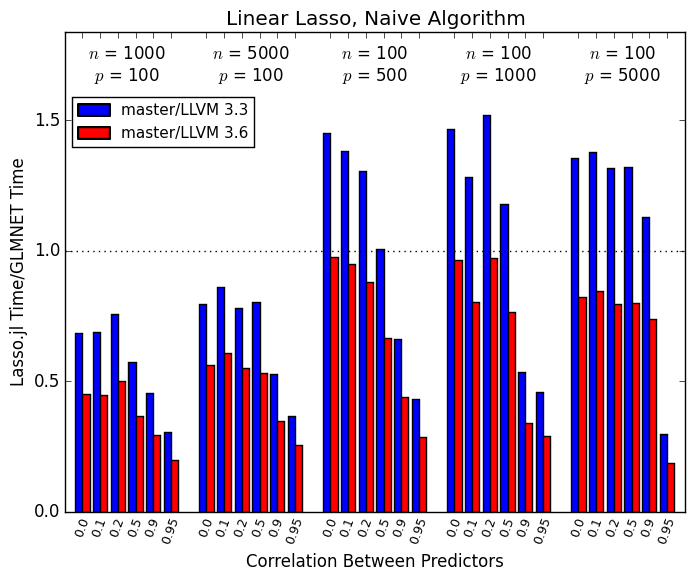

In [196]:
benchmarks(lasso_llvm_33[1:30], lasso_llvm_36[1:30], glmnet_llvm_33[1:30]);
title("Linear Lasso, Naive Algorithm");

# Lasso.jl Performance

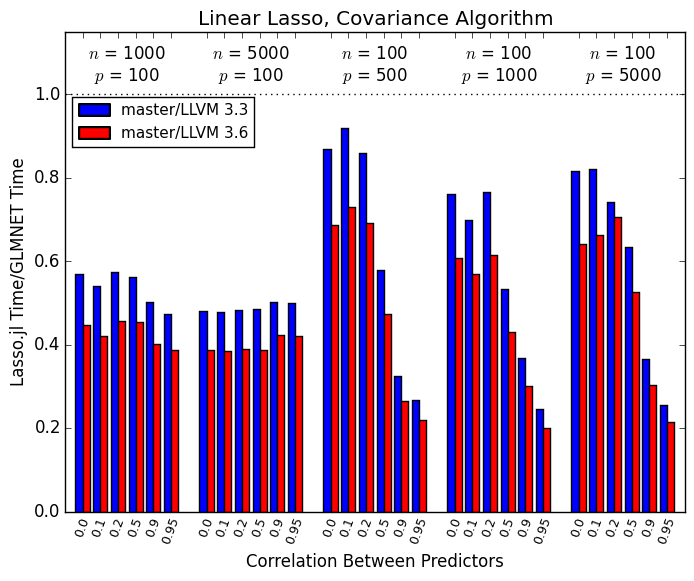

In [197]:
benchmarks(lasso_llvm_33[31:60], lasso_llvm_36[31:60], glmnet_llvm_33[31:60]);
title("Linear Lasso, Covariance Algorithm");

# Lasso.jl Performance

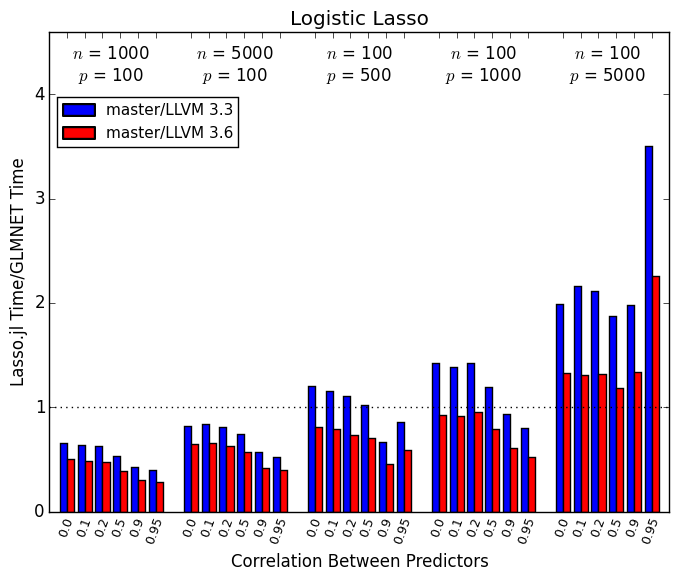

In [198]:
benchmarks(lasso_logistic_llvm_33[1:30], lasso_logistic_llvm_36[1:30], glmnet_logistic_llvm_33[1:30]);
title("Logistic Lasso");

# More L1 regression

 - [Lasso.jl](https://github.com/simonster/Lasso.jl)
   - Elastic net
   - Fused lasso
   - Trend filtering
 - [LARS.jl](https://github.com/simonster/LARS.jl)
   - Lasso path algorithm (least angle regression)
   - Lasso significance test

# Optimizations

 - If computing for many $\lambda$, use previous coefficients as warm start
 - Precompute more things to make updates less expensive
 - Active set
   - Cycle over non-zero coefficients more often
   - Postpone some work until coefficients become non-zero
 - Cycle over coefficients in random order (not in GLMNET)